In [1]:
# visualization and database management
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from sklearn.utils import shuffle

# Machine learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import scale

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#auto load external code.
%load_ext autoreload  
%autoreload 2

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set large font for presentation
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set_style('darkgrid')

In [3]:
os.chdir('/Users/trongnguyen/Dropbox/FattyLiver/src/hydrogen/')
from helper_brl.visualizeHelper import extract_segment_points, envDetection, filter_frame
from helper_brl.fattyLiver import get_training_data, get_testing_data, choose_testing_rabbits_indices
from helper_brl.outlierDetection import getBSC_Att, filter_bsc, filter_BSC_based_on_depth, findOutliers
from helper_brl import frequencyAnalysis
from helper_brl.formFactor import get_ESD_EAC, gaussian_form_factor_bsc, exponential_form_factor_bsc, ESD_EAC_features
from helper_brl.ml_preprocessing import percentageVariance, cal_accuracy, randomize_and_filter

# Load Data

In [6]:
newdataBase = pd.read_excel('/Users/trongnguyen/Dropbox/FattyLiver/Rabbit_Liver_40.xlsx', sheet_name=0)
aliveOnly = newdataBase[newdataBase['Timely death'] == 1]
dataBase = aliveOnly[['Rabbit', 'Injection level', 'Weeks on diet','Lipid']]
dataBase = dataBase[dataBase['Injection level'] ==0]

threshold_lipid = 9
dataBase['High'] = dataBase.Lipid > threshold_lipid
dataBase = dataBase.sort_values(['Lipid'])
dataBase.index = range(1, 16)

In [7]:
dataBase[dataBase.Lipid > threshold_lipid]['Lipid'].describe()

count     8.000000
mean     14.021250
std       3.250316
min       9.810000
25%      12.607500
50%      13.920000
75%      14.712500
max      20.660000
Name: Lipid, dtype: float64

In [8]:
dataBase[dataBase.Lipid <= threshold_lipid]['Lipid'].describe()

count    7.000000
mean     5.740000
std      2.116294
min      3.270000
25%      3.695000
50%      6.600000
75%      7.360000
max      8.200000
Name: Lipid, dtype: float64

In [15]:
%qtconsole

In [9]:
dataBase['Labels'] = dataBase['High'].apply(lambda x: 'High fat' if x else 'Low fat')

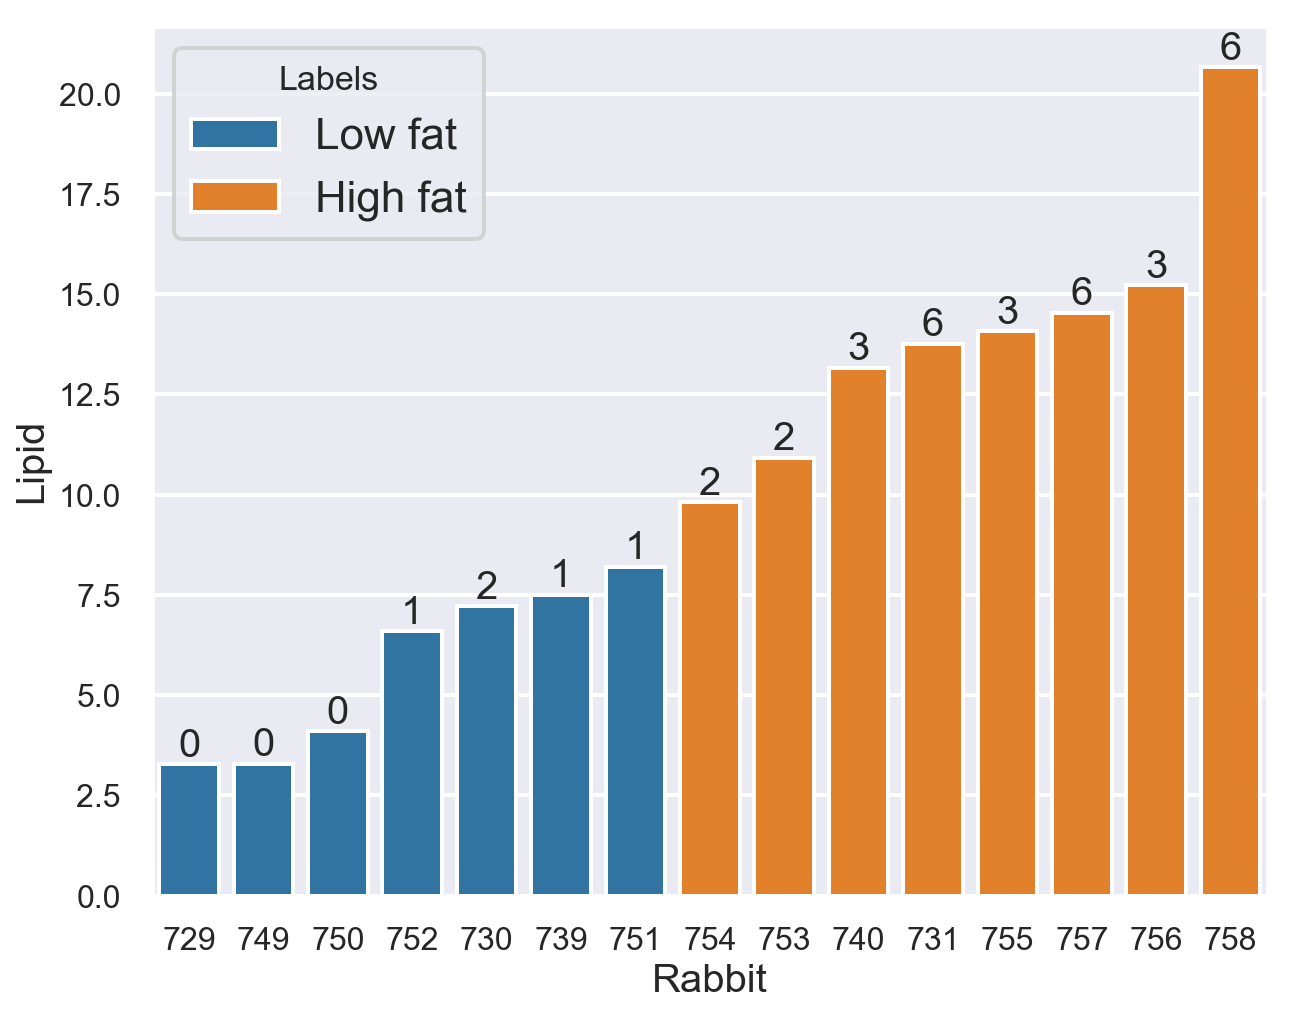

In [10]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = 'Rabbit', y = 'Lipid', data = dataBase, hue = 'Labels', \
                 order=dataBase.Rabbit, dodge = False)
count = 1
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    no_weeks = dataBase['Weeks on diet'][count]
    count = count + 1
    plt.text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            no_weeks,
            ha="center") 

## Input/output data  - Load BSC and ATT

In [11]:
#RIGHT_SIDE = ['750', '754', '753']
#RIGHT_SIDE = ['750', '730']
RIGHT_SIDE = ['754', '751', '729']

In [12]:
ATTs_dict, freq_att_dict, freq_bsc_dict, depth_dict, BSCs_dict = {}, {}, {}, {}, {} 
left_dict, right_dict, top_dict, bottom_dict = {}, {}, {}, {} # ROIs of each BSC
att_bottom, bad_BSC = {}, {}

#name_tag = 'fix_bug_average_ref_phantom_6MHz_v7_12a_30b'
name_tag = 'fix_bug_average_ref_phantom_3_6MHz_v8_10a40_30b'
for idx, row in dataBase.iterrows():
    number = str(int(row.Rabbit))
    print(number, end = ', ')
    if number in RIGHT_SIDE:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_right/BSC_ATT/"
    else:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_left/BSC_ATT/"
    ATTs_dict[number], freq_att_dict[number], BSCs_dict[number], freq_bsc_dict[number], \
    depth_dict[number], left_dict[number], right_dict[number], \
    top_dict[number], bottom_dict[number], att_bottom[number], bad_BSC[number] = getBSC_Att(path,name_tag)

729, 749, 750, 752, 730, 739, 751, 754, 753, 740, 731, 755, 757, 756, 758, 

In [10]:
rf_hdf5_path = '/Volumes/TrongDrive/Liver_Study/RF_hdf5/'
root_path = '/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L'

In [14]:
file_path = "/Users/trongnguyen/Downloads/CODE/BatchProcessing/TrongCode/BSC_trong/LO_FREQ_REF_6.20.11.txt"
data = pd.read_csv(file_path, sep="\t", header=None)
data.columns = ['Frequency', 'BSC']

# PCA and Random Forest and CNN stuff

In [ ]:
all_idx = []
no_cv = 15
for i in range(no_cv):
    no_testing = 1
    testing_idx = choose_testing_rabbits_indices(dataBase, no_testing, all_idx)
    all_idx.extend(testing_idx)
    print(testing_idx)

In [13]:
all_idx = dataBase.Rabbit.as_matrix()
no_cv = 15

In [14]:
freq_key = next(iter(freq_bsc_dict['729']))
freq = freq_bsc_dict['729'][freq_key].flatten()
print(freq)

[3.         3.00293255 3.0058651  ... 5.9941349  5.99706745 6.        ]


## Compare PCA vs ESD_EAC_linear fit

[729]
Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 69 69
Training and testing shape (3163, 1024) (69, 1024)
Labels shape: (3163,) (69,)
Explained variance 0.9653548257859879
(69, 2) (3163, 2)
Linear ROI testing accuracy: 0.9710144927536232
PCA ROI testing accuracy: 0.9565217391304348
Linear ROI Training accuracy: 0.8757508694277585
PCA ROI Training accuracy: 0.8713246917483402
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


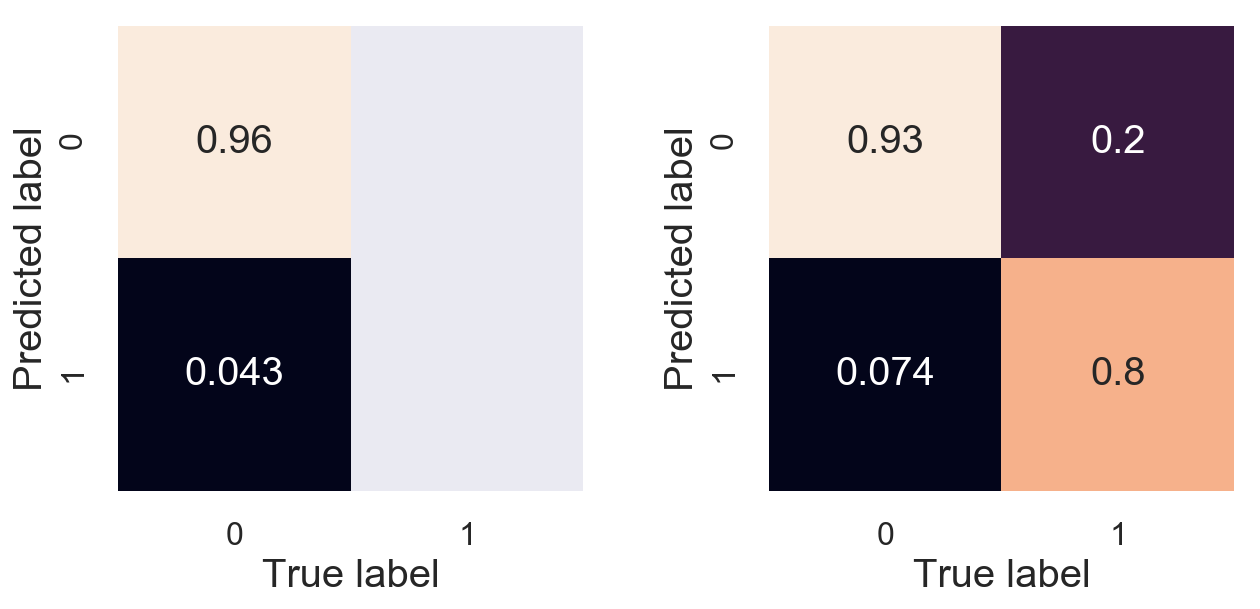

[749]
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip, 749,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 391 390
Training and testing shape (2842, 1024) (390, 1024)
Labels shape: (2842,) (390,)
Explained variance 0.9658873668027962
(390, 2) (2842, 2)
Linear ROI testing accuracy: 0.9435897435897436
PCA ROI testing accuracy: 0.9358974358974359
Linear ROI Training accuracy: 0.8680506685432794
PCA ROI Training accuracy: 0.8652357494722027
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


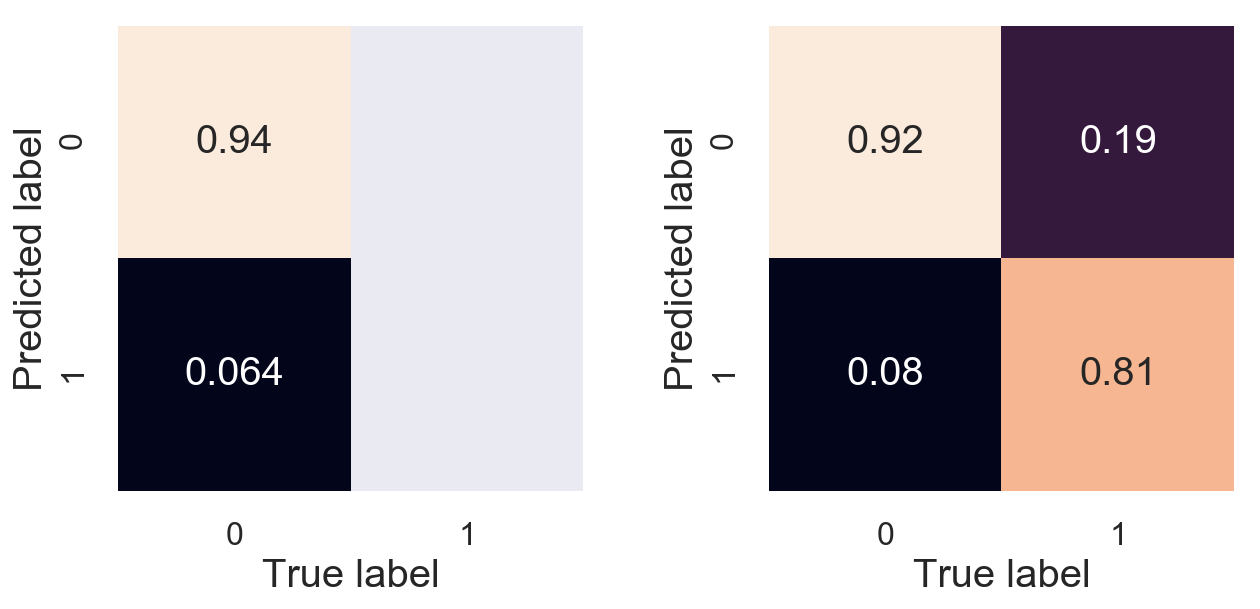

[750]
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, 750,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 37 37
Training and testing shape (3195, 1024) (37, 1024)
Labels shape: (3195,) (37,)
Explained variance 0.9633727848029435
(37, 2) (3195, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8766823161189359
PCA ROI Training accuracy: 0.8726134585289514
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


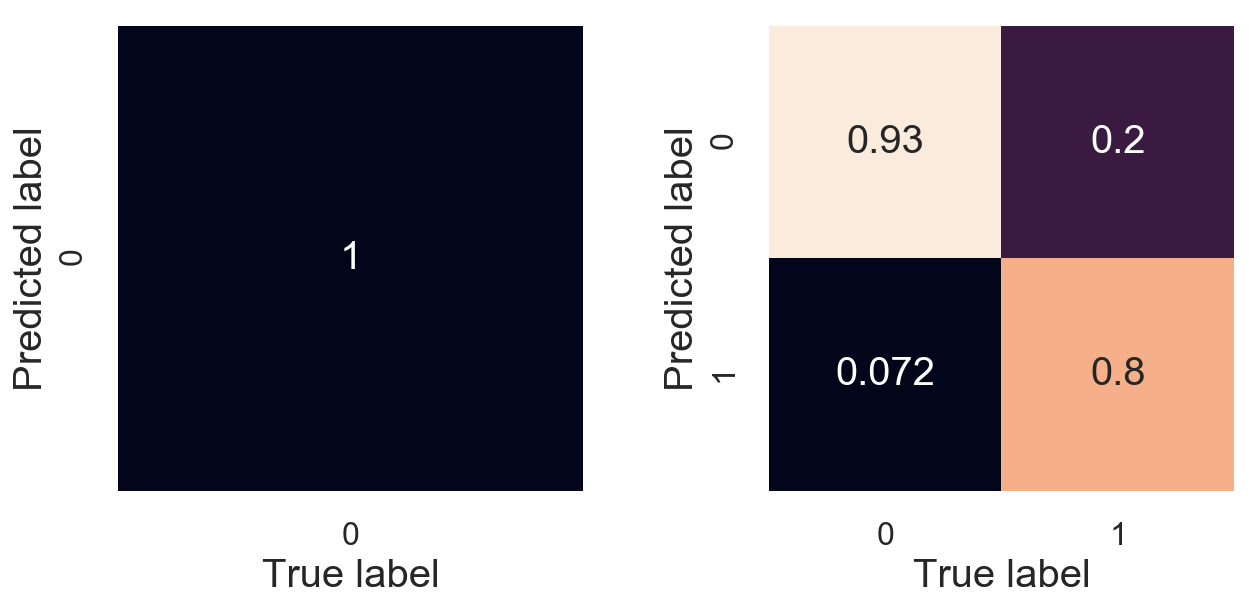

[752]
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 247 247
Training and testing shape (2985, 1024) (247, 1024)
Labels shape: (2985,) (247,)
Explained variance 0.9672420088123621
(247, 2) (2985, 2)
Linear ROI testing accuracy: 0.7408906882591093
PCA ROI testing accuracy: 0.708502024291498
Linear ROI Training accuracy: 0.8840871021775545
PCA ROI Training accuracy: 0.8847571189279732
PCA Frame accuracy 0.8541666666666666
Linear frame accuracy 0.875


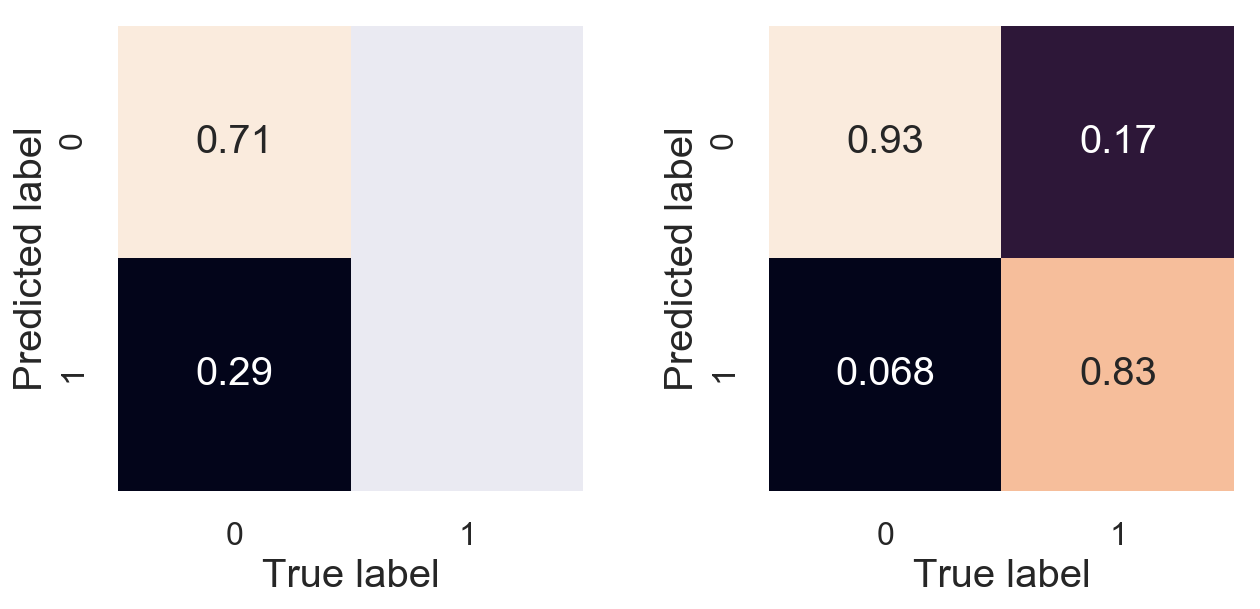

[730]
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, 730,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 140 134
Training and testing shape (3098, 1024) (134, 1024)
Labels shape: (3098,) (134,)
Explained variance 0.9618103406144417
(134, 2) (3098, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8737895416397676
PCA ROI Training accuracy: 0.8695932859909619
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


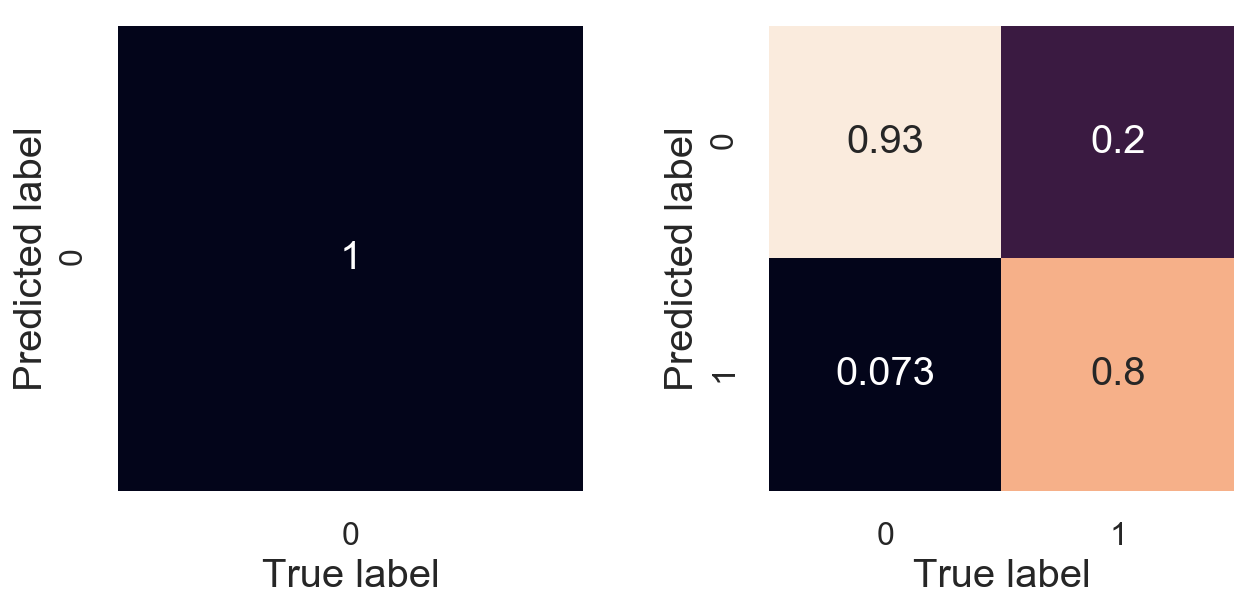

[739]
729,749,750,752,730,Skip,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, 739,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 699 699
Training and testing shape (2533, 1024) (699, 1024)
Labels shape: (2533,) (699,)
Explained variance 0.970676439306832
(699, 2) (2533, 2)
Linear ROI testing accuracy: 0.9170243204577968
PCA ROI testing accuracy: 0.9155937052932761
Linear ROI Training accuracy: 0.8594551914725622
PCA ROI Training accuracy: 0.8578760363205685
PCA Frame accuracy 0.9591836734693877
Linear frame accuracy 0.9387755102040817


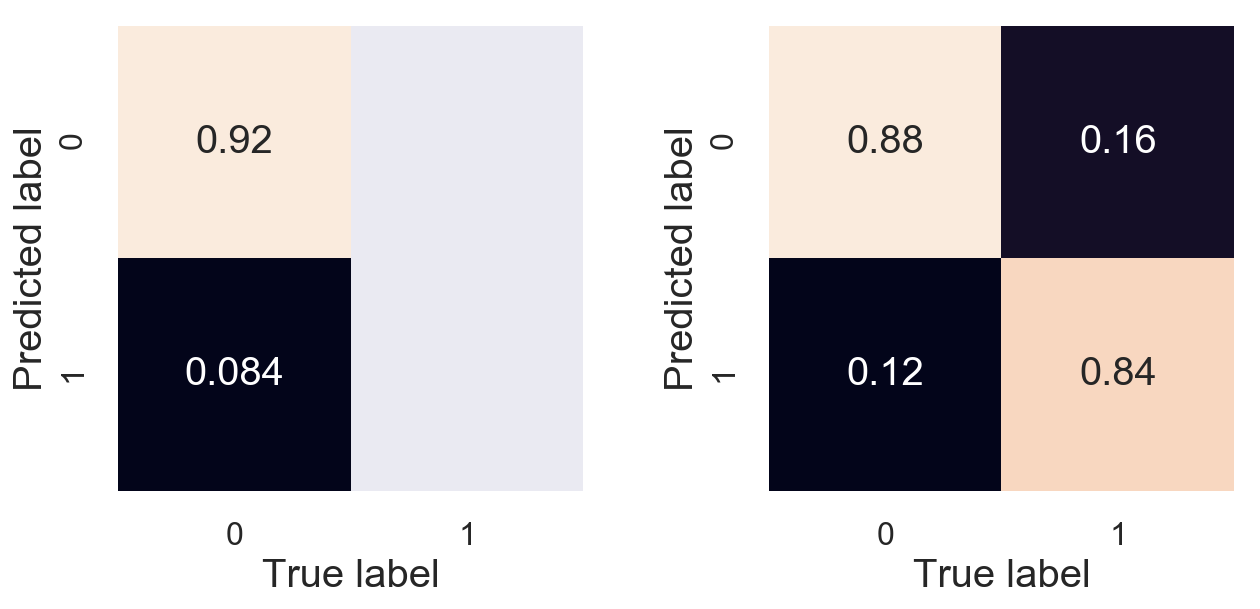

[751]
729,749,750,752,730,739,Skip,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, 751,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 302 302
Training and testing shape (2930, 1024) (302, 1024)
Labels shape: (2930,) (302,)
Explained variance 0.9676473294596462
(302, 2) (2930, 2)
Linear ROI testing accuracy: 0.9470198675496688
PCA ROI testing accuracy: 0.9271523178807947
Linear ROI Training accuracy: 0.8675767918088737
PCA ROI Training accuracy: 0.8662116040955632
PCA Frame accuracy 0.9583333333333334
Linear frame accuracy 0.9791666666666666


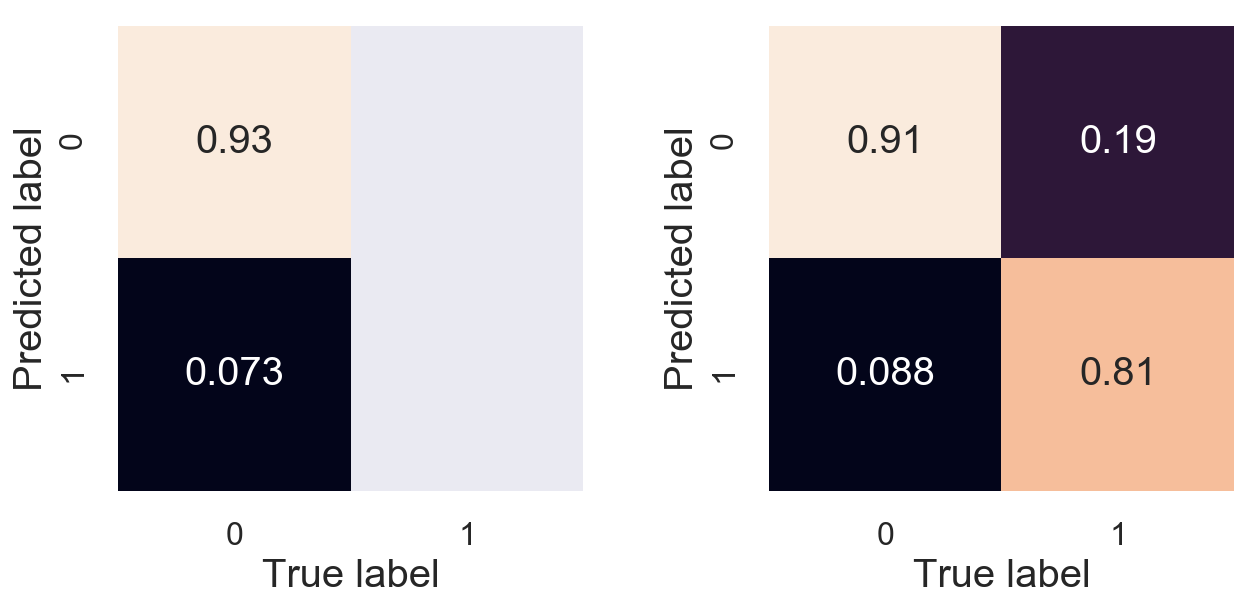

[754]
729,749,750,752,730,739,751,Skip,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 754,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 58 58
Training and testing shape (3174, 1024) (58, 1024)
Labels shape: (3174,) (58,)
Explained variance 0.9651576012424753
(58, 2) (3174, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8764965343415249
PCA ROI Training accuracy: 0.87177063642092
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


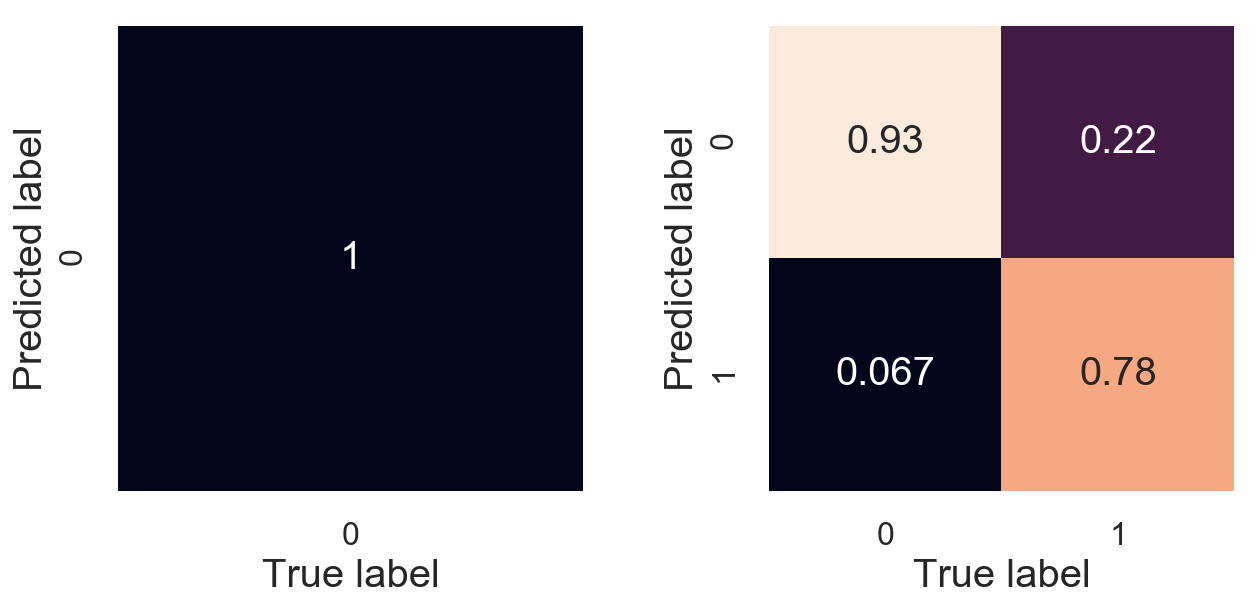

[753]
729,749,750,752,730,739,751,754,Skip,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 753,Skip, Skip, Skip, Skip, Skip, Skip, 
 Frame break: 170 170
Training and testing shape (3062, 1024) (170, 1024)
Labels shape: (3062,) (170,)
Explained variance 0.9656840779308418
(170, 2) (3062, 2)
Linear ROI testing accuracy: 0.11176470588235295
PCA ROI testing accuracy: 0.14705882352941177
Linear ROI Training accuracy: 0.9248856956237753
PCA ROI Training accuracy: 0.9193337687785761
PCA Frame accuracy 0.13513513513513514
Linear frame accuracy 0.08108108108108109


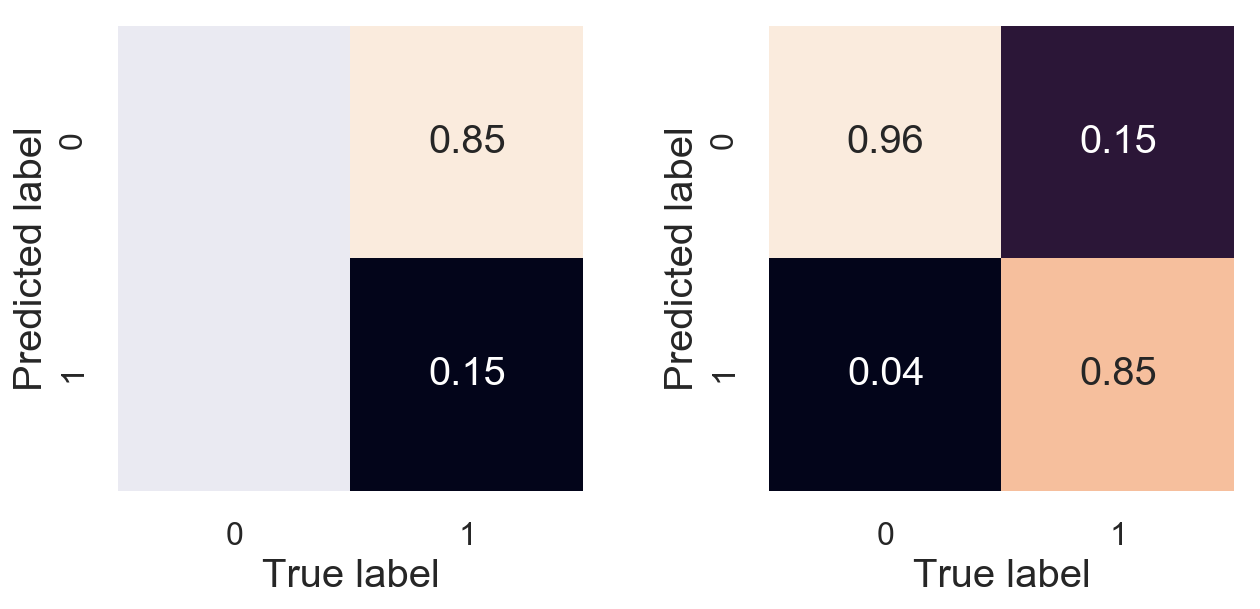

[740]
729,749,750,752,730,739,751,754,753,Skip,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 740,Skip, Skip, Skip, Skip, Skip, 
 Frame break: 87 87
Training and testing shape (3145, 1024) (87, 1024)
Labels shape: (3145,) (87,)
Explained variance 0.9653456594992642
(87, 2) (3145, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8756756756756757
PCA ROI Training accuracy: 0.8699523052464229
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


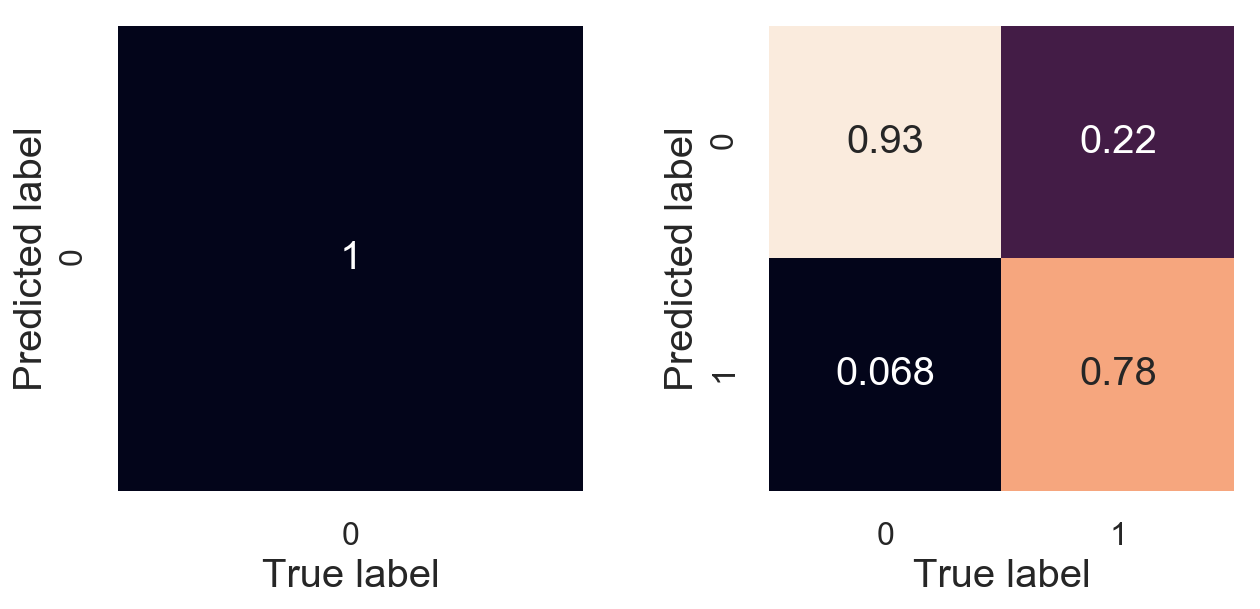

[731]
729,749,750,752,730,739,751,754,753,740,Skip,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 731,Skip, Skip, Skip, Skip, 
 Frame break: 138 138
Training and testing shape (3094, 1024) (138, 1024)
Labels shape: (3094,) (138,)
Explained variance 0.9654070558490624
(138, 2) (3094, 2)
Linear ROI testing accuracy: 0.8333333333333334
PCA ROI testing accuracy: 0.8043478260869565
Linear ROI Training accuracy: 0.8797672915319974
PCA ROI Training accuracy: 0.8781512605042017
PCA Frame accuracy 0.9512195121951219
Linear frame accuracy 0.975609756097561


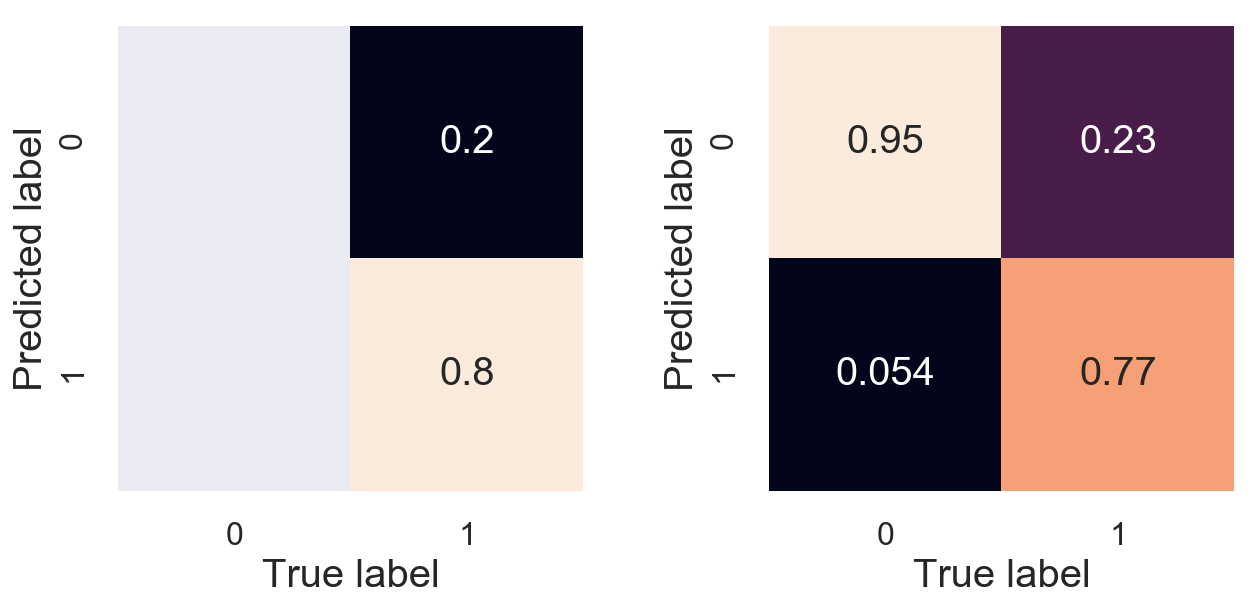

[755]
729,749,750,752,730,739,751,754,753,740,731,Skip,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 755,Skip, Skip, Skip, 
 Frame break: 206 206
Training and testing shape (3026, 1024) (206, 1024)
Labels shape: (3026,) (206,)
Explained variance 0.966231780872108
(206, 2) (3026, 2)
Linear ROI testing accuracy: 0.16990291262135923
PCA ROI testing accuracy: 0.21359223300970873
Linear ROI Training accuracy: 0.9312623925974884
PCA ROI Training accuracy: 0.9230006609385327
PCA Frame accuracy 0.14285714285714285
Linear frame accuracy 0.08163265306122448


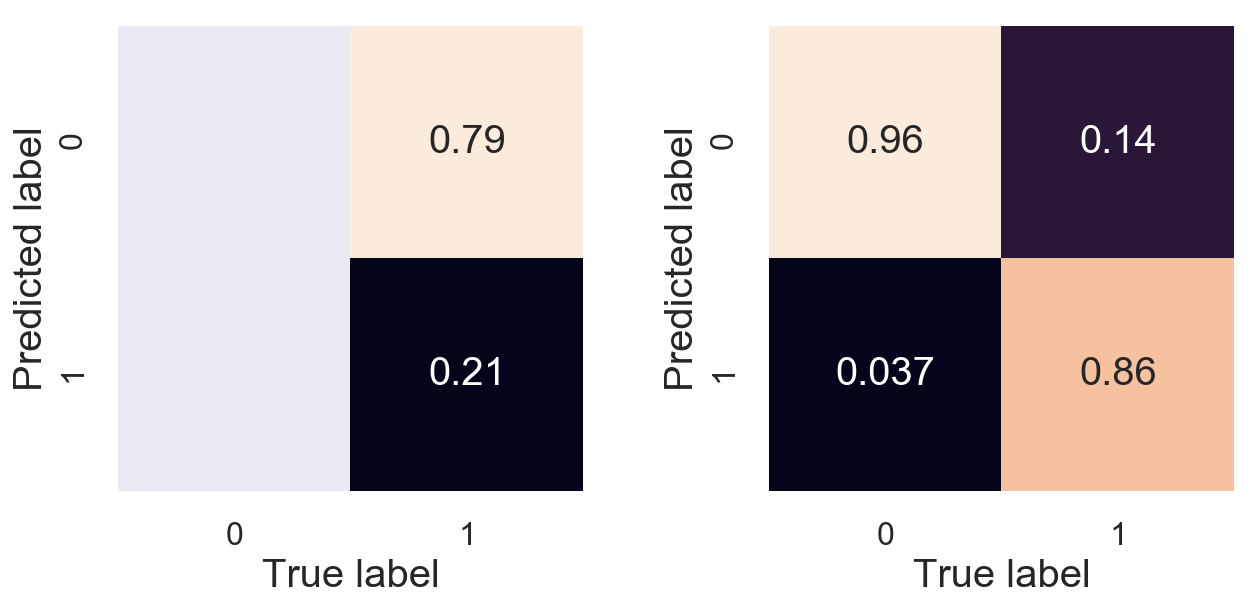

[757]
729,749,750,752,730,739,751,754,753,740,731,755,Skip,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 757,Skip, Skip, 
 Frame break: 104 104
Training and testing shape (3128, 1024) (104, 1024)
Labels shape: (3128,) (104,)
Explained variance 0.9651723375188234
(104, 2) (3128, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8740409207161125
PCA ROI Training accuracy: 0.8702046035805626
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


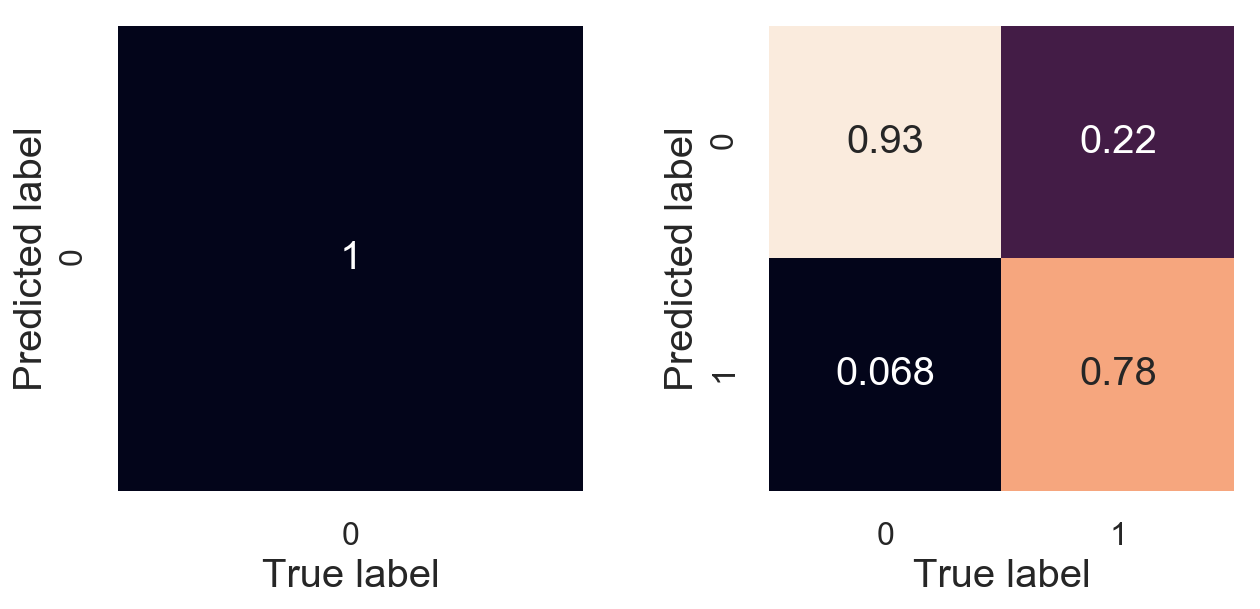

[756]
729,749,750,752,730,739,751,754,753,740,731,755,757,Skip,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 756,Skip, 
 Frame break: 41 41
Training and testing shape (3191, 1024) (41, 1024)
Labels shape: (3191,) (41,)
Explained variance 0.9650477135312817
(41, 2) (3191, 2)
Linear ROI testing accuracy: 1.0
PCA ROI testing accuracy: 1.0
Linear ROI Training accuracy: 0.8777812597931682
PCA ROI Training accuracy: 0.8727671576308367
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


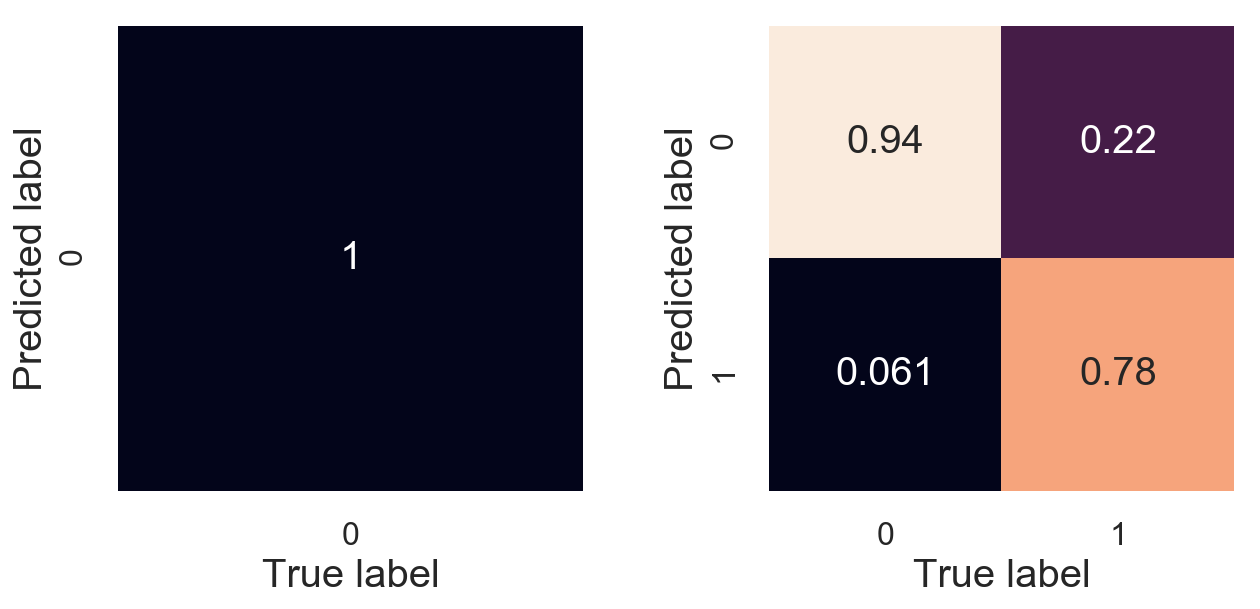

[758]
729,749,750,752,730,739,751,754,753,740,731,755,757,756,Skip,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 758,
 Frame break: 550 550
Training and testing shape (2682, 1024) (550, 1024)
Labels shape: (2682,) (550,)
Explained variance 0.9043999507243791
(550, 2) (2682, 2)
Linear ROI testing accuracy: 0.9781818181818182
PCA ROI testing accuracy: 0.9872727272727273
Linear ROI Training accuracy: 0.854586129753915
PCA ROI Training accuracy: 0.8504847129008203
PCA Frame accuracy 1.0
Linear frame accuracy 1.0


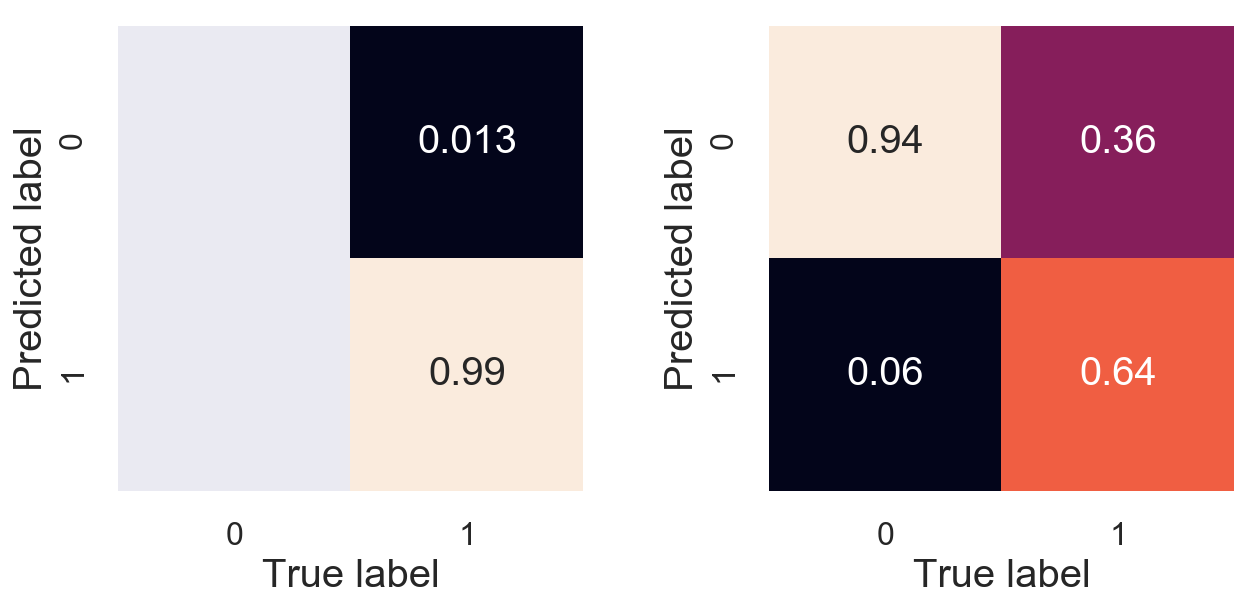

In [21]:
no_components = 2
#no_test_rabbits = no_testing * 2
accuracy_frame_comparison = np.zeros((no_cv, 4))
accuracy_roi_comparison = np.zeros((no_cv, 4))
for i in range(no_cv):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)
    
    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test)   
 
    flat_list = [item for sublist in frame_idx for item in sublist]
    frame_idx1 = np.array(flat_list) 
    frame_idx = frame_idx1[idxs2]
    
    print("\n Frame break: ", end = '')
    print(np.sum(np.array(frame_break)), len(frame_idx))
    
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    
    pca1 = PCA() ## PCA in the log10 of the BSCs.
    pca1.fit(np.log10(X_train))
    print("Explained variance", percentageVariance(pca1.explained_variance_, no_components))
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    pca.fit(np.log10(X_train))
    features_train  = pca.transform(np.log10(X_train))
    features_test  = pca.transform(np.log10(X_test))
    print(features_test.shape, features_train.shape)
    
    clf = svm.SVC(C=10.0, kernel='linear', gamma=0.1) #{'C': 10, 'gamma': 0.1}
    clf_linear = svm.SVC(C=10.0, kernel='linear', gamma=0.1)
    
    linear_train = ESD_EAC_features(freq, X_train)
    linear_test = ESD_EAC_features(freq, X_test) 
    
    #clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(features_train, y_train)
    clf_linear.fit(linear_train, y_train)
    
    y_predict_linear = clf_linear.predict(linear_test)
    y_predict_pca = clf.predict(features_test)
    y_train_predict_pca = clf.predict(features_train)
    
    accuracy_roi_comparison[i, 0] = accuracy_score(y_test, y_predict_linear)
    print('Linear ROI testing accuracy:', accuracy_roi_comparison[i, 0])
    
    accuracy_roi_comparison[i, 1] = accuracy_score(y_test, y_predict_pca)
    print('PCA ROI testing accuracy:', accuracy_roi_comparison[i, 1])
    
    accuracy_roi_comparison[i, 2] = accuracy_score(y_train, clf_linear.predict(linear_train))
    print('Linear ROI Training accuracy:', accuracy_roi_comparison[i, 2])
    
    accuracy_roi_comparison[i, 3] = accuracy_score(y_train, y_train_predict_pca)
    print('PCA ROI Training accuracy:', accuracy_roi_comparison[i, 3])
    
    frame_accuracy = cal_accuracy(y_test, y_predict_pca, np.append(frame_idx, '0'))
    accuracy_frame_comparison[i, 1] = np.sum(frame_accuracy)/len(frame_accuracy)
    print('PCA Frame accuracy', accuracy_frame_comparison[i, 1])
    
    frame_accuracy = cal_accuracy(y_test, y_predict_linear, np.append(frame_idx, '0'))
    accuracy_frame_comparison[i, 0] = np.sum(frame_accuracy)/len(frame_accuracy)
    print('Linear frame accuracy', accuracy_frame_comparison[i, 0] )
    
    plt.figure(figsize = (10, 8))
    plt.subplots_adjust(wspace = 0.4)
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_predict_pca) # generate the confusion matrix
    n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the accuracy
    #print(classification_report(y_test, y_predict_pca))
    sns.heatmap(n_cm.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_train, y_train_predict_pca) # generate the confusion matrix
    n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the accuracy
    sns.heatmap(n_cm.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    #print(classification_report(y_train, y_train_predict ))

In [22]:
# 3 components
print("Linear testing | PCA testing | Linear training | PCA training")
print(accuracy_roi_comparison)
print('------')
print(np.mean(accuracy_roi_comparison, axis =0))
print('-------')
print(accuracy_frame_comparison)
print('-------')
print(np.mean(accuracy_frame_comparison, axis =0))

Linear testing | PCA testing | Linear training | PCA training
[[0.97101449 0.95652174 0.87575087 0.87132469]
 [0.94358974 0.93589744 0.86805067 0.86523575]
 [1.         1.         0.87668232 0.87261346]
 [0.74089069 0.70850202 0.8840871  0.88475712]
 [1.         1.         0.87378954 0.86959329]
 [0.91702432 0.91559371 0.85945519 0.85787604]
 [0.94701987 0.92715232 0.86757679 0.8662116 ]
 [1.         1.         0.87649653 0.87177064]
 [0.11176471 0.14705882 0.9248857  0.91933377]
 [1.         1.         0.87567568 0.86995231]
 [0.83333333 0.80434783 0.87976729 0.87815126]
 [0.16990291 0.21359223 0.93126239 0.92300066]
 [1.         1.         0.87404092 0.8702046 ]
 [1.         1.         0.87778126 0.87276716]
 [0.97818182 0.98727273 0.85458613 0.85048471]]
------
[0.84084813 0.83972926 0.87999256 0.87621847]
-------
[[1.         1.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [0.875      0.85416667 0.    

In [17]:
print(accuracy_roi_comparison)
print(np.mean(accuracy_roi_comparison, axis =0))
print(accuracy_frame_comparison)
print(np.mean(accuracy_frame_comparison, axis =0))

[[0.97101449 0.89855072 0.92096111 1.        ]
 [0.96923077 0.95128205 0.9148487  1.        ]
 [0.97297297 1.         0.92081377 1.        ]
 [0.93117409 0.87854251 0.92026801 1.        ]
 [0.95522388 1.         0.9186572  1.        ]
 [0.86981402 0.77968526 0.92577971 1.        ]
 [0.83443709 0.74503311 0.92832765 1.        ]
 [1.         0.98275862 0.91965974 1.        ]
 [0.22352941 0.34705882 0.94546048 1.        ]
 [0.96551724 0.62068966 0.91860095 1.        ]
 [0.34057971 0.         0.91855204 1.        ]
 [0.19417476 0.15048544 0.95274289 1.        ]
 [0.99038462 0.         0.91911765 1.        ]
 [1.         0.95121951 0.92071451 1.        ]
 [1.         0.         0.90566741 1.        ]]
[0.81453687 0.62035371 0.92334479 1.        ]
[[0.94736842 0.89473684 0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [0.97916667 0.9375     0.         0.        ]
 [0.96551724 1.         0.         0.        ]
 [0.93877551 

In [14]:
no_components = 5
testing_idx = [729]
X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, \
                                                          BSCs_dict, freq_bsc_dict, depth_dict, True)

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 

In [15]:
X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test) 
print(X_train.shape, X_test.shape)

X_all = np.vstack((X_train, X_test))

pca = PCA(n_components=5) ## PCA in the log10 of the BSCs.
pca.fit(np.log10(X_all))
#features_train  = pca.transform(np.log10(X_train))
#features_test  = pca.transform(np.log10(X_test))
#print(features_test.shape, features_train.shape)

(2927, 1024) (125, 1024)


PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
features_all = pca.transform(np.log10(X_all))
X_recon = pca.inverse_transform(features_all)

In [18]:
features_all.shape

(3052, 5)

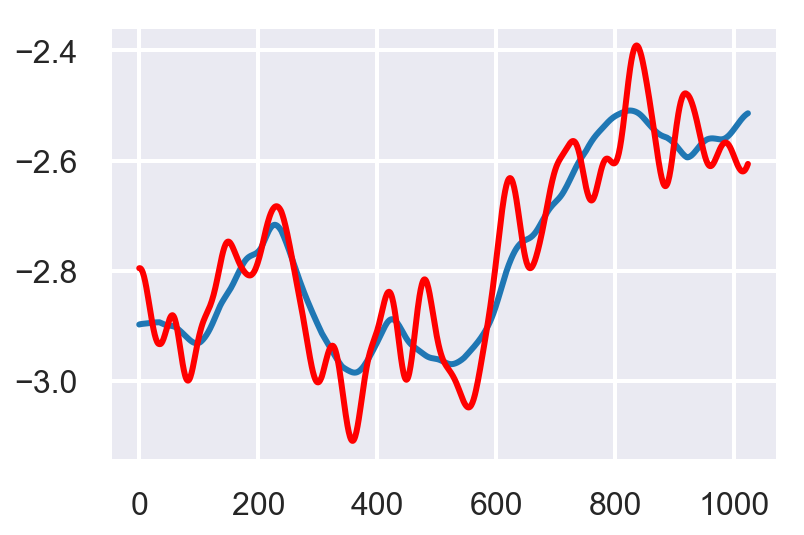

In [63]:
idx = np.random.randint(0, X_recon.shape[0])
plt.plot(X_recon[idx, :])
plt.plot(np.log10(X_all[idx,:]),'r')

In [22]:
%qtconsole

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (3163, 1024) (69, 1024)
Labels shape: (3163,) (69,)
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip, 749,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2842, 1024) (390, 1024)
Labels shape: (2842,) (390,)
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, 750,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (3195, 1024) (37, 1024)
Labels shape: (3195,) (37,)
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2985, 1024) (247, 1024)
Labels shape: (2985,) (247,)
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip,

Text(0,0.5,'PCA feature 2')

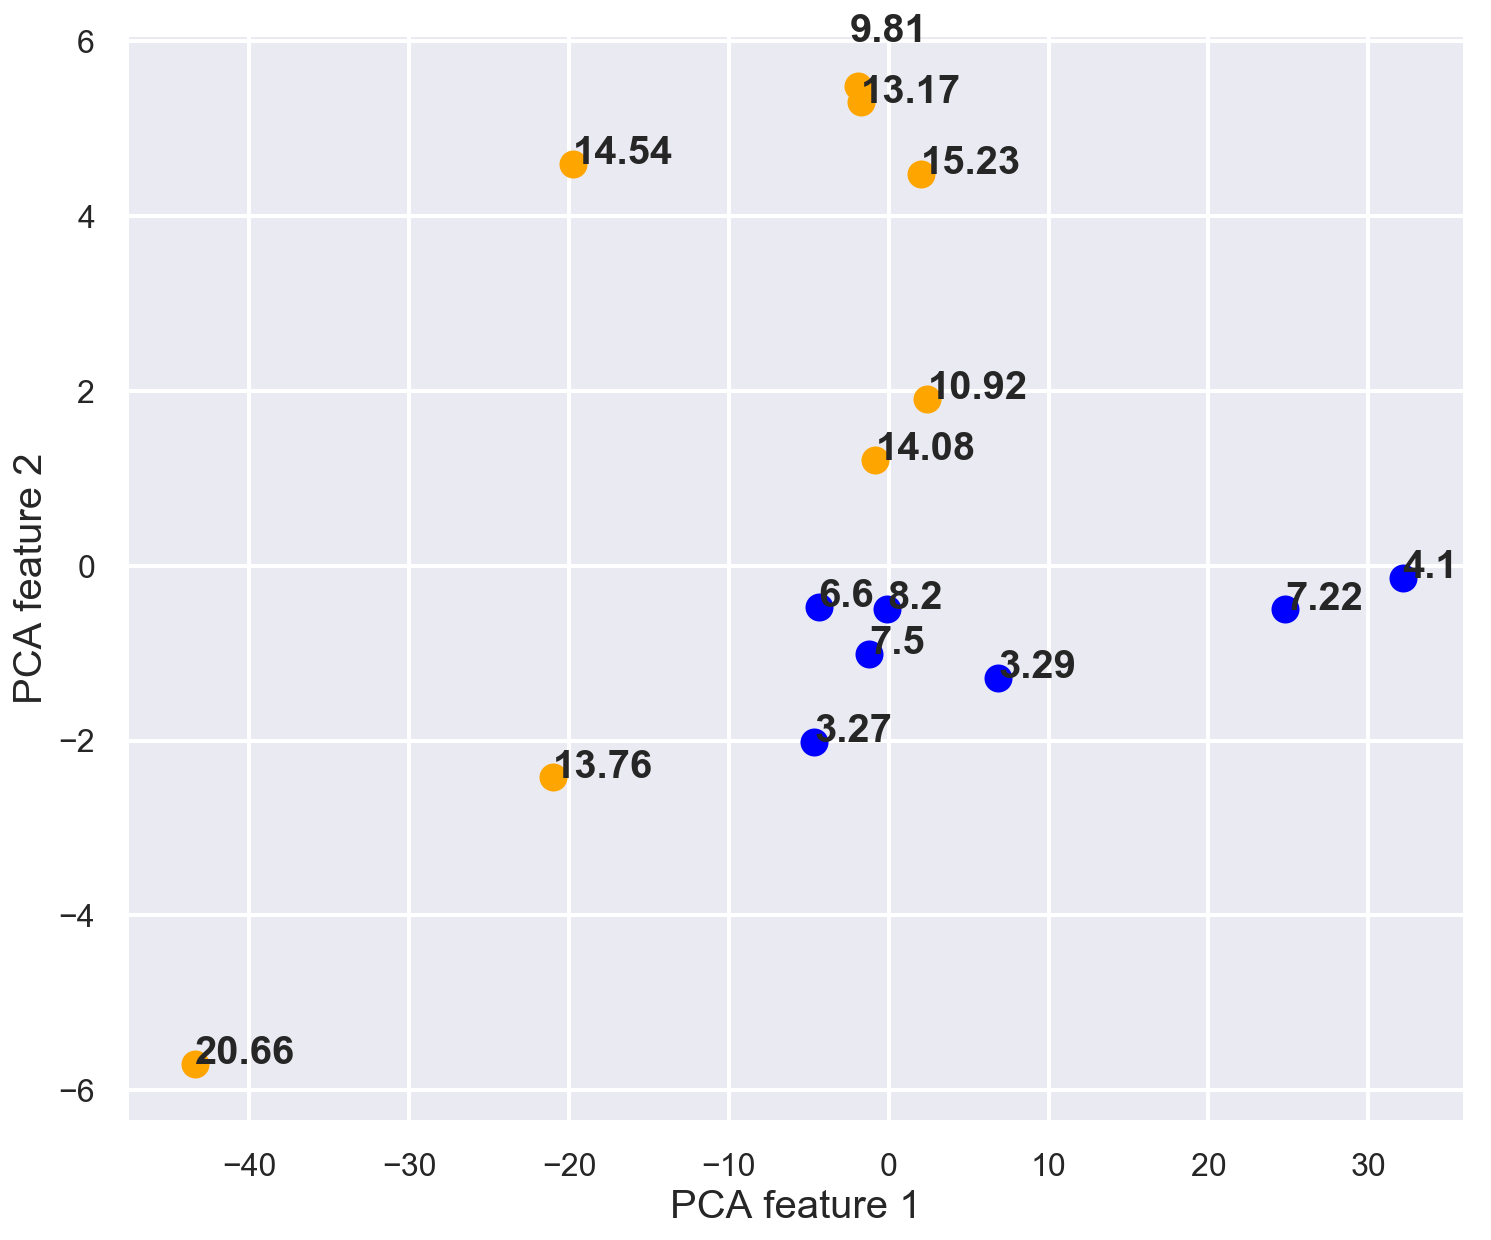

In [20]:
plt.figure(figsize = (12, 10))
for idx, row in dataBase.iterrows():
    number = (int(row.Rabbit))  
    lipid  = str(row.Lipid)
    testing_idx = [number]
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test)   
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)

    features_test  = pca.transform(np.log10(X_test))

    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
   
    #plt.scatter(features_test[l3, 0], features_test[l3, 1], c =np.random.rand(3,), s = 2, alpha = 0.6)
    if number == 754:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean()-0.5, features_test[l4, 1].mean()+0.5, lipid, fontweight = 'bold')
    else:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean(), features_test[l4, 1].mean(), lipid, fontweight = 'bold')
    if float(lipid) >=9:
        if l3.size > 0:
            plt.scatter(features_test[l3, 0].mean(), features_test[l3, 1].mean(), \
                        c = 'orange')
        if l4.size > 0:
            plt.scatter(features_test[l4, 0].mean(), features_test[l4, 1].mean(), c = 'orange')
    else:
        if l3.size > 0:
            plt.scatter(features_test[l3, 0].mean(), features_test[l3, 1].mean(), c = 'blue')
        if l4.size > 0:
            plt.scatter(features_test[l4, 0].mean(), features_test[l4, 1].mean(), c = 'blue')

    #plt.scatter(features_test[l4, 0], features_test[l4, 1], c = 'fuchsia', s = 2)
    #plt.title(str(testing_idx[0]))
    #plt.show()
    #break
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2927, 1024) (125, 1024)
Labels shape: (2927,) (125,)


/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Text(0,0.5,'PCA feature 2')

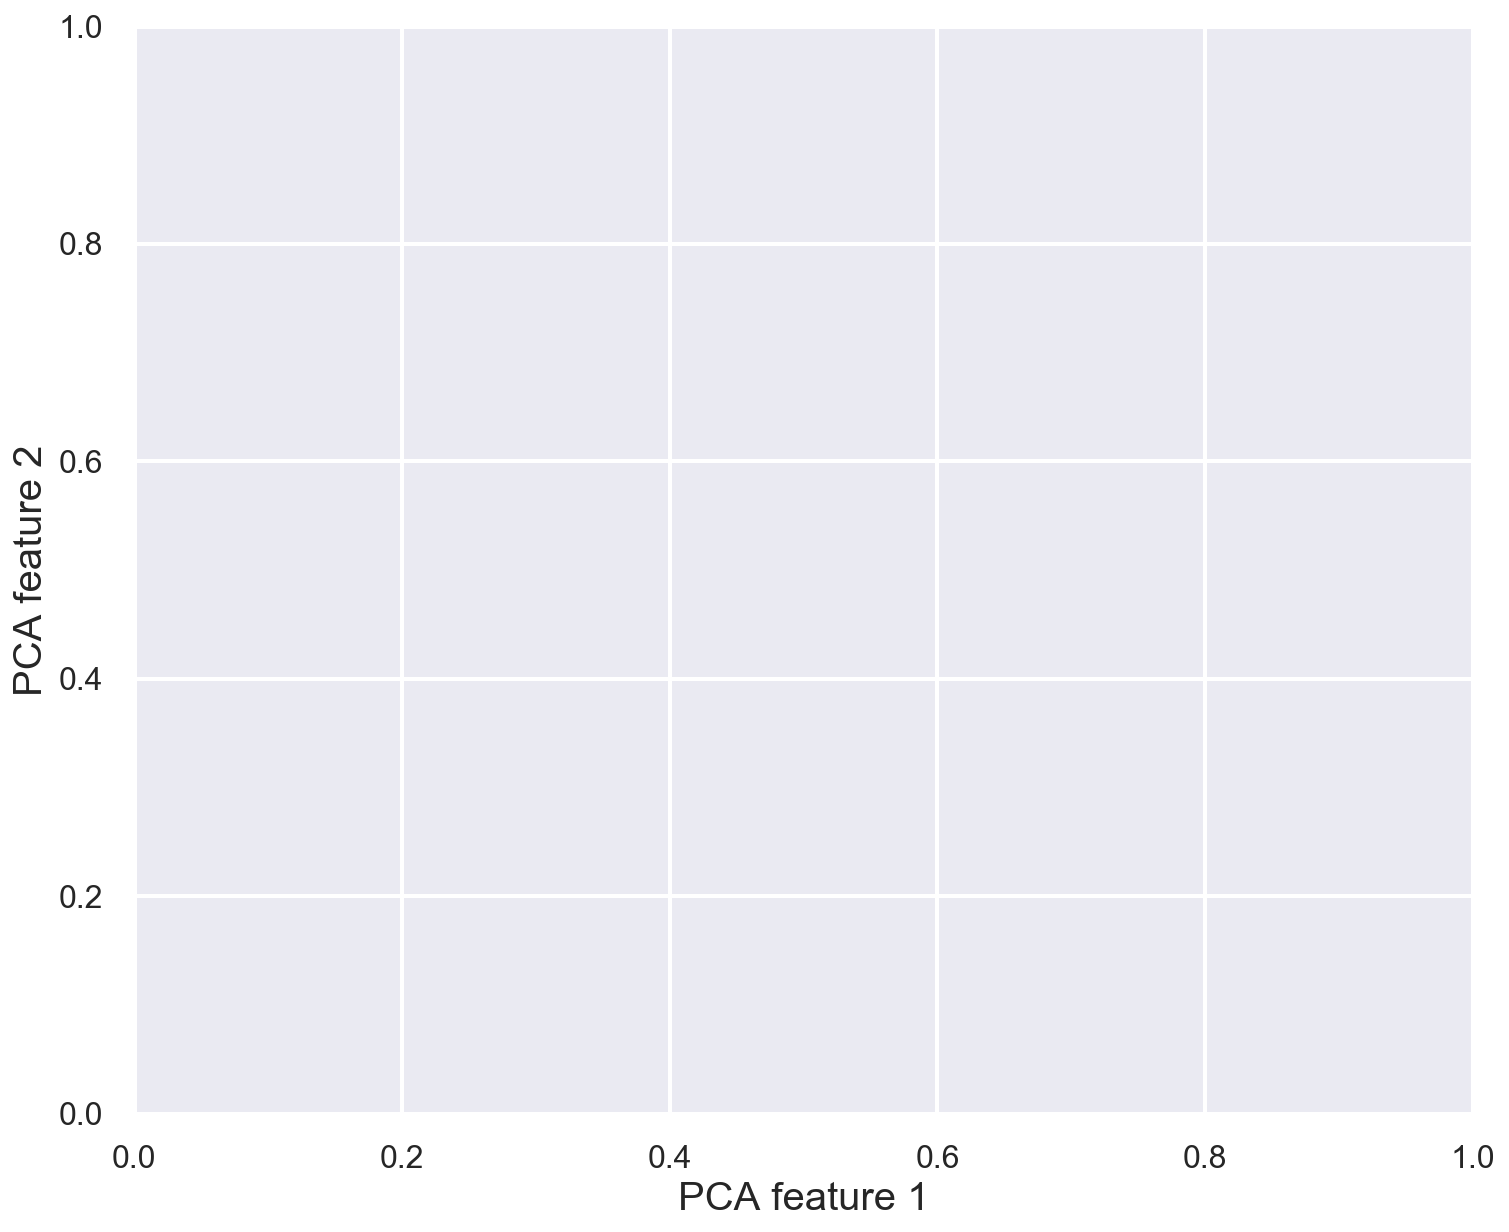

In [68]:

plt.figure(figsize = (12, 10))
for idx, row in dataBase.iterrows():
    number = (int(row.Rabbit))  
    lipid  = str(row.Lipid)
    testing_idx = [number]
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test)   
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    lda = LinearDiscriminantAnalysis(n_components=2)

    features_test = lda.fit(np.log10(X_train), y_train).transform(np.log10(X_test))
    #features_test  = pca.transform(np.log10(X_test))
    break
    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
   
    #plt.scatter(features_test[l3, 0], features_test[l3, 1], c =np.random.rand(3,), s = 2, alpha = 0.6)
    if number == 754:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean()-0.5, features_test[l4, 1].mean()+0.5, lipid, fontweight = 'bold')
    else:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean(), features_test[l4, 1].mean(), lipid, fontweight = 'bold')
    if float(lipid) >=9:
        if l3.size > 0:
            plt.scatter(features_test[l3, 0].mean(), features_test[l3, 1].mean(), \
                        c = 'orange')
        if l4.size > 0:
            plt.scatter(features_test[l4, 0].mean(), features_test[l4, 1].mean(), c = 'orange')
    else:
        if l3.size > 0:
            plt.scatter(features_test[l3, 0].mean(), features_test[l3, 1].mean(), c = 'blue')
        if l4.size > 0:
            plt.scatter(features_test[l4, 0].mean(), features_test[l4, 1].mean(), c = 'blue')

    #plt.scatter(features_test[l4, 0], features_test[l4, 1], c = 'fuchsia', s = 2)
    #plt.title(str(testing_idx[0]))
    #plt.show()
    #break
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2927, 1024) (125, 1024)
Labels shape: (2927,) (125,)


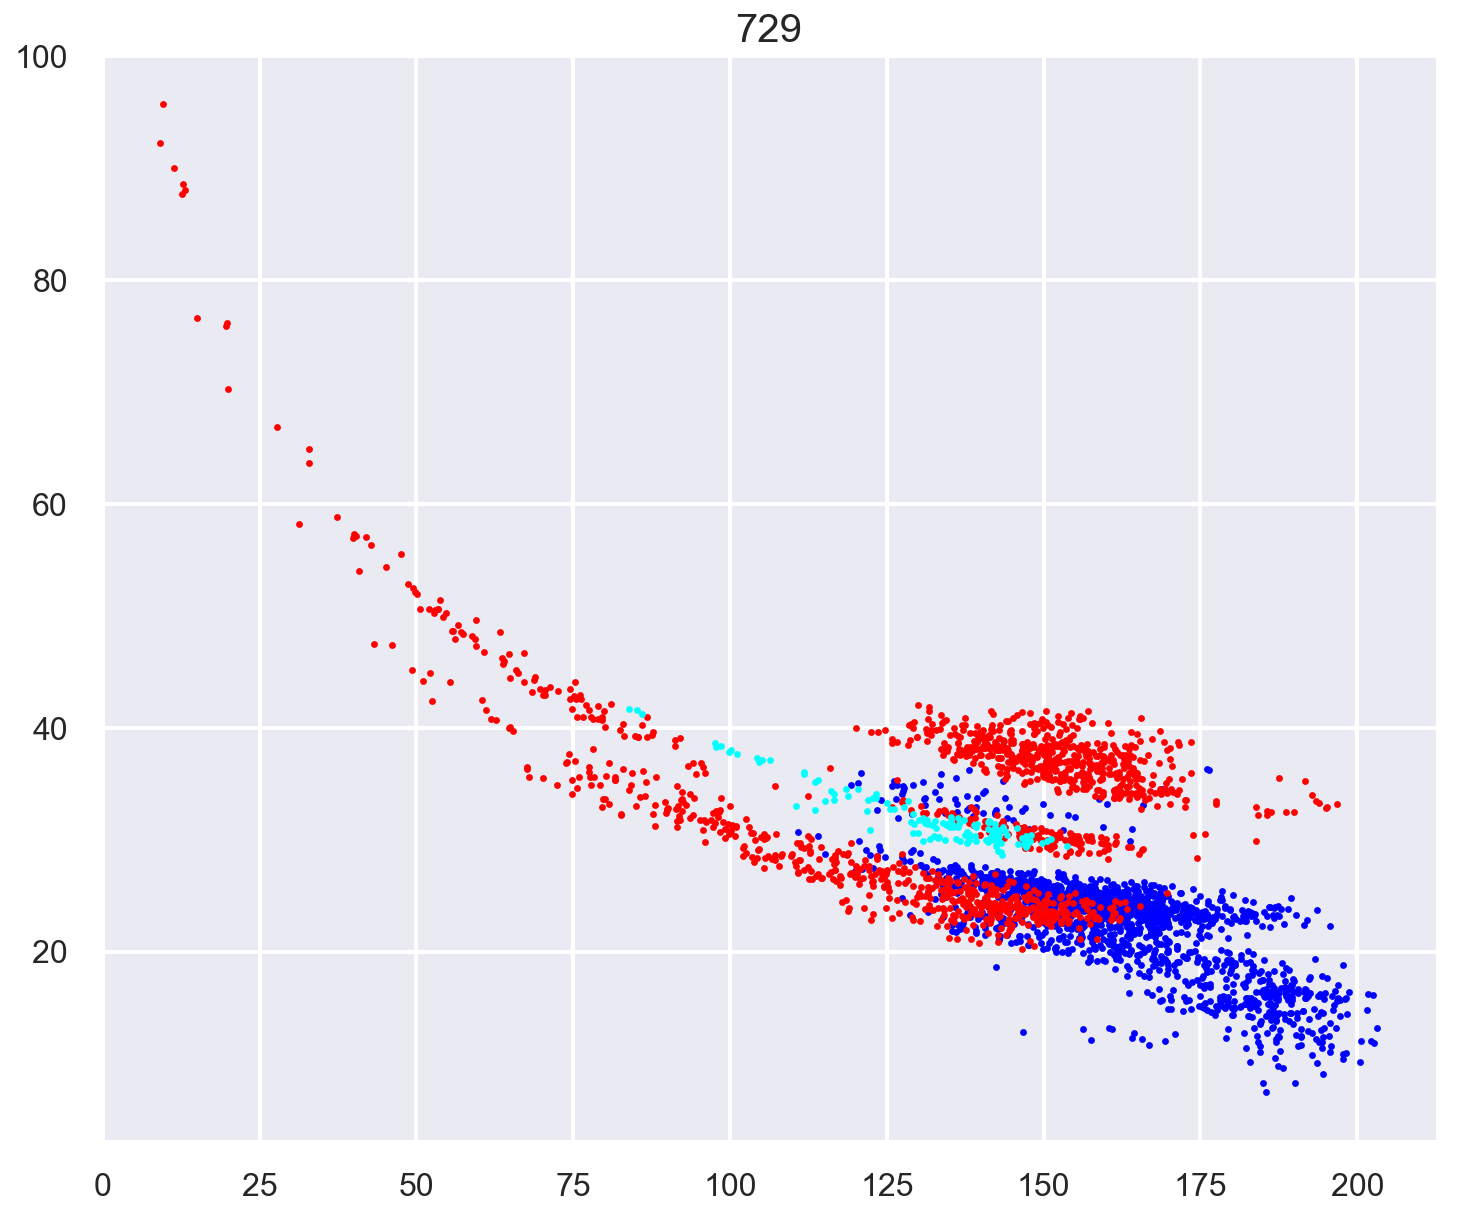

729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip, 749,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2662, 1024) (390, 1024)
Labels shape: (2662,) (390,)


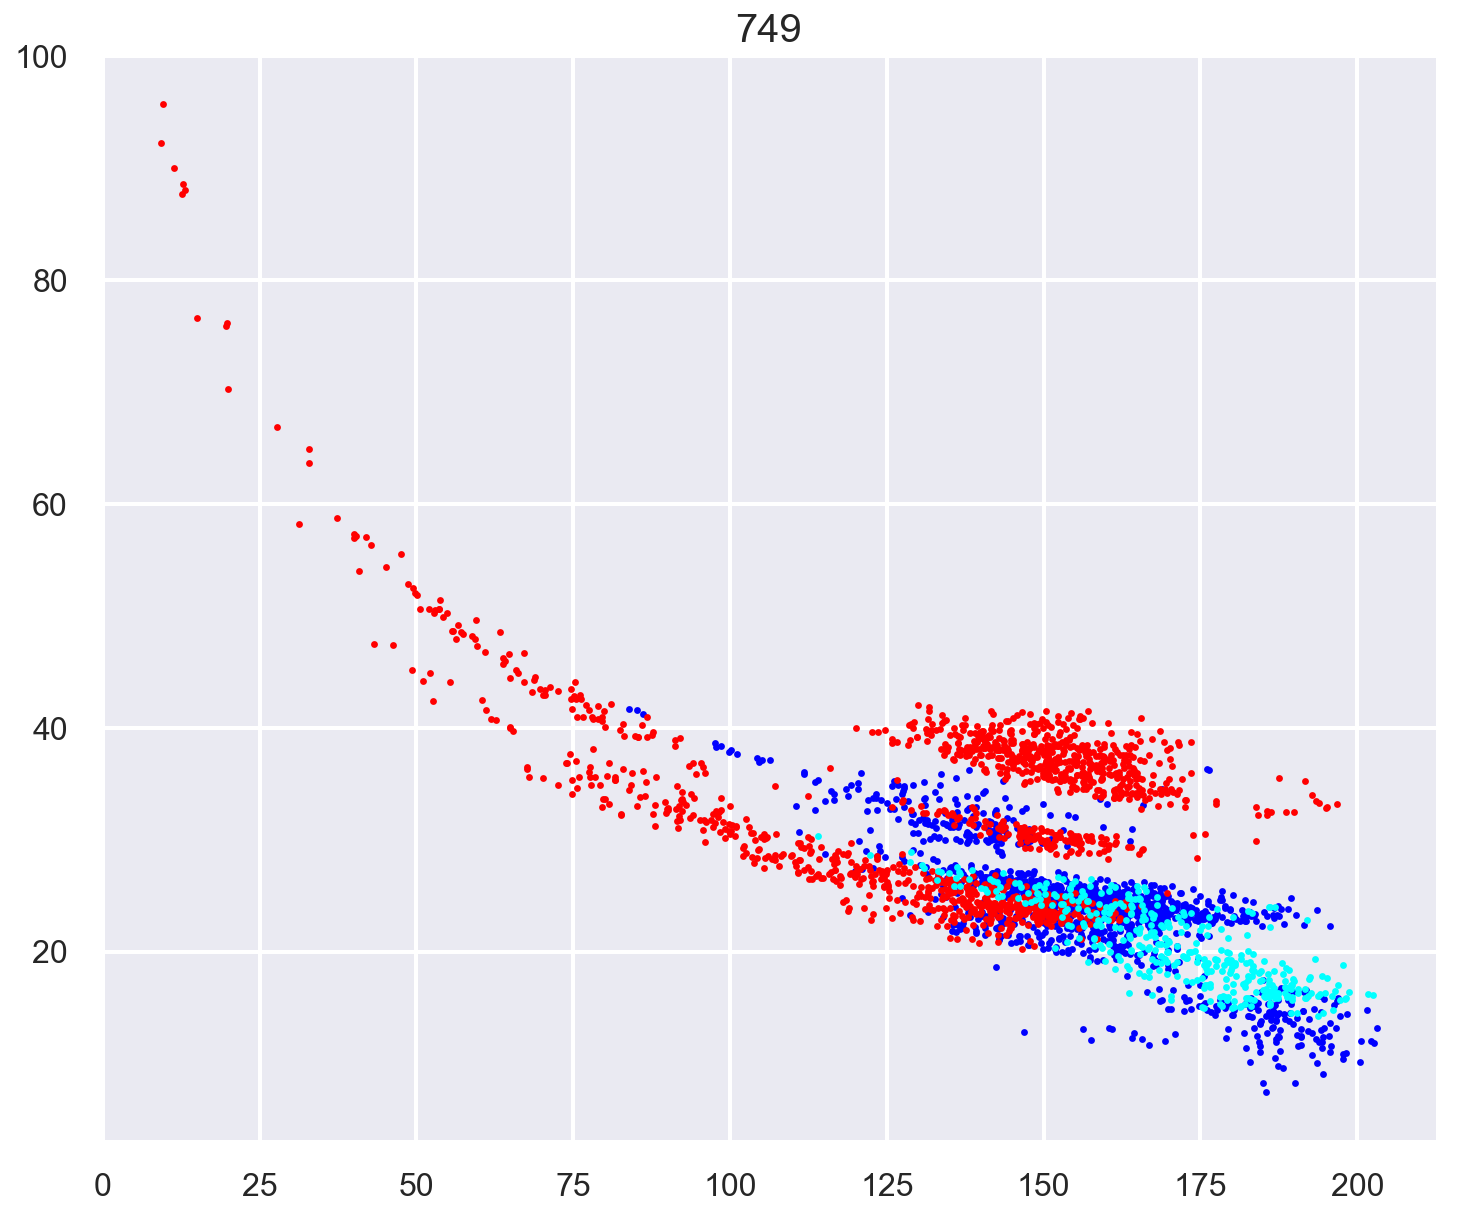

729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, 750,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (3015, 1024) (37, 1024)
Labels shape: (3015,) (37,)


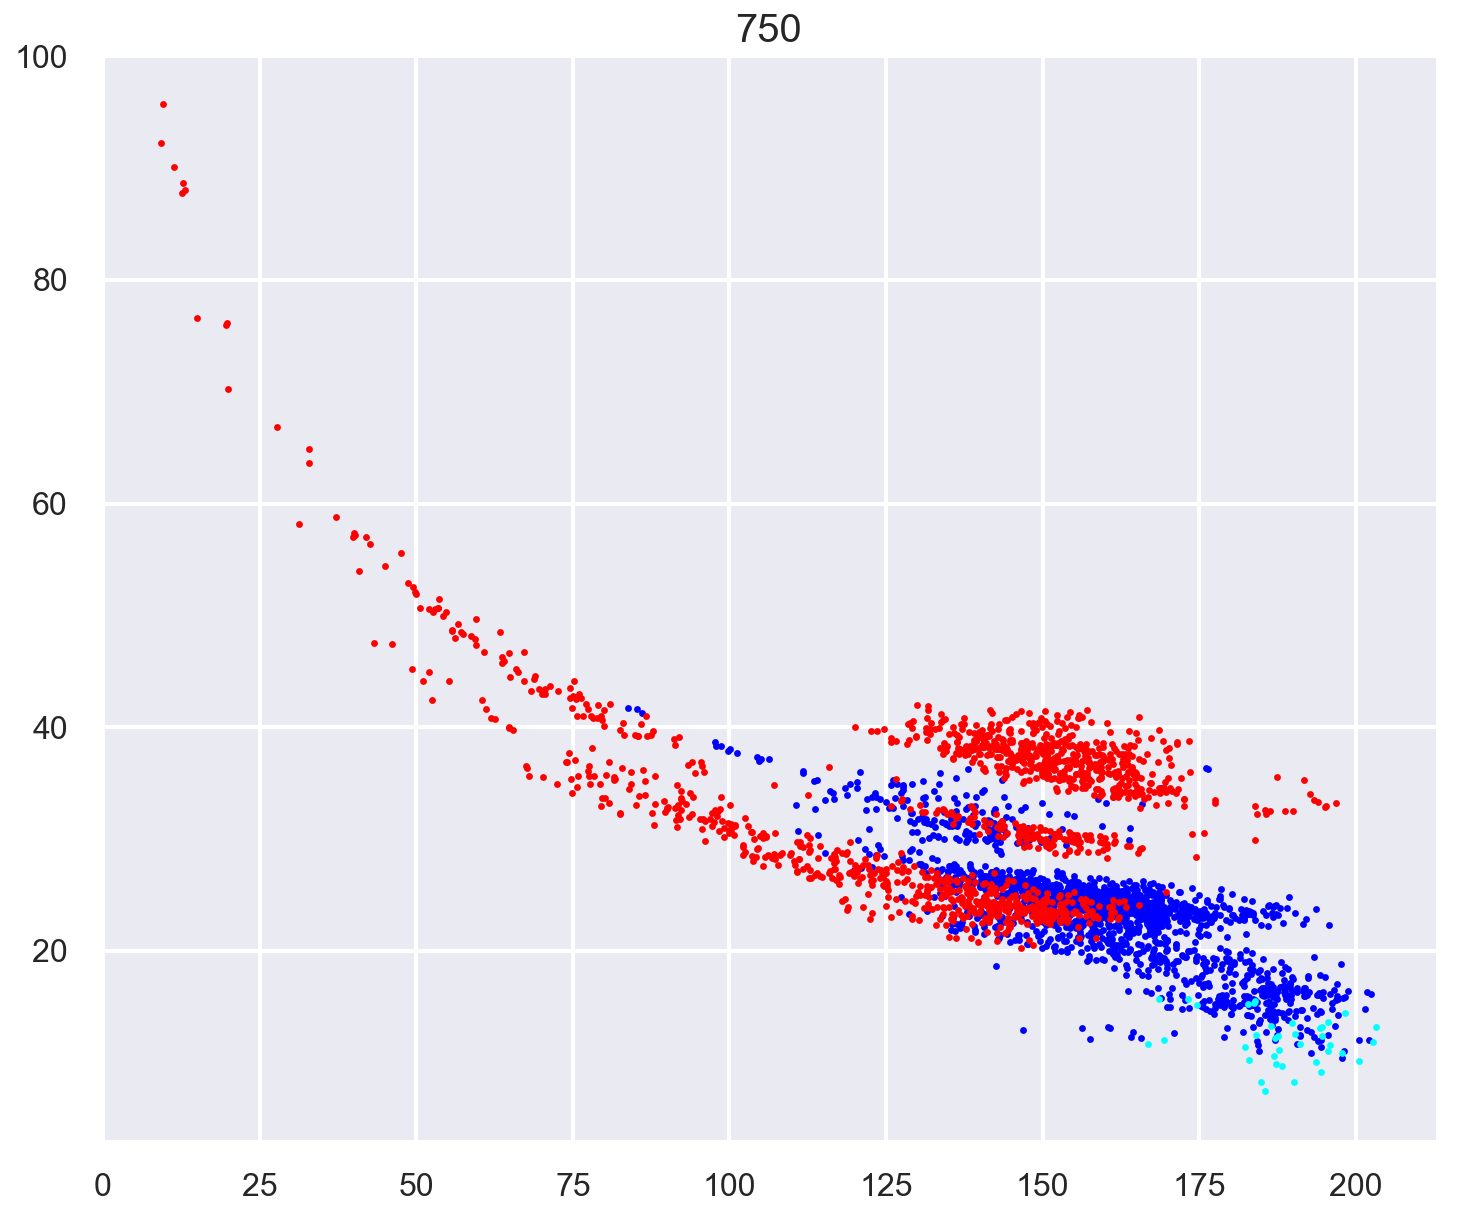

729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2805, 1024) (247, 1024)
Labels shape: (2805,) (247,)


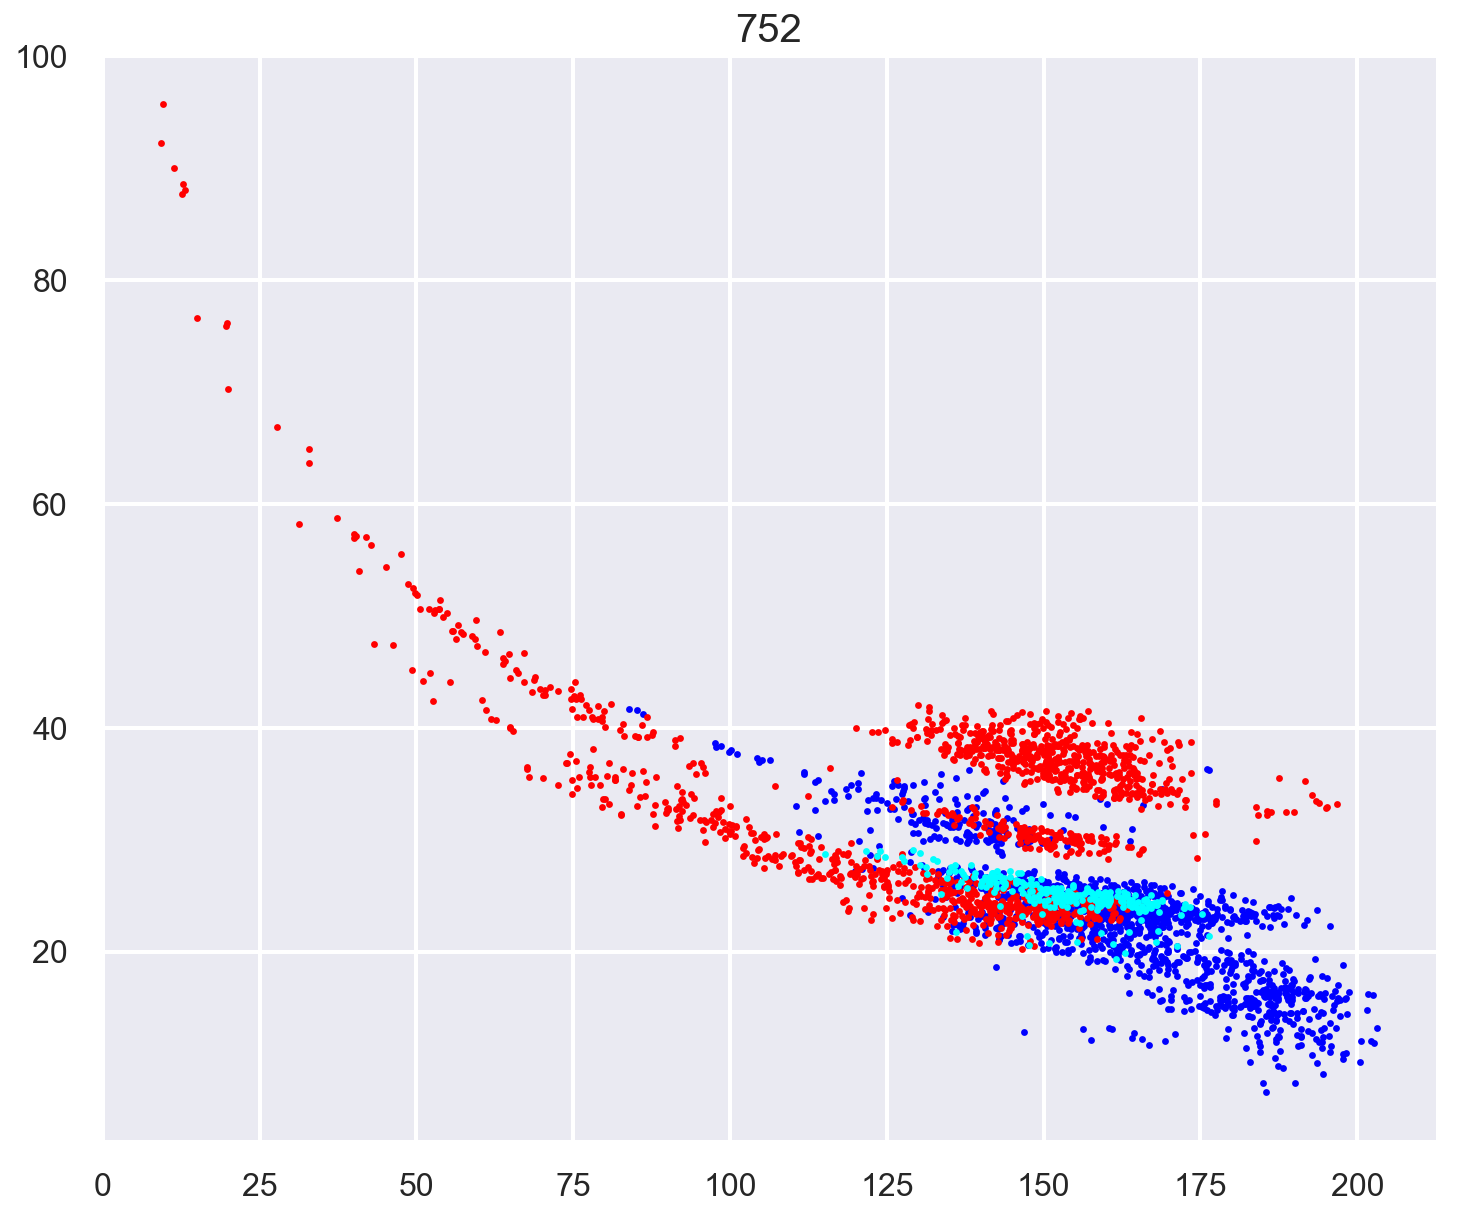

729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, 730,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2918, 1024) (134, 1024)
Labels shape: (2918,) (134,)


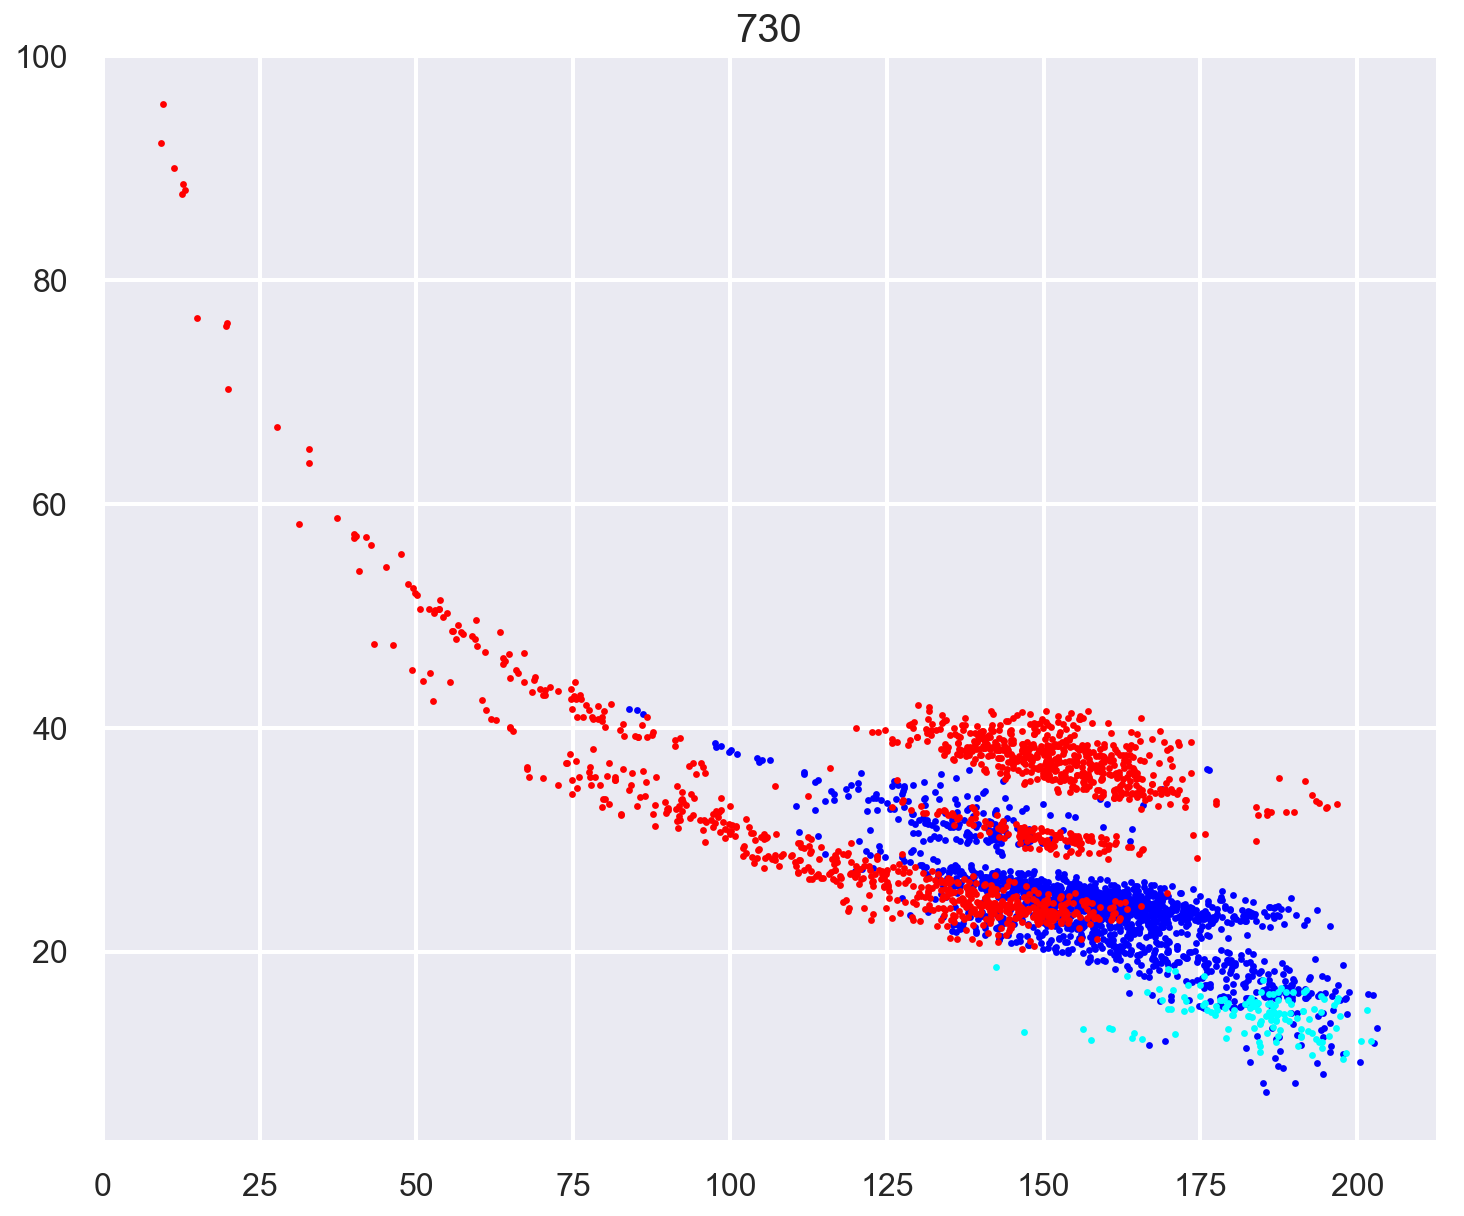

729,749,750,752,730,Skip,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, 739,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2353, 1024) (699, 1024)
Labels shape: (2353,) (699,)


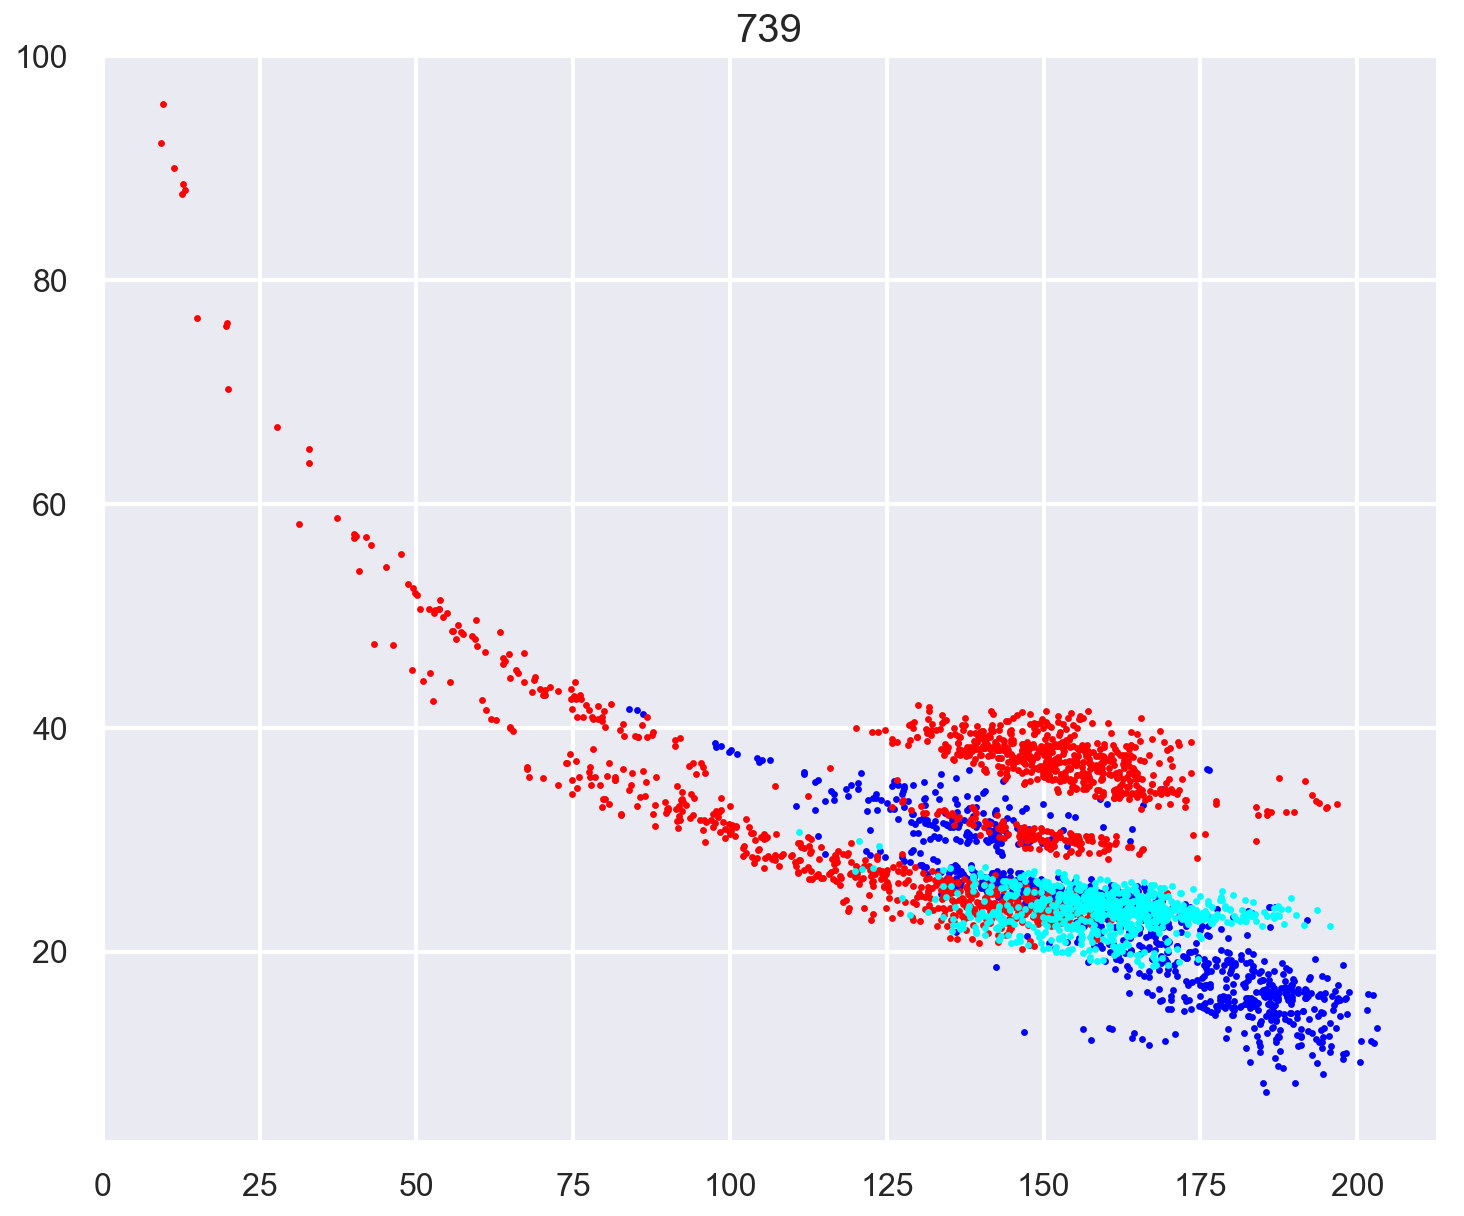

729,749,750,752,730,739,Skip,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, 751,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2986, 1024) (66, 1024)
Labels shape: (2986,) (66,)


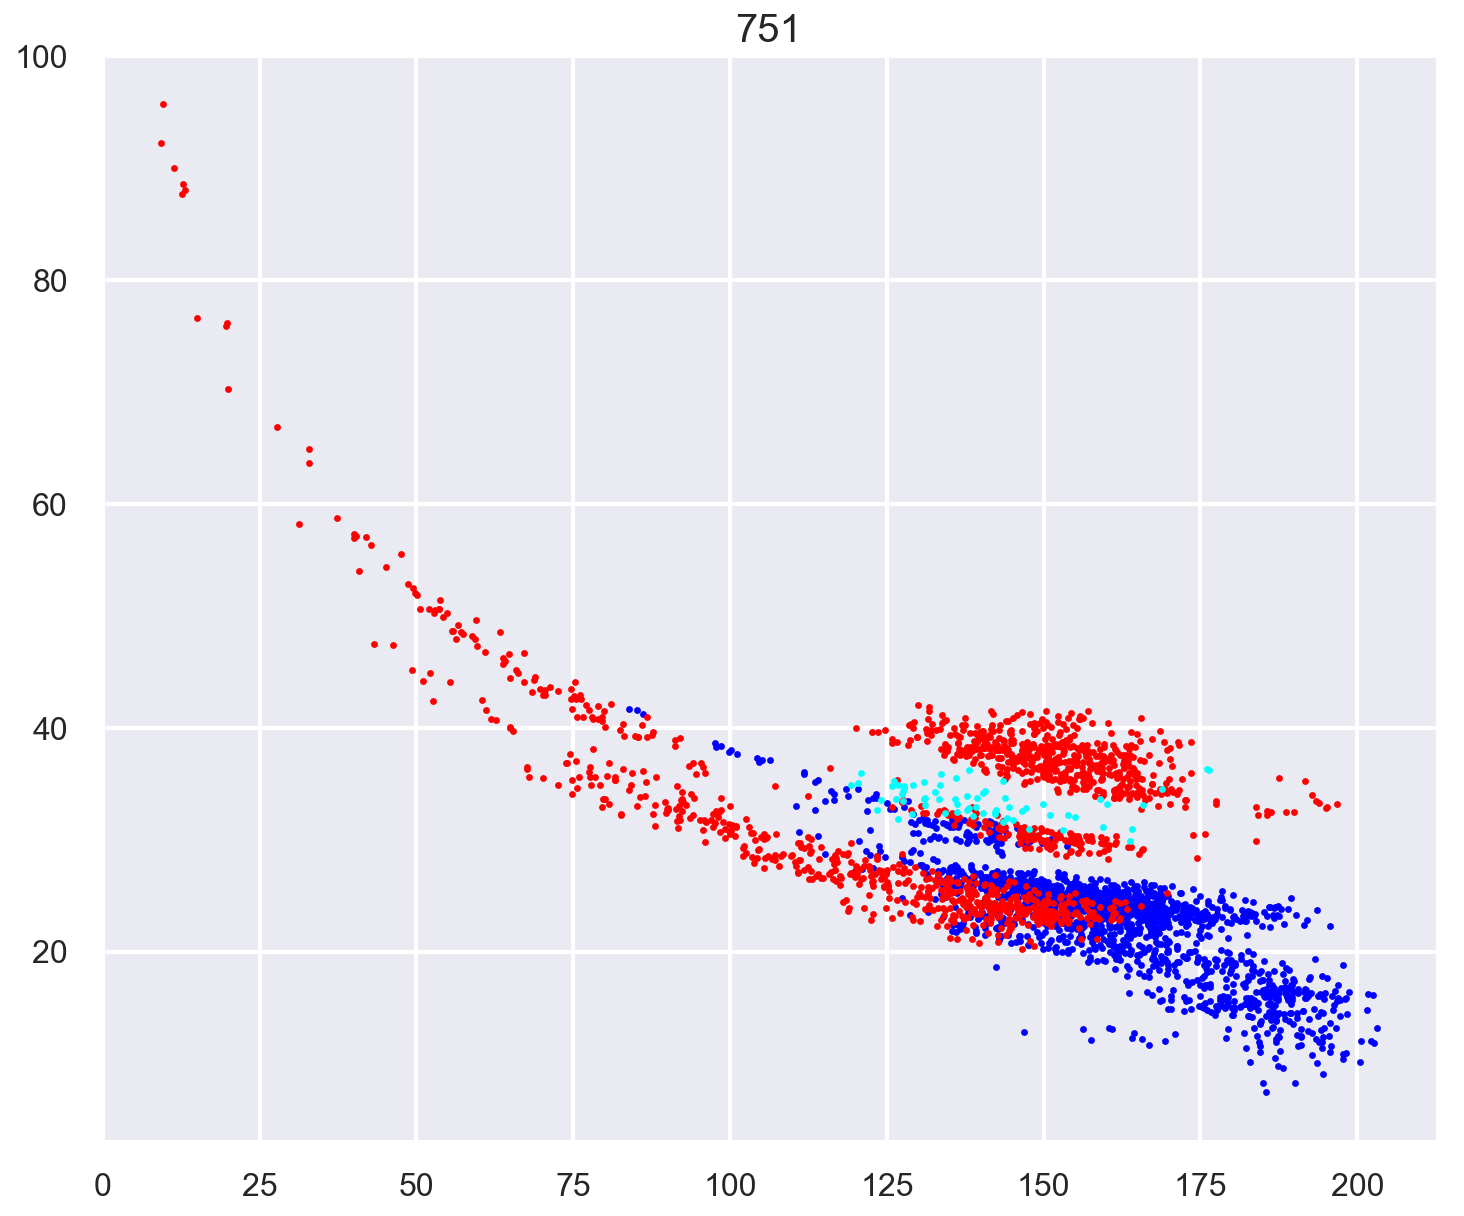

729,749,750,752,730,739,751,Skip,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 754,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2994, 1024) (58, 1024)
Labels shape: (2994,) (58,)


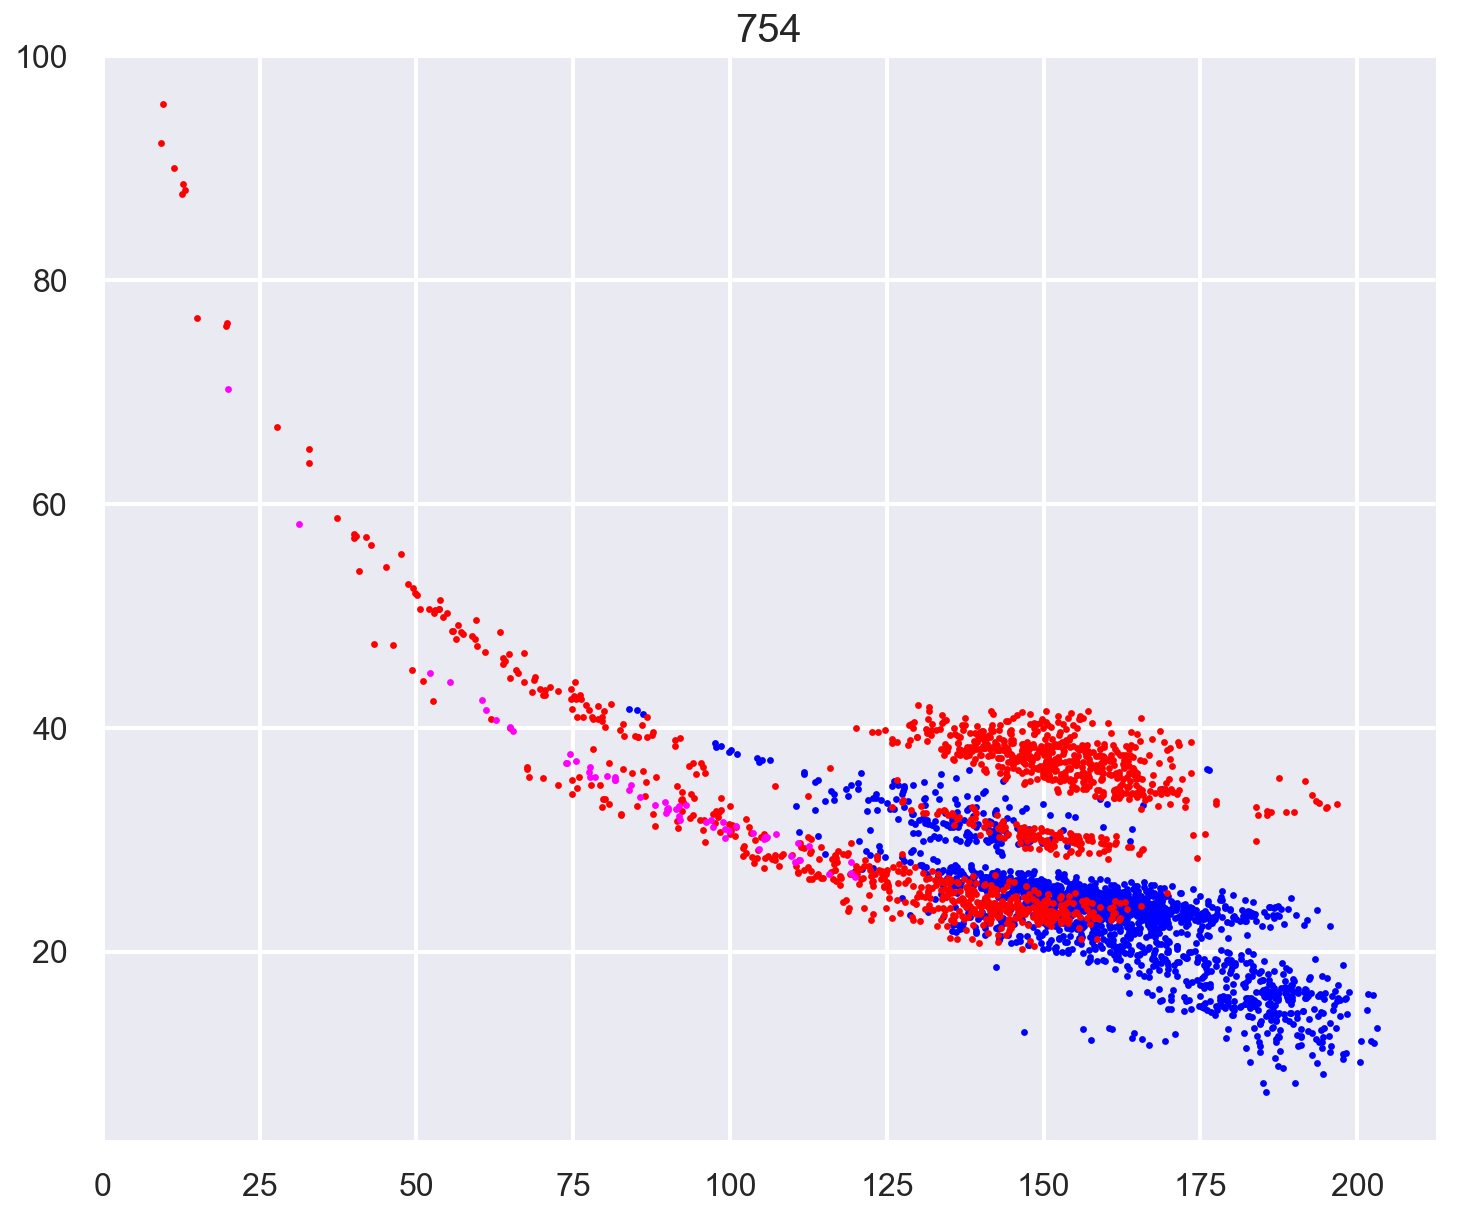

729,749,750,752,730,739,751,754,Skip,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 753,Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2882, 1024) (170, 1024)
Labels shape: (2882,) (170,)


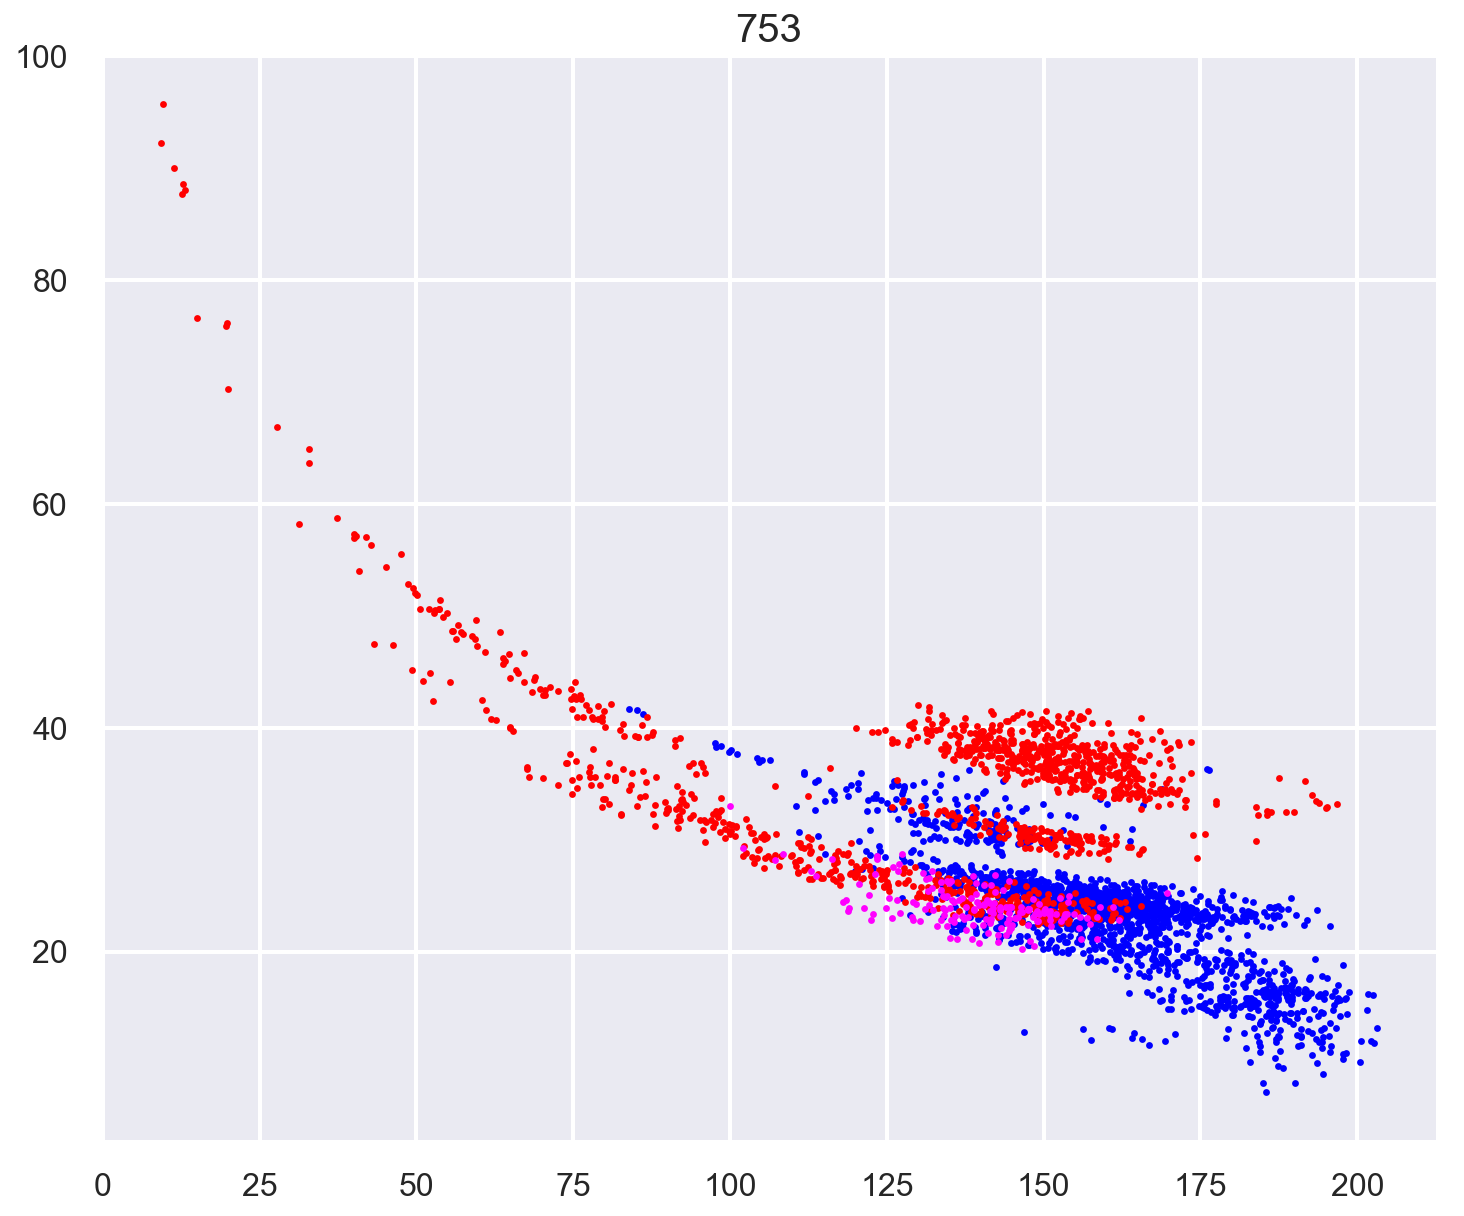

729,749,750,752,730,739,751,754,753,Skip,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 740,Skip, Skip, Skip, Skip, Skip, Training and testing shape (2965, 1024) (87, 1024)
Labels shape: (2965,) (87,)


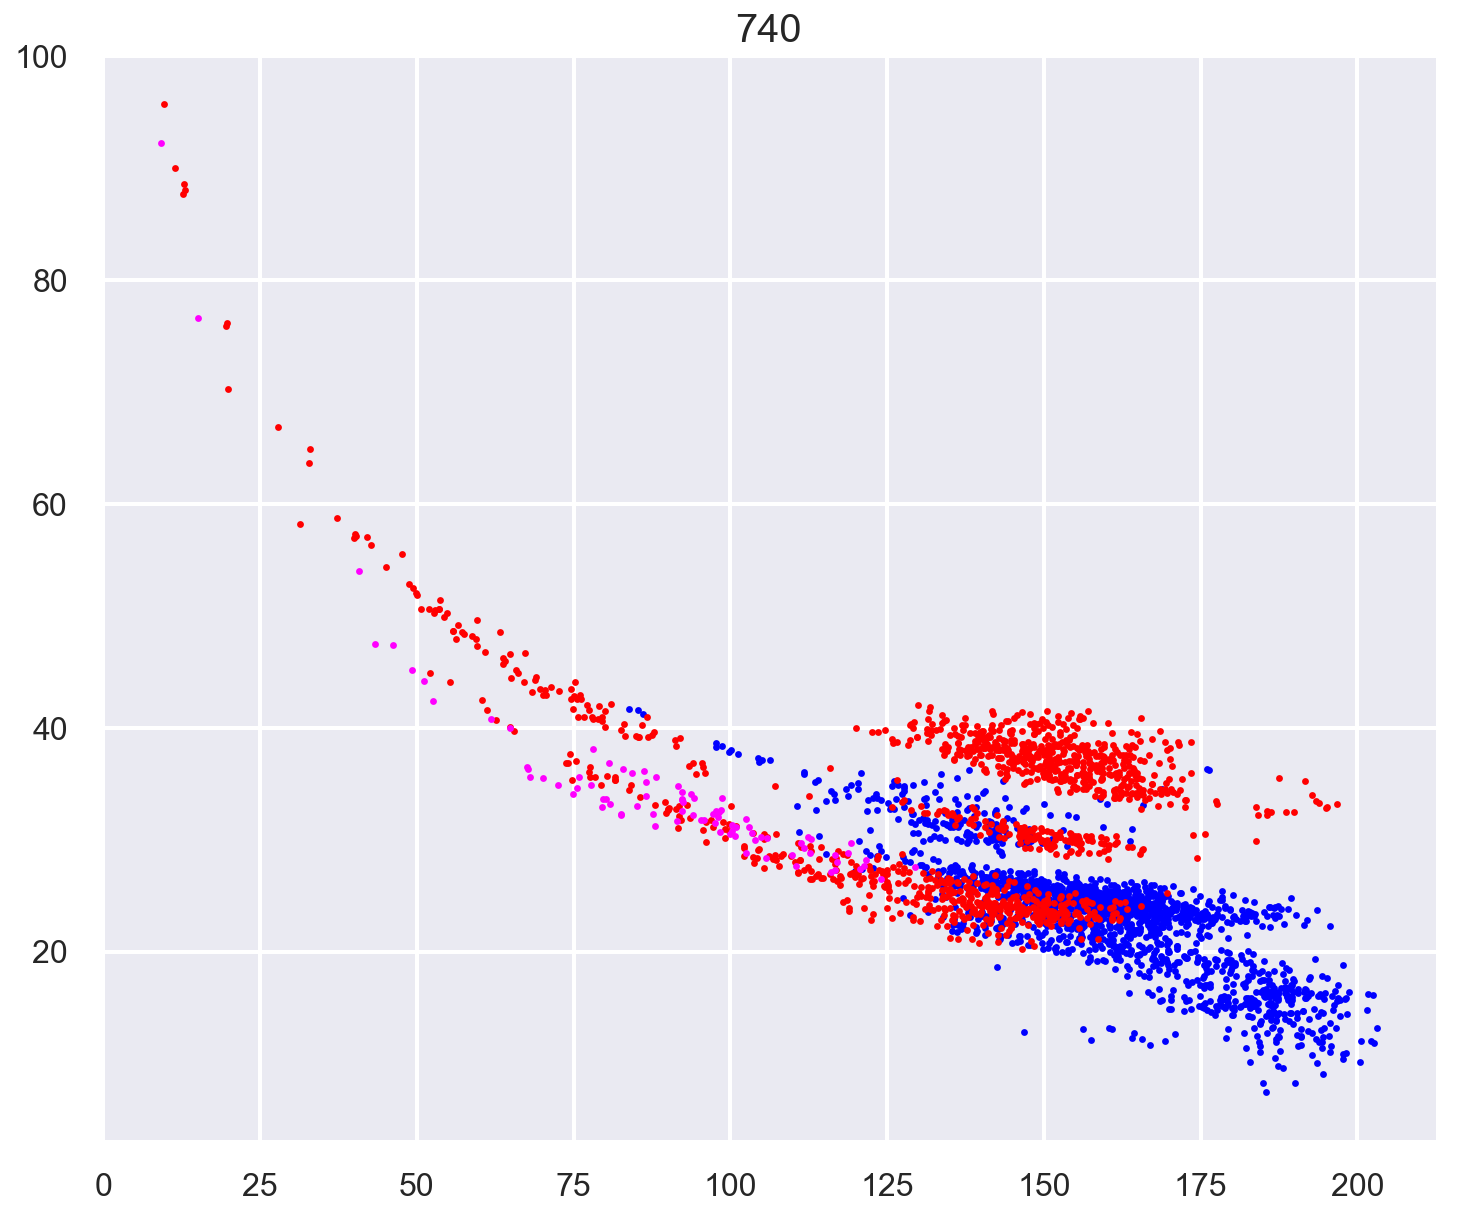

729,749,750,752,730,739,751,754,753,740,Skip,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 731,Skip, Skip, Skip, Skip, Training and testing shape (2914, 1024) (138, 1024)
Labels shape: (2914,) (138,)


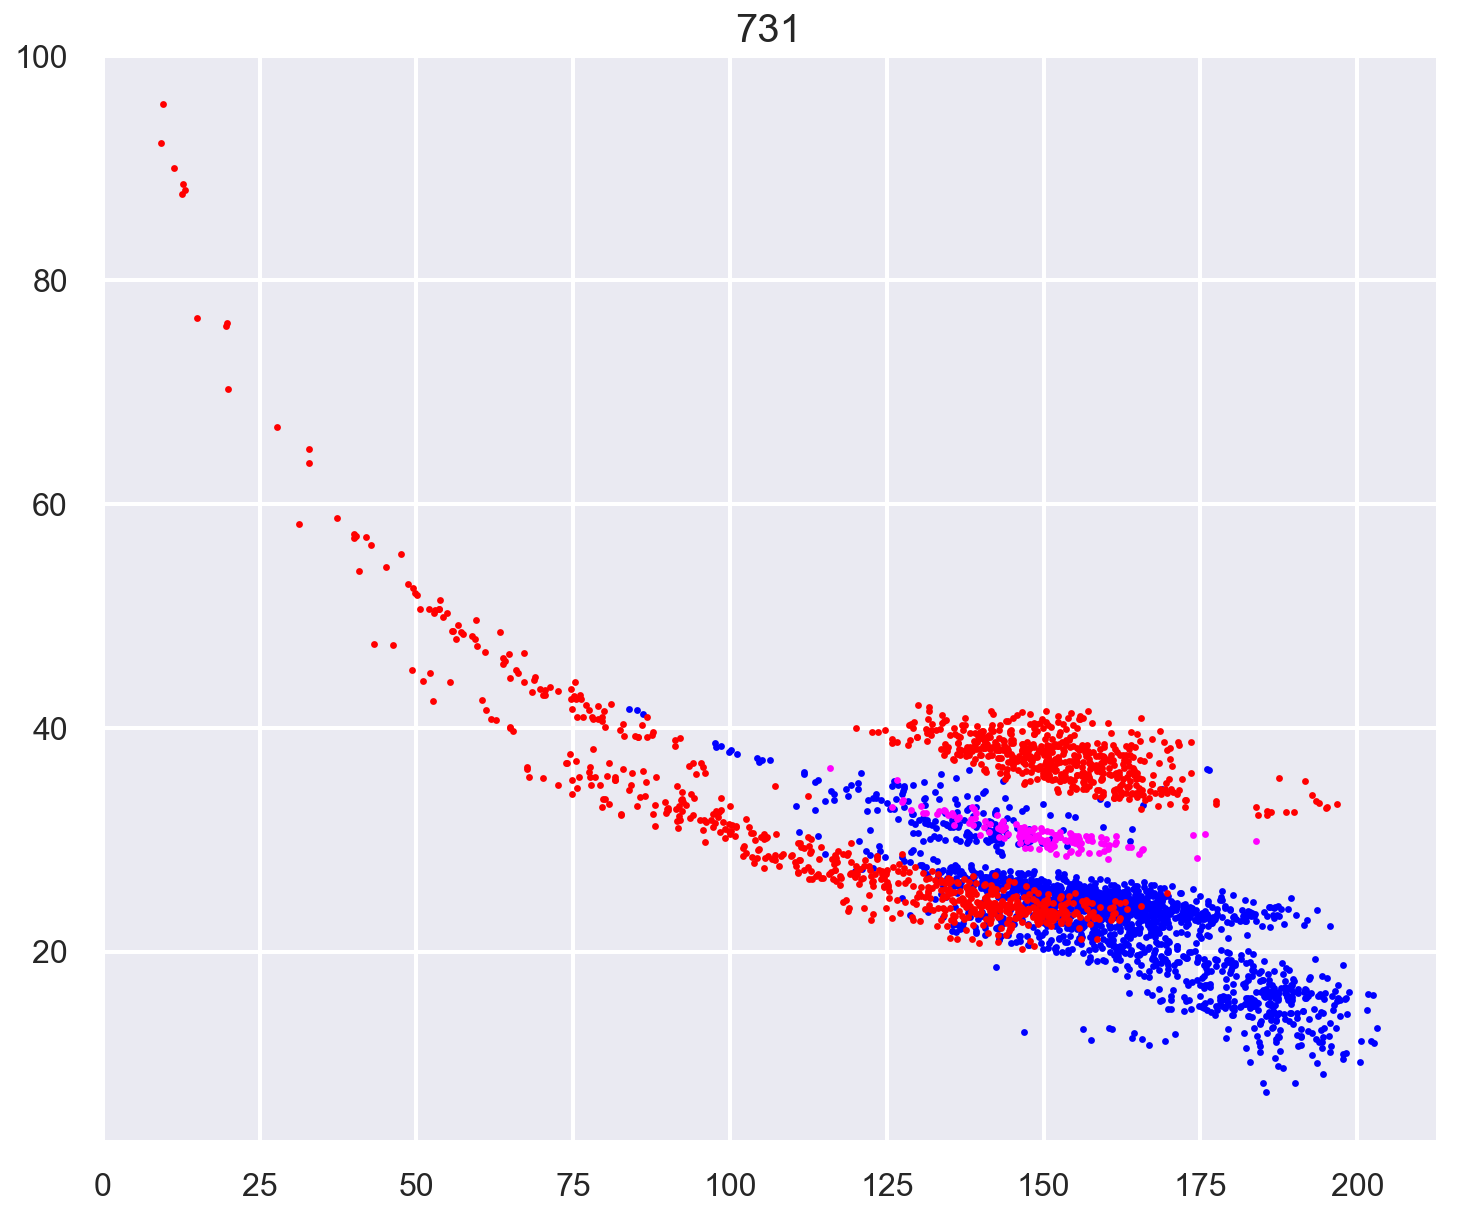

729,749,750,752,730,739,751,754,753,740,731,Skip,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 755,Skip, Skip, Skip, Training and testing shape (2846, 1024) (206, 1024)
Labels shape: (2846,) (206,)


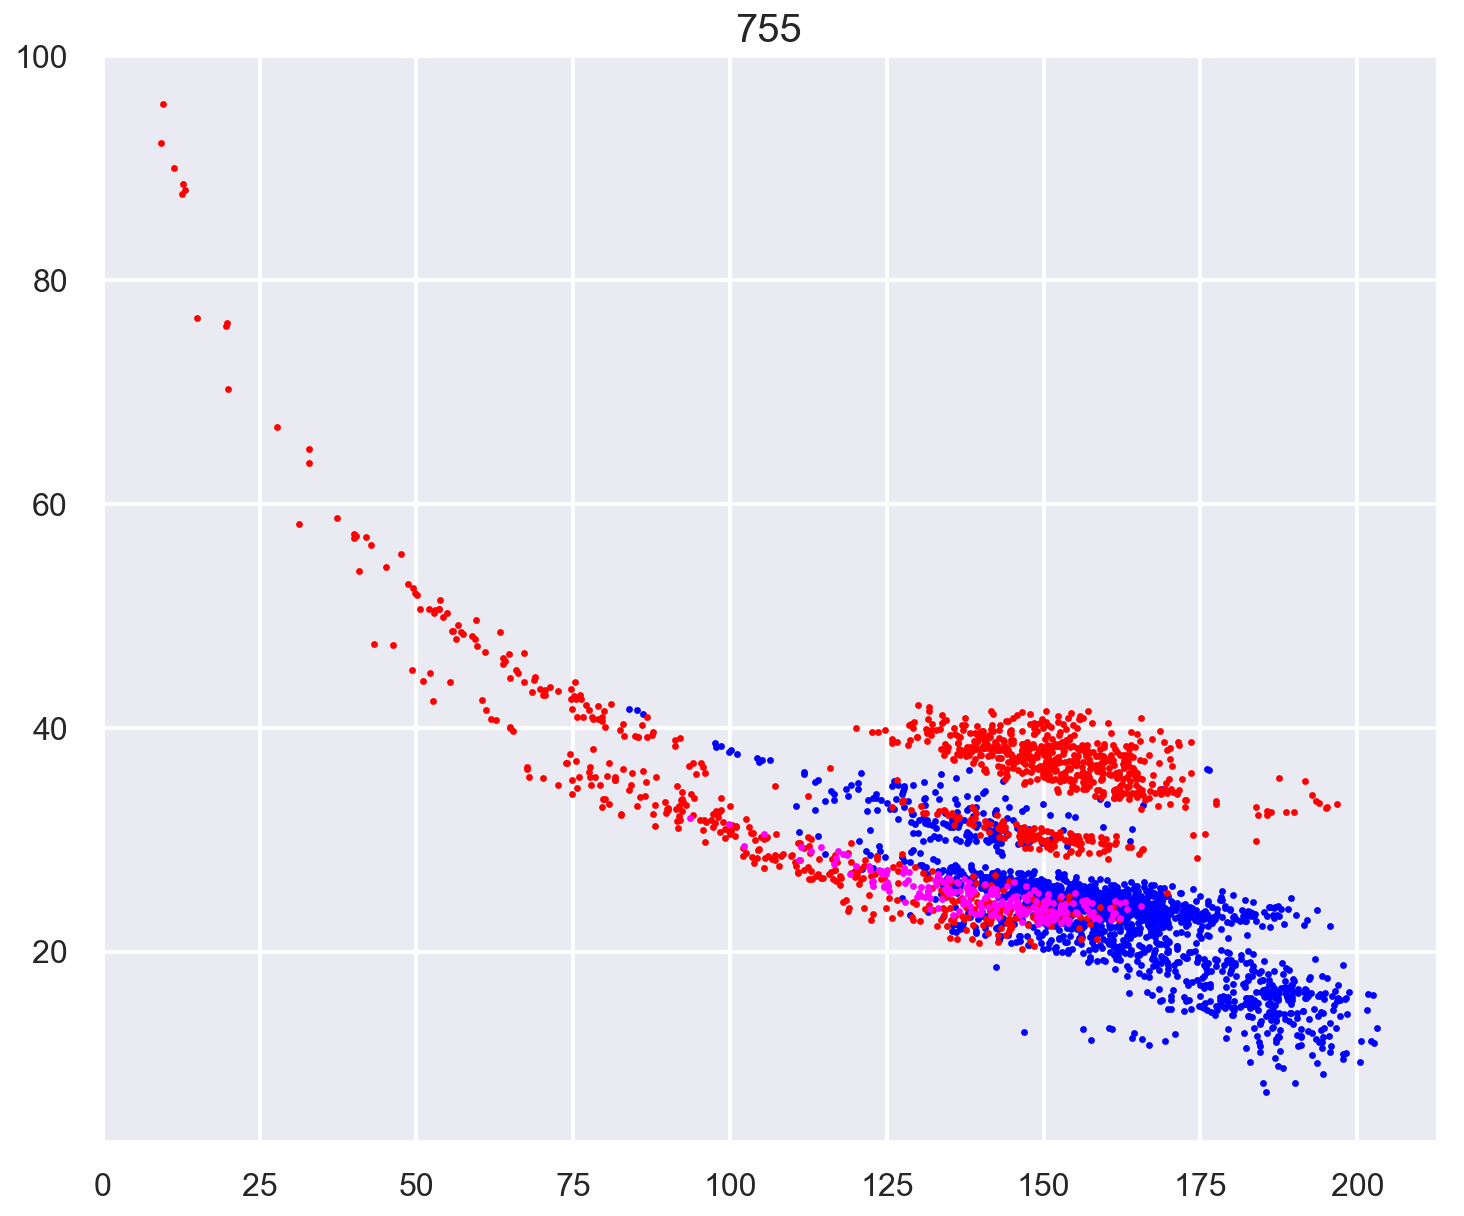

729,749,750,752,730,739,751,754,753,740,731,755,Skip,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 757,Skip, Skip, Training and testing shape (2948, 1024) (104, 1024)
Labels shape: (2948,) (104,)


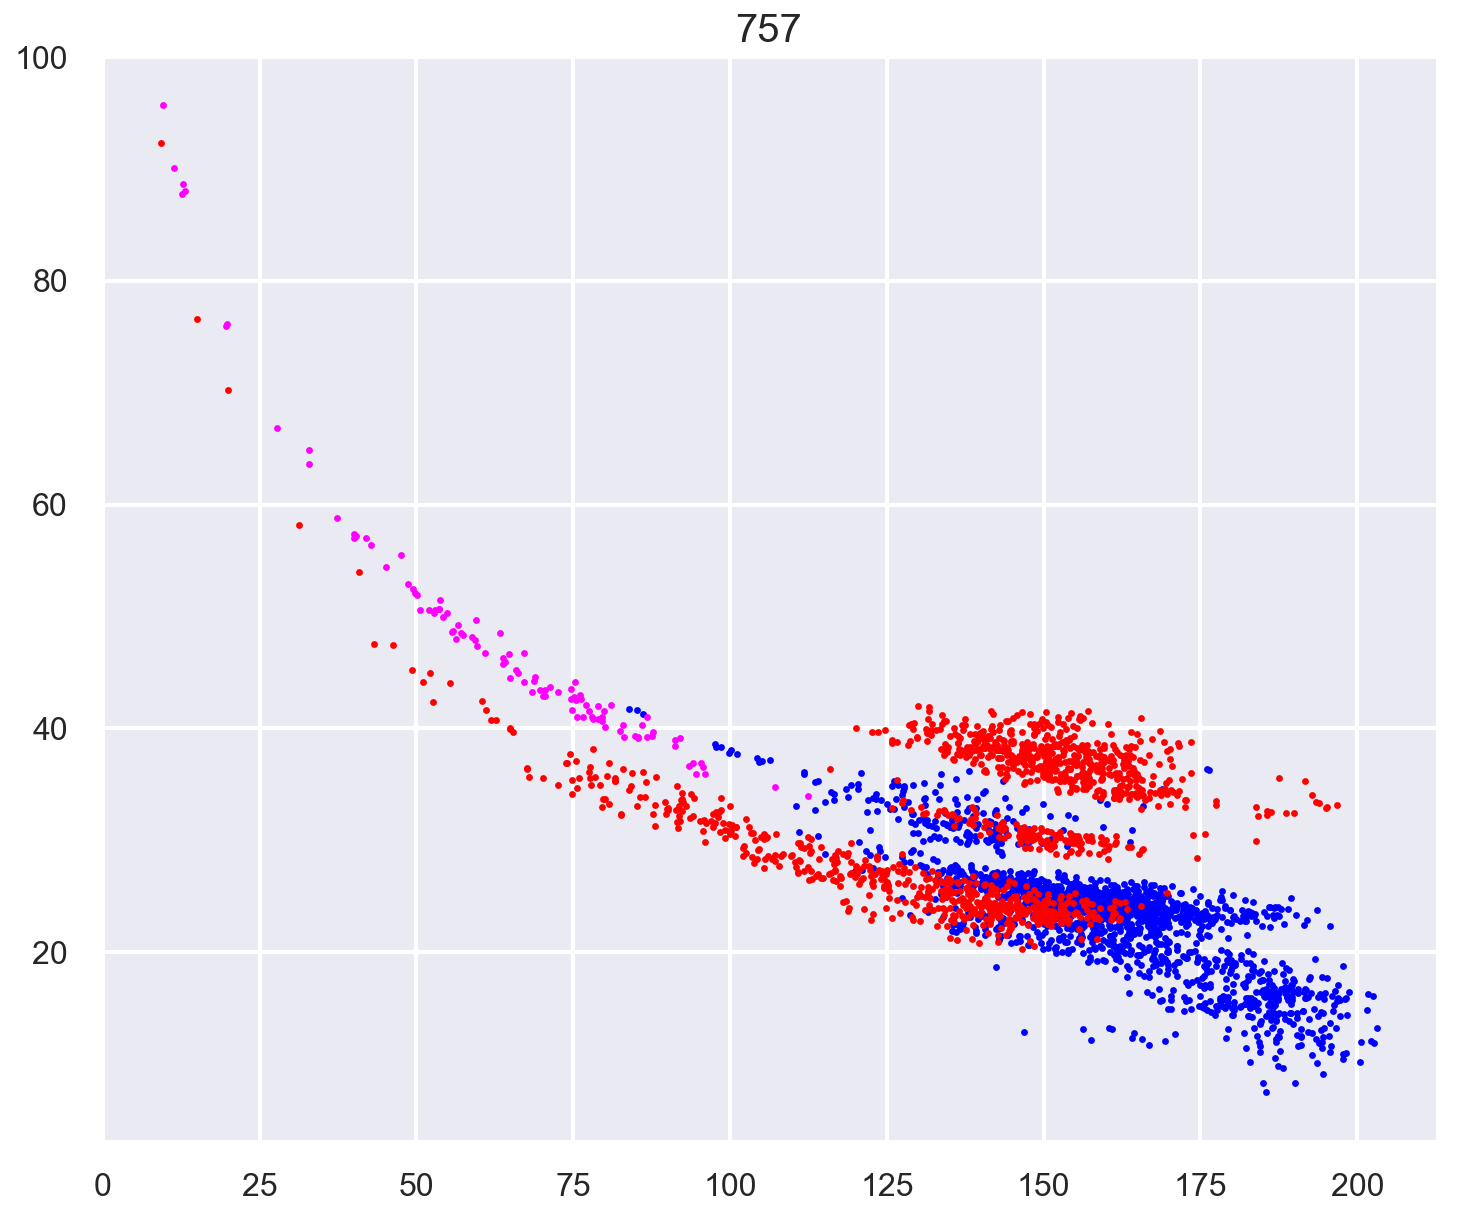

729,749,750,752,730,739,751,754,753,740,731,755,757,Skip,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 756,Skip, Training and testing shape (3011, 1024) (41, 1024)
Labels shape: (3011,) (41,)


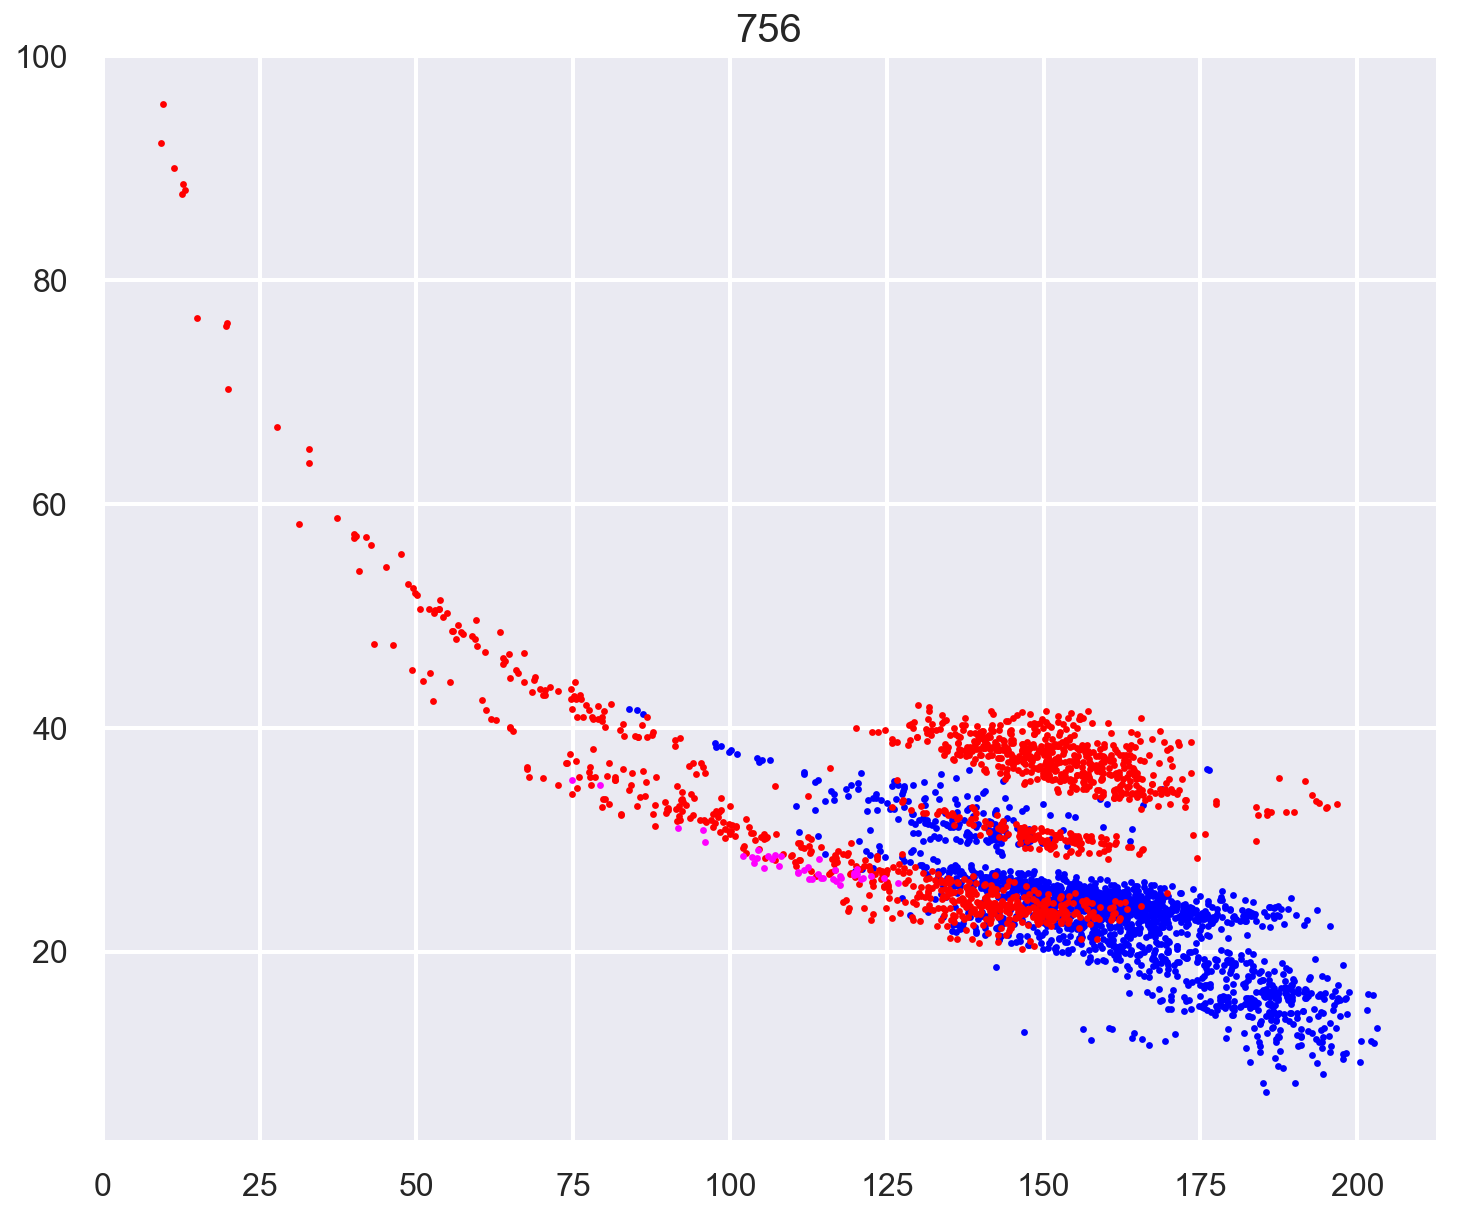

729,749,750,752,730,739,751,754,753,740,731,755,757,756,Skip,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 758,Training and testing shape (2502, 1024) (550, 1024)
Labels shape: (2502,) (550,)


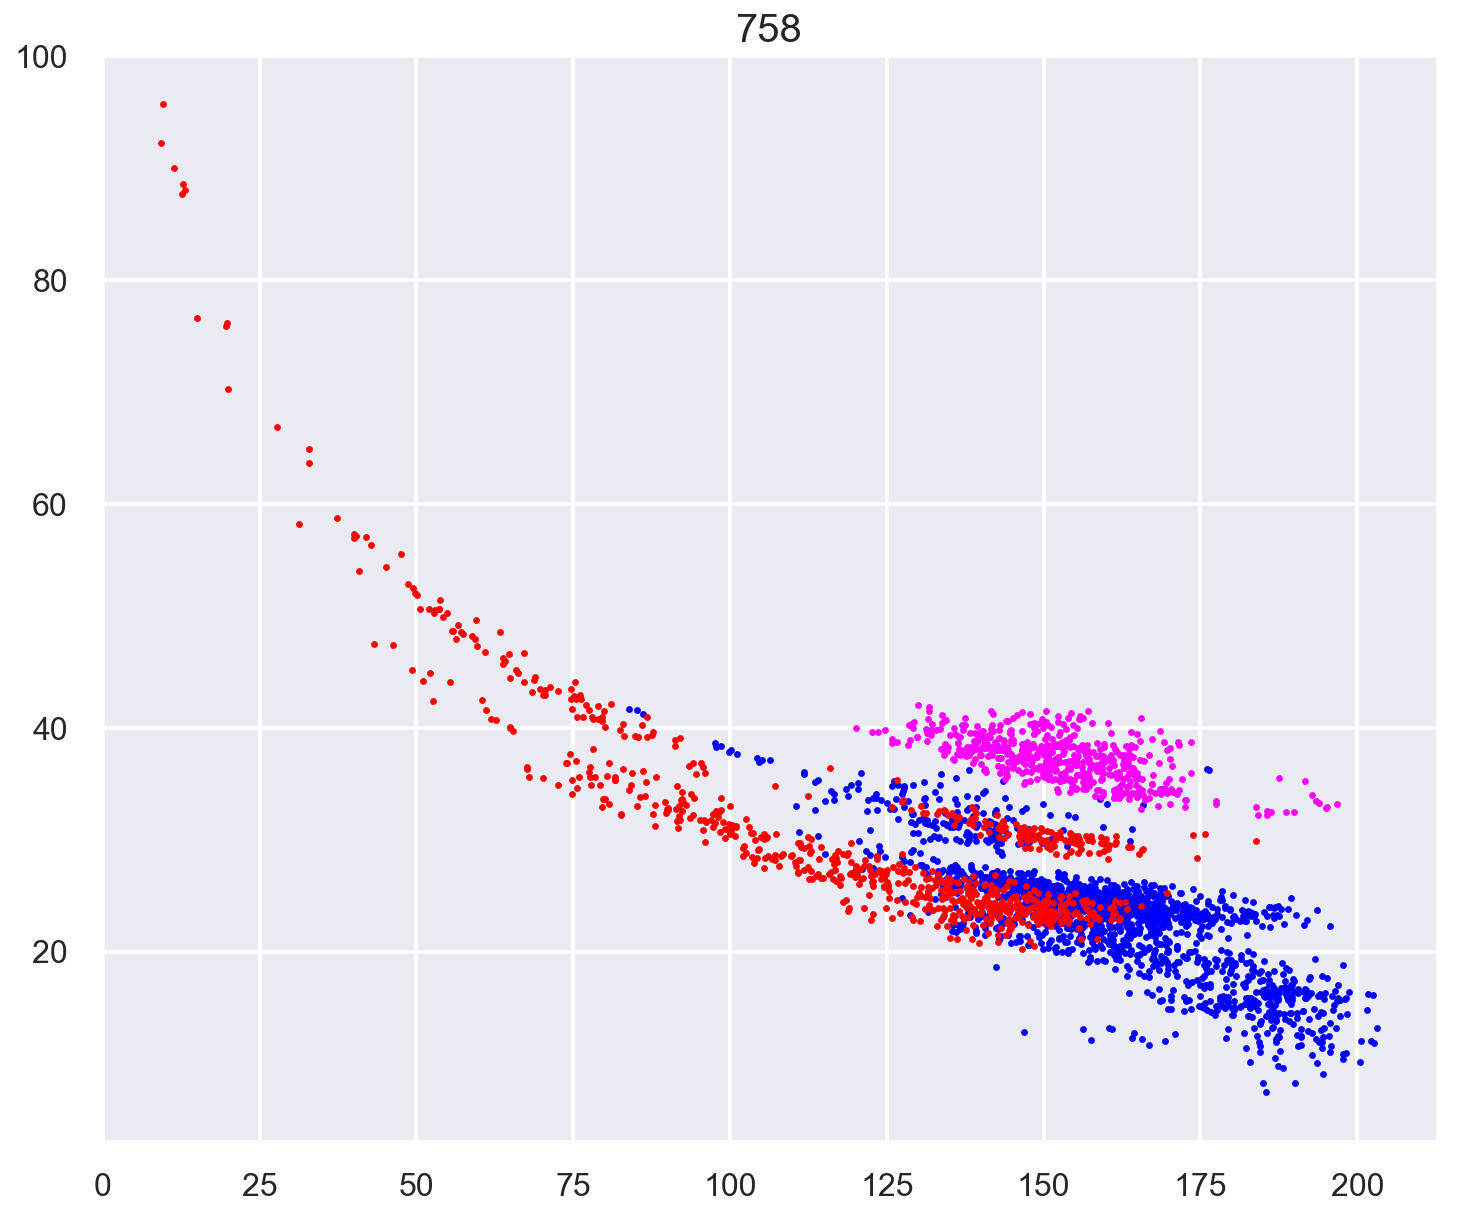

In [17]:
for i in range(15):   
    testing_idx = [all_idx[i]]
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict,True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict, True)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
                                                                          X_test, y_test)   
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)

    linear_train = ESD_EAC_features(freq, X_train)
    linear_test = ESD_EAC_features(freq, X_test) 
    
    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
    plt.figure(figsize = (12, 10))
    plt.scatter(linear_train[l1, 0], linear_train[l1, 1], c = 'b', s = 2)
    plt.scatter(linear_train[l2, 0], linear_train[l2, 1], c = 'r', s = 2)
    plt.scatter(linear_test[l3, 0], linear_test[l3, 1], c = 'cyan', s = 2)
    plt.scatter(linear_test[l4, 0], linear_test[l4, 1], c = 'fuchsia', s = 2)
    plt.title(str(testing_idx[0]))
    plt.show()
    #break

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

#tsne.fit(np.log10(X_train))
features_train  = tsne.fit_transform(np.log10(X_train))
features_test  = tsne.fit_transform(np.log10(X_test))
print(features_test.shape, features_train.shape)

clf = svm.SVC(C=10.0, kernel='rbf', gamma=0.1) #{'C': 10, 'gamma': 0.1}
clf.fit(features_train, y_train)

y_predict_pca = clf.predict(features_test)
y_train_predict_pca = clf.predict(features_train)

print('PCA ROI testing accuracy:', accuracy_score(y_test, y_predict_pca))
print('PCA ROI Training accuracy:', accuracy_score(y_train, y_train_predict_pca))

print(classification_report(y_test, y_predict_pca))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2914 samples in 0.136s...
[t-SNE] Computed neighbors for 2914 samples in 7.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2914
[t-SNE] Computed conditional probabilities for sample 2000 / 2914
[t-SNE] Computed conditional probabilities for sample 2914 / 2914
[t-SNE] Mean sigma: 2.157094
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.900894
[t-SNE] Error after 300 iterations: 1.510661
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 2.610893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.439308
[t-SNE] Error after 300 iterations: 0.639807
(138, 2) (2914, 2)
PCA ROI testing accuracy: 0.304347826087
PCA ROI Training accuracy: 0.945435827042
             precision    recall  f1-score   suppo

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Regression using PCA and random forest. 

[729]
Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2939, 1024) (125, 1024) (2939, 1024)
Labels shape: (2939,) (125,)
(125, 2) (2939, 2)


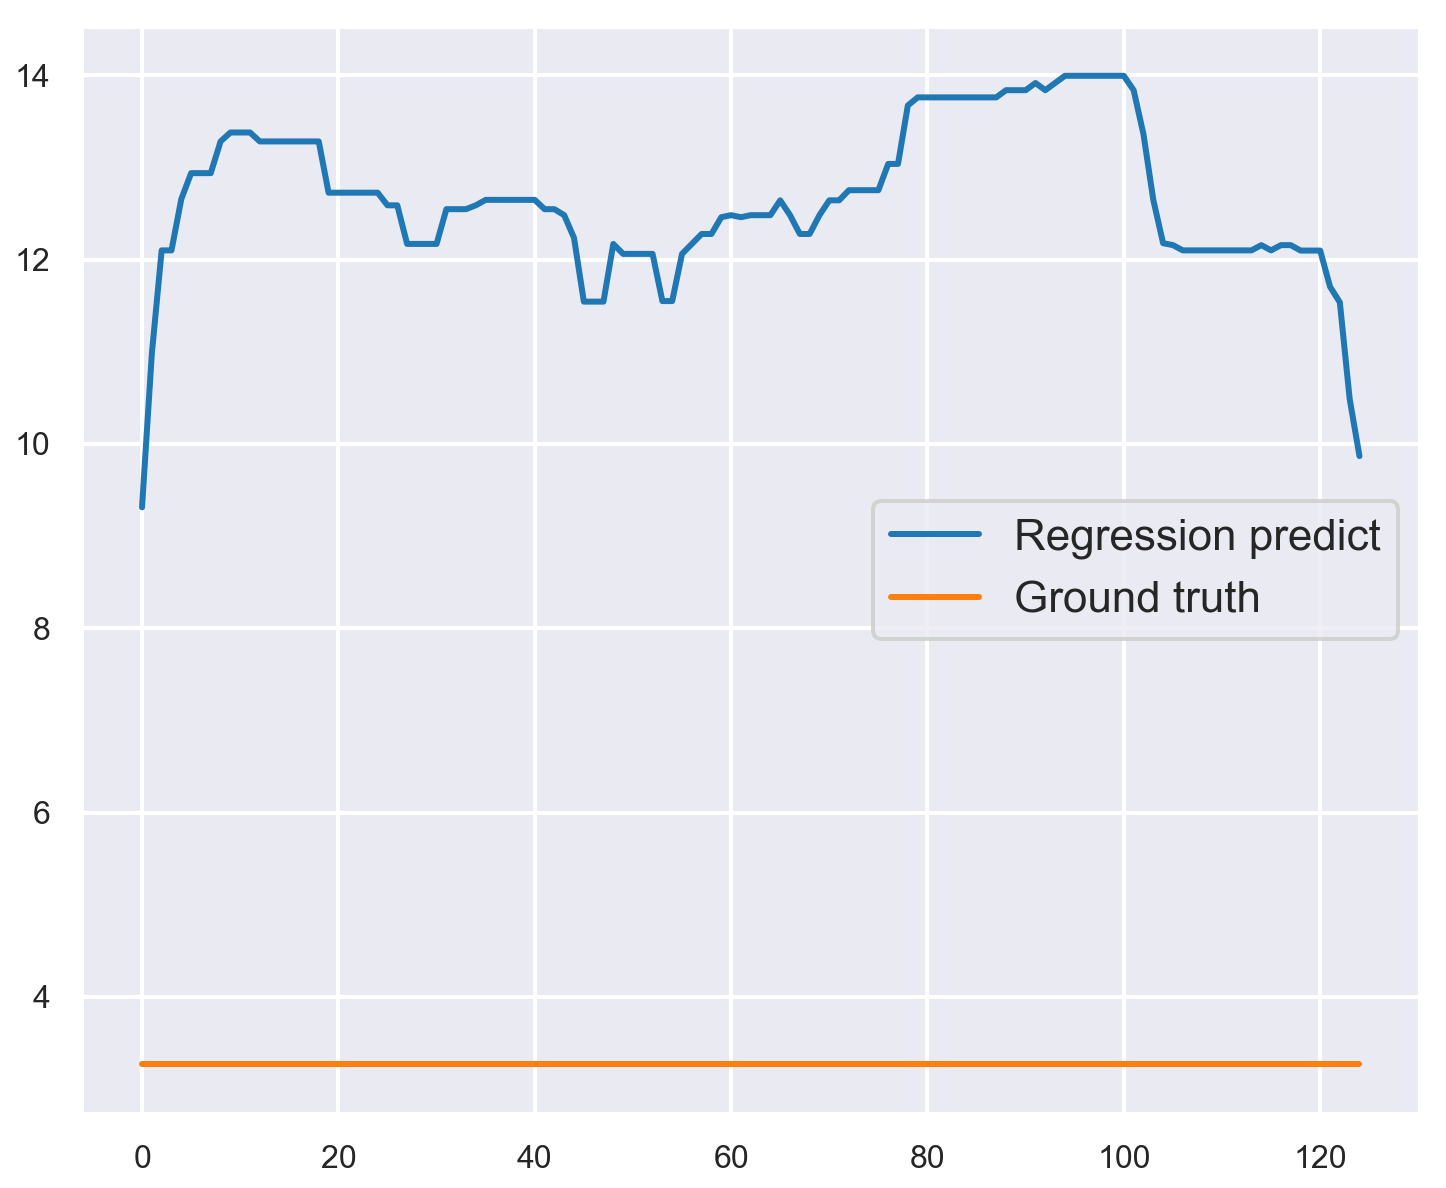

[749]
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip, 749,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2671, 1024) (393, 1024) (2671, 1024)
Labels shape: (2671,) (393,)
(393, 2) (2671, 2)


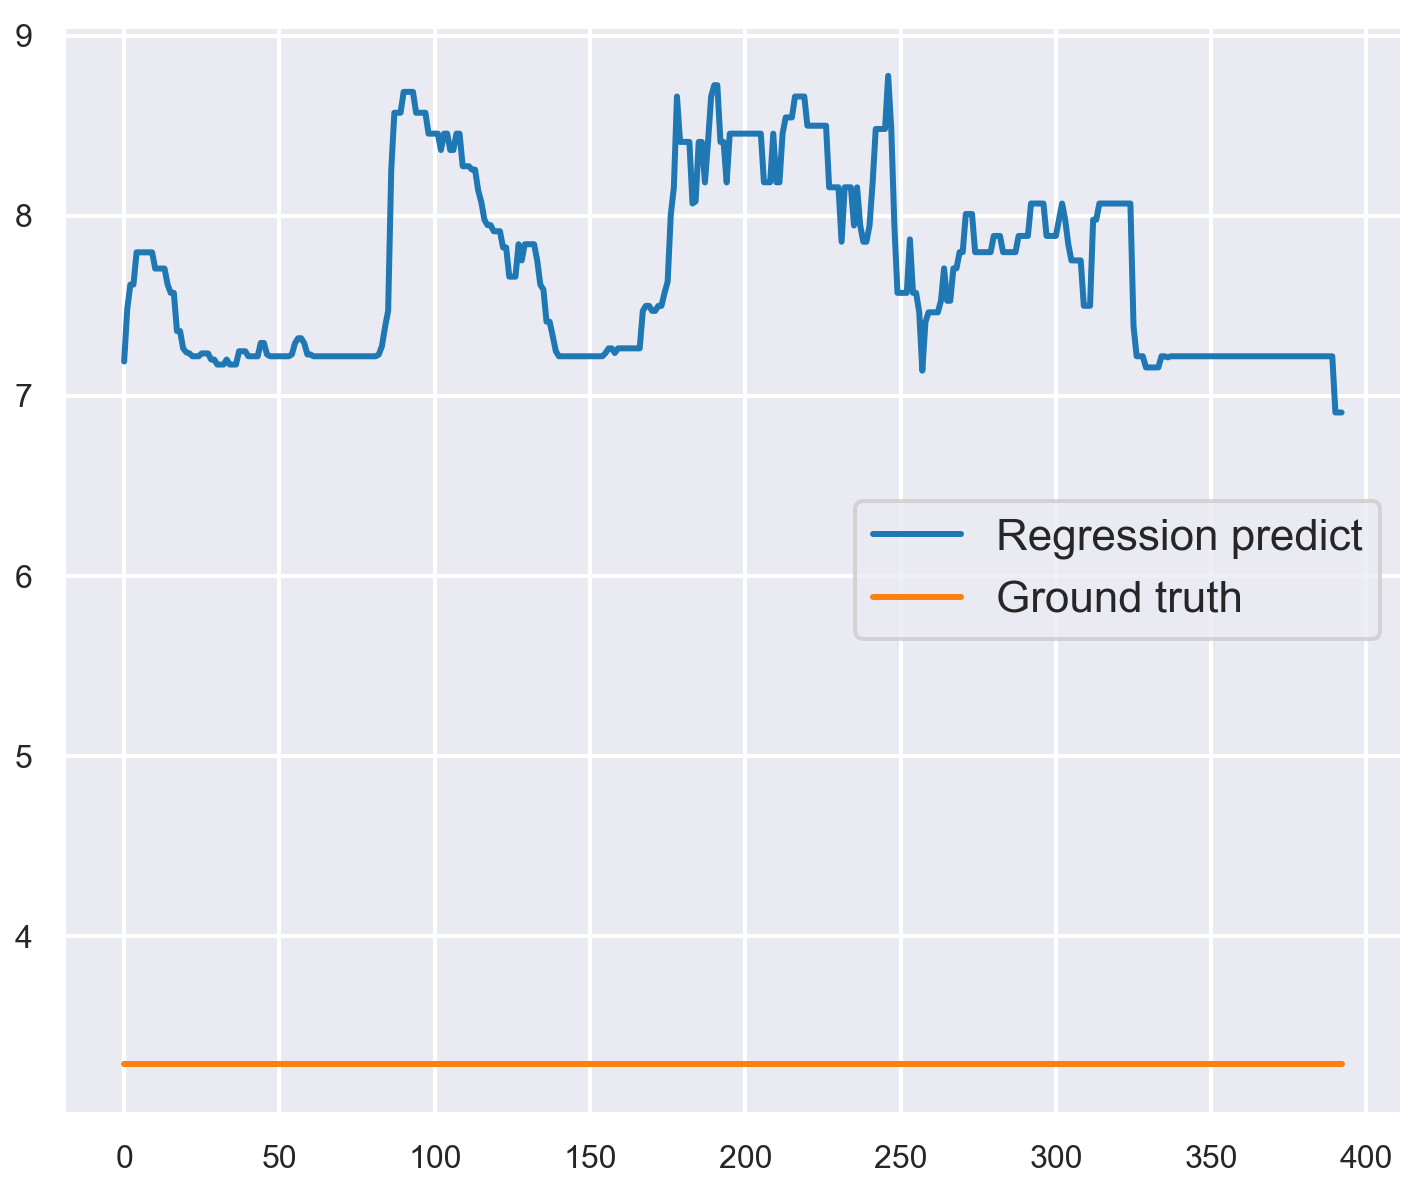

[750]
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, 750,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (3027, 1024) (37, 1024) (3027, 1024)
Labels shape: (3027,) (37,)
(37, 2) (3027, 2)


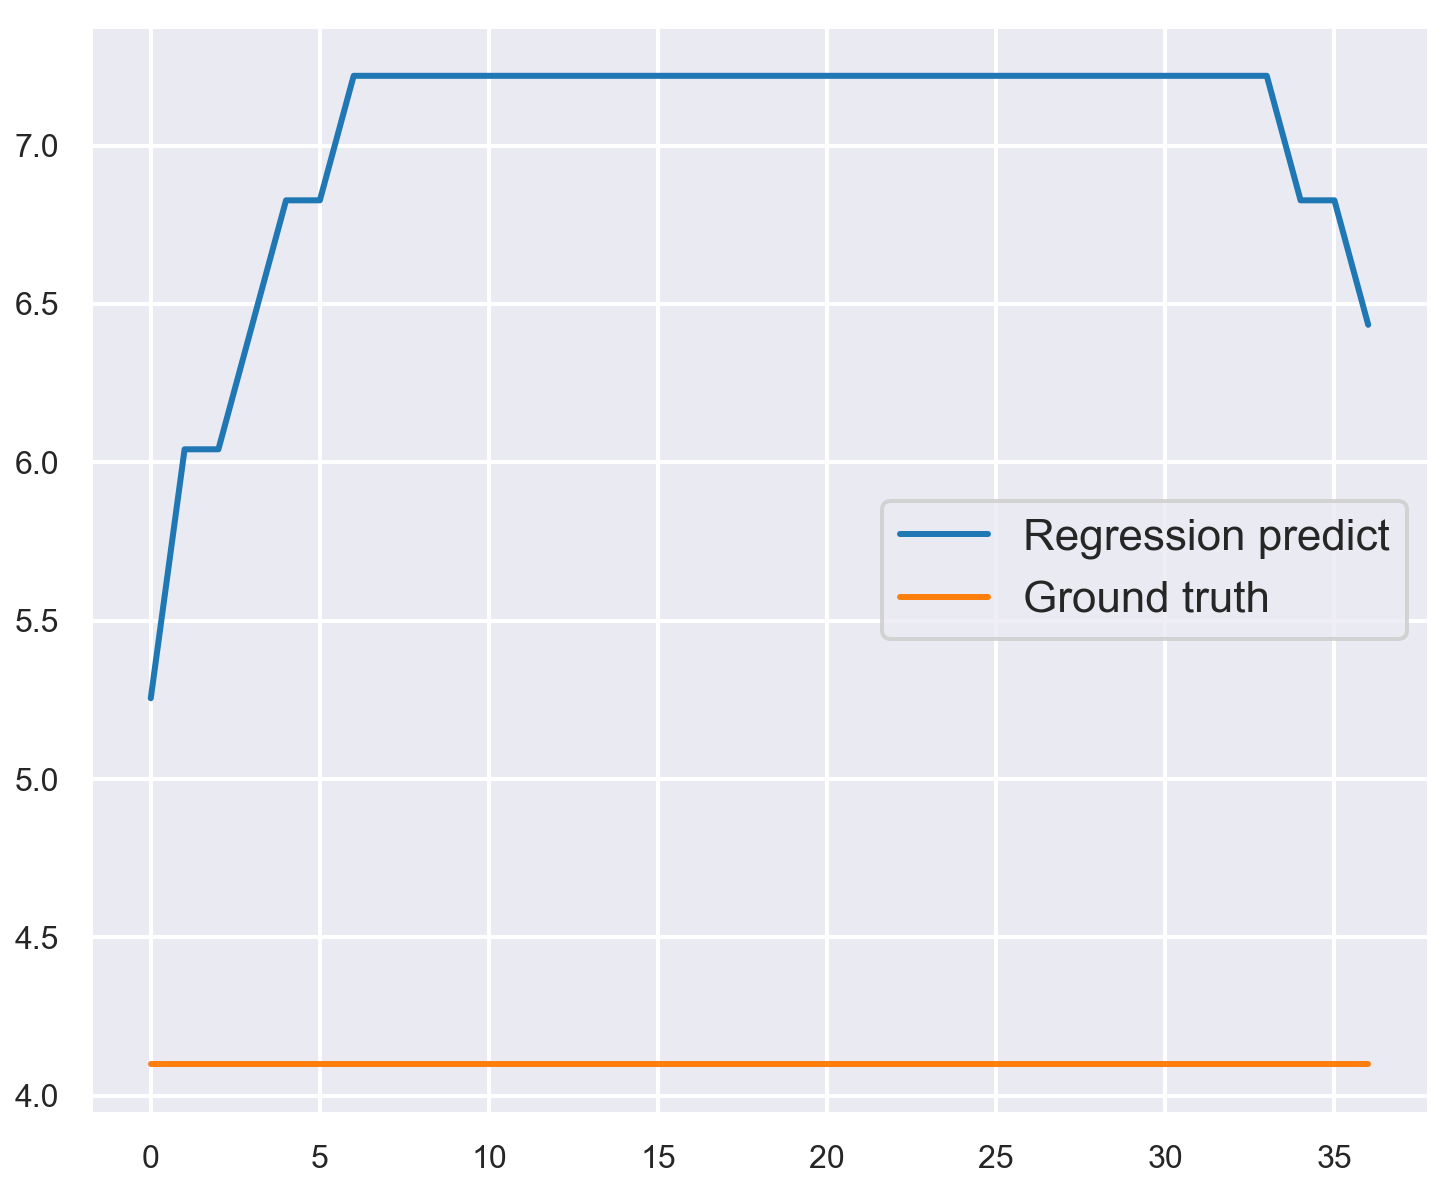

[752]
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, 752,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2817, 1024) (247, 1024) (2817, 1024)
Labels shape: (2817,) (247,)
(247, 2) (2817, 2)


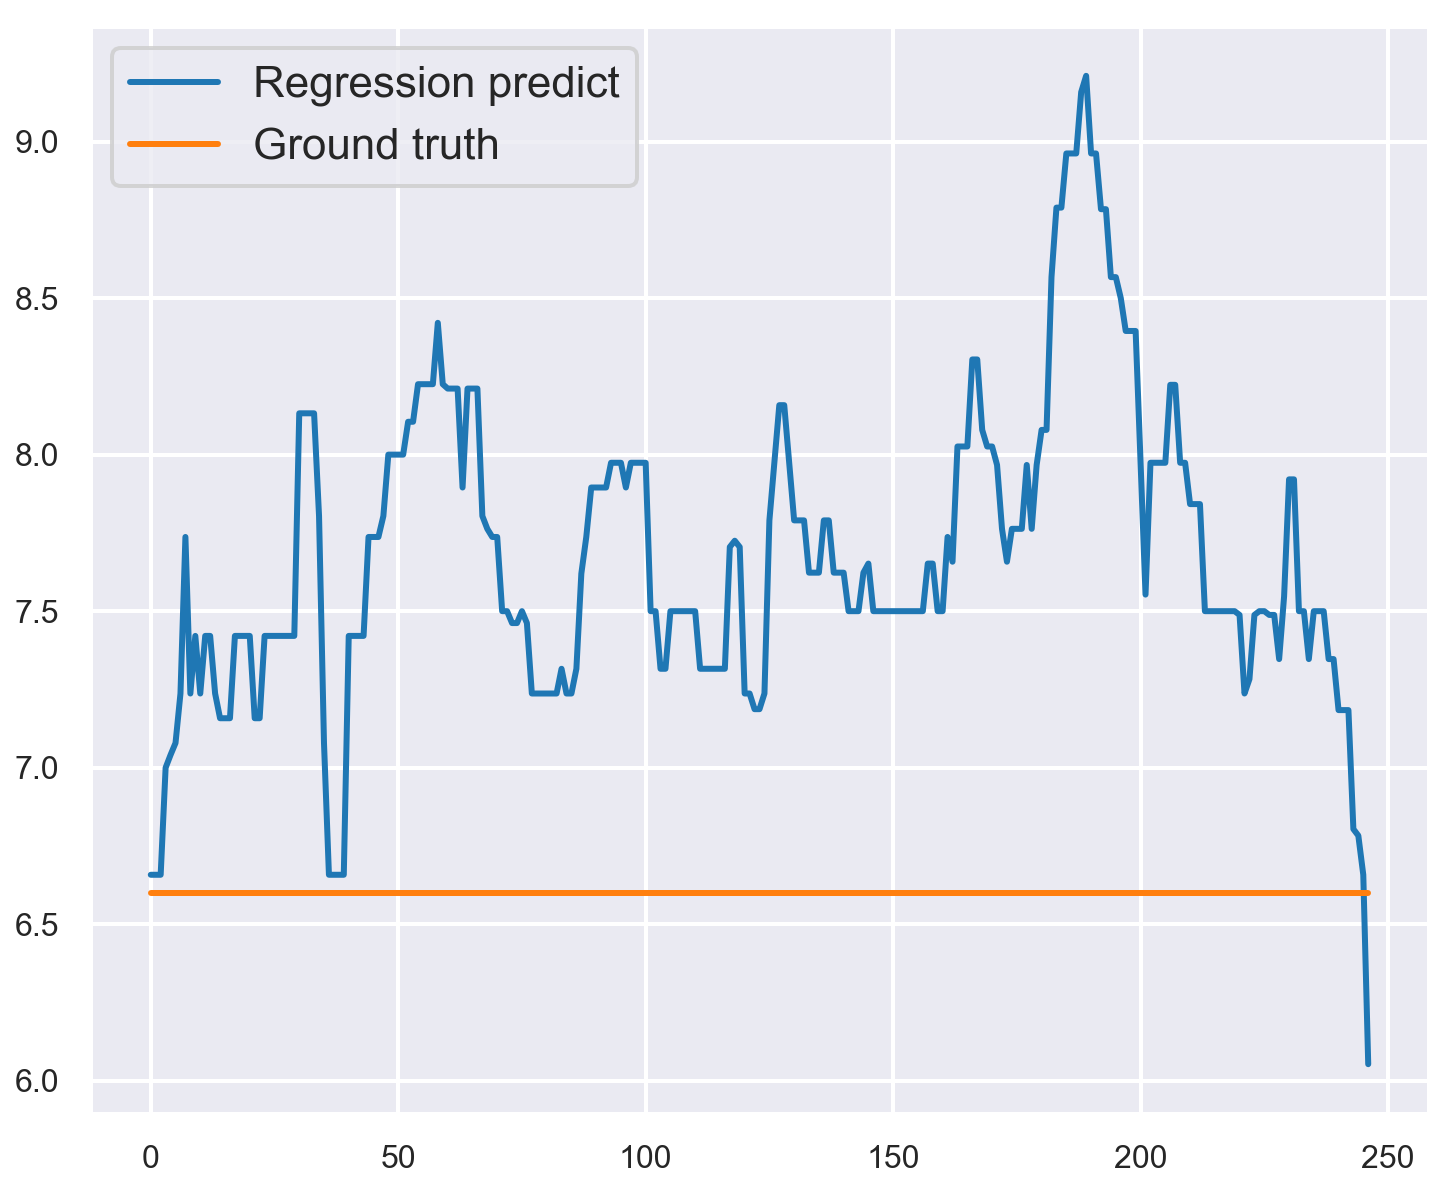

[730]
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, 730,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2921, 1024) (143, 1024) (2921, 1024)
Labels shape: (2921,) (143,)
(143, 2) (2921, 2)


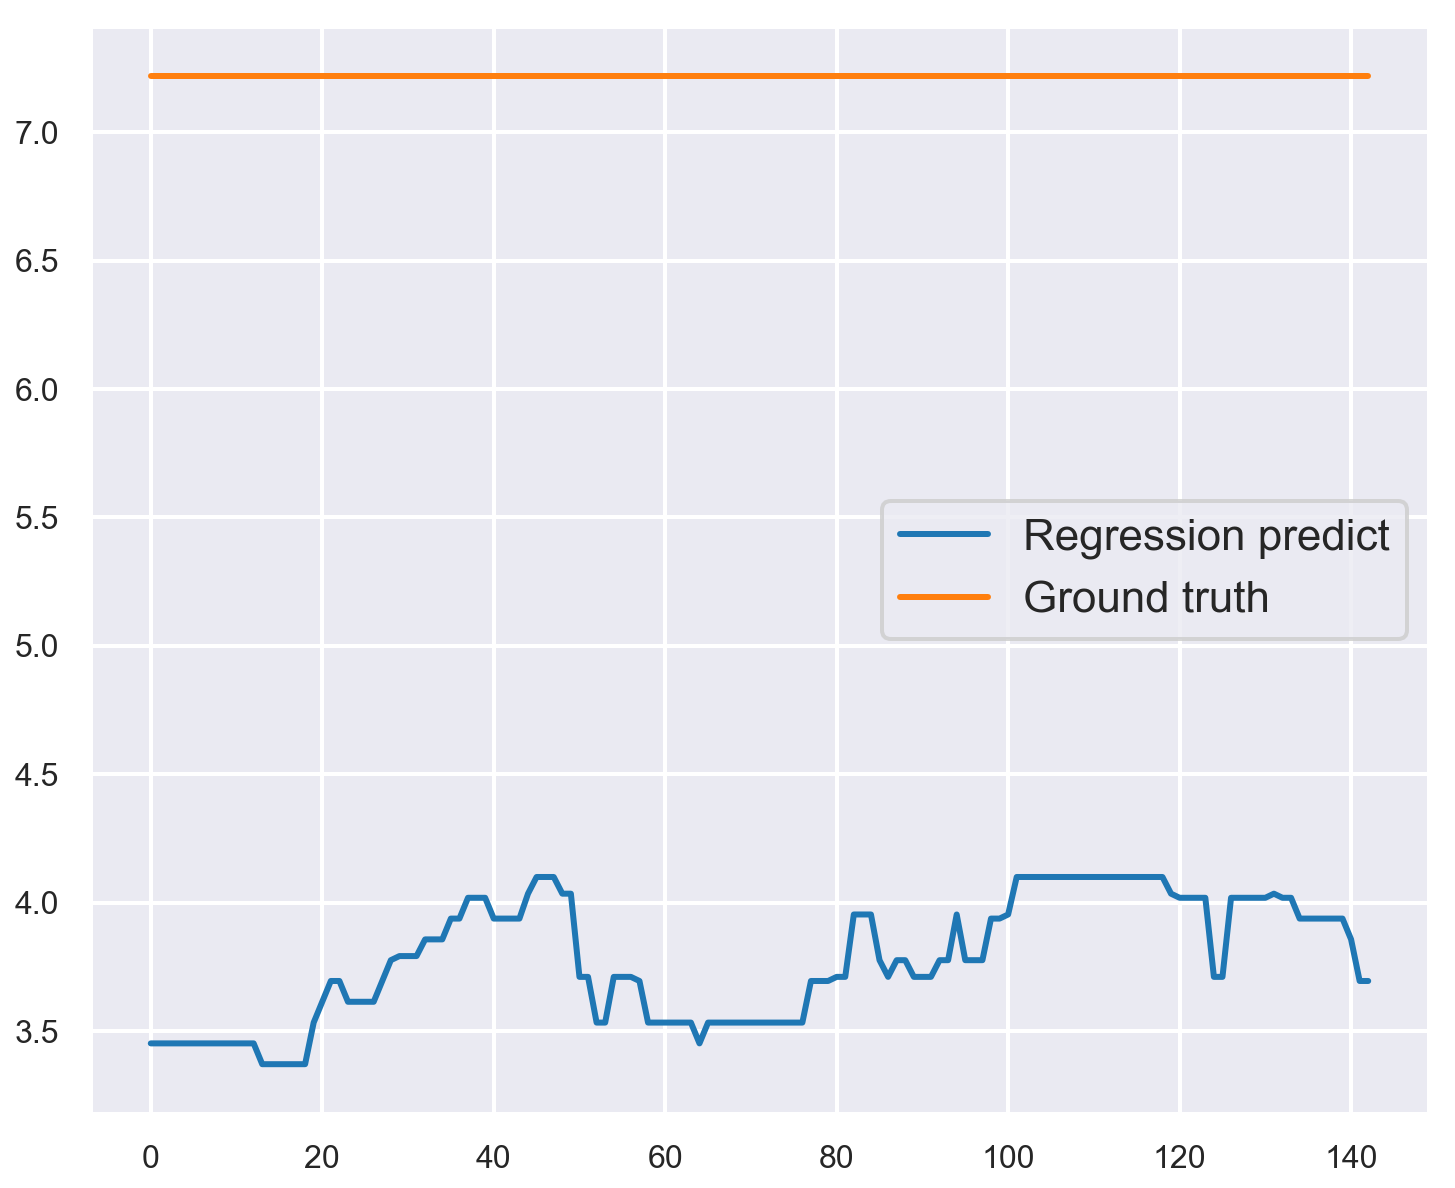

[739]
729,749,750,752,730,Skip,751,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, 739,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2365, 1024) (699, 1024) (2365, 1024)
Labels shape: (2365,) (699,)
(699, 2) (2365, 2)


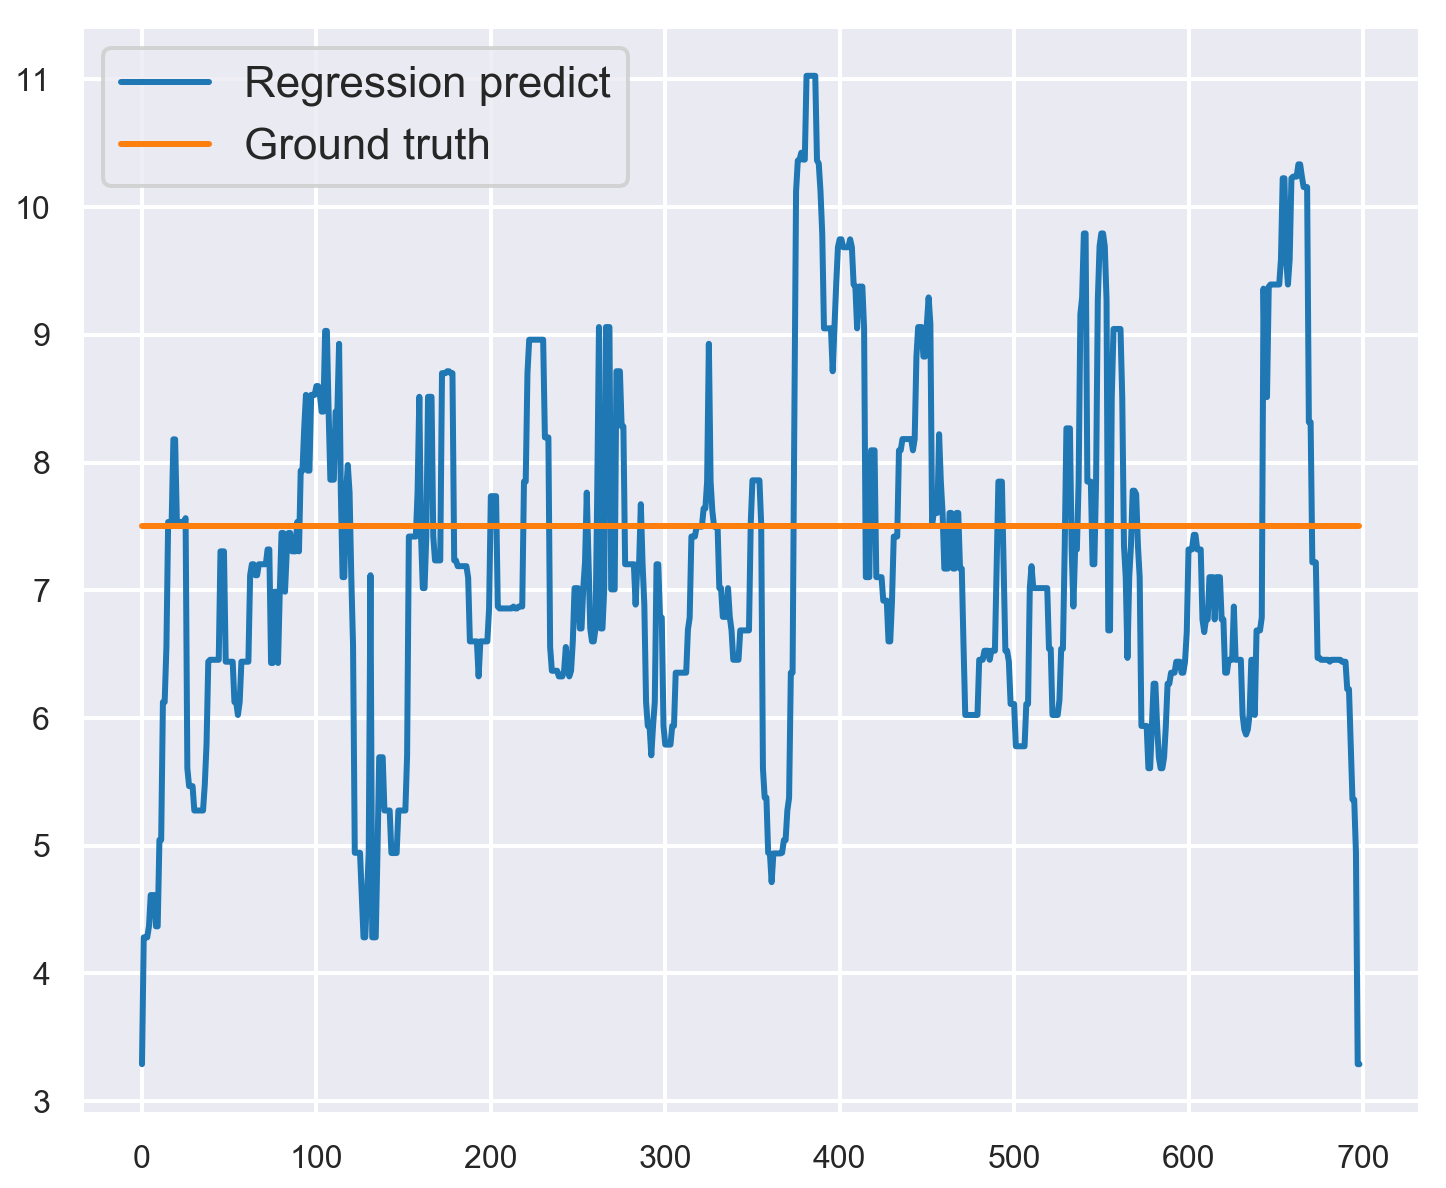

[751]
729,749,750,752,730,739,Skip,754,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, 751,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2998, 1024) (66, 1024) (2998, 1024)
Labels shape: (2998,) (66,)
(66, 2) (2998, 2)


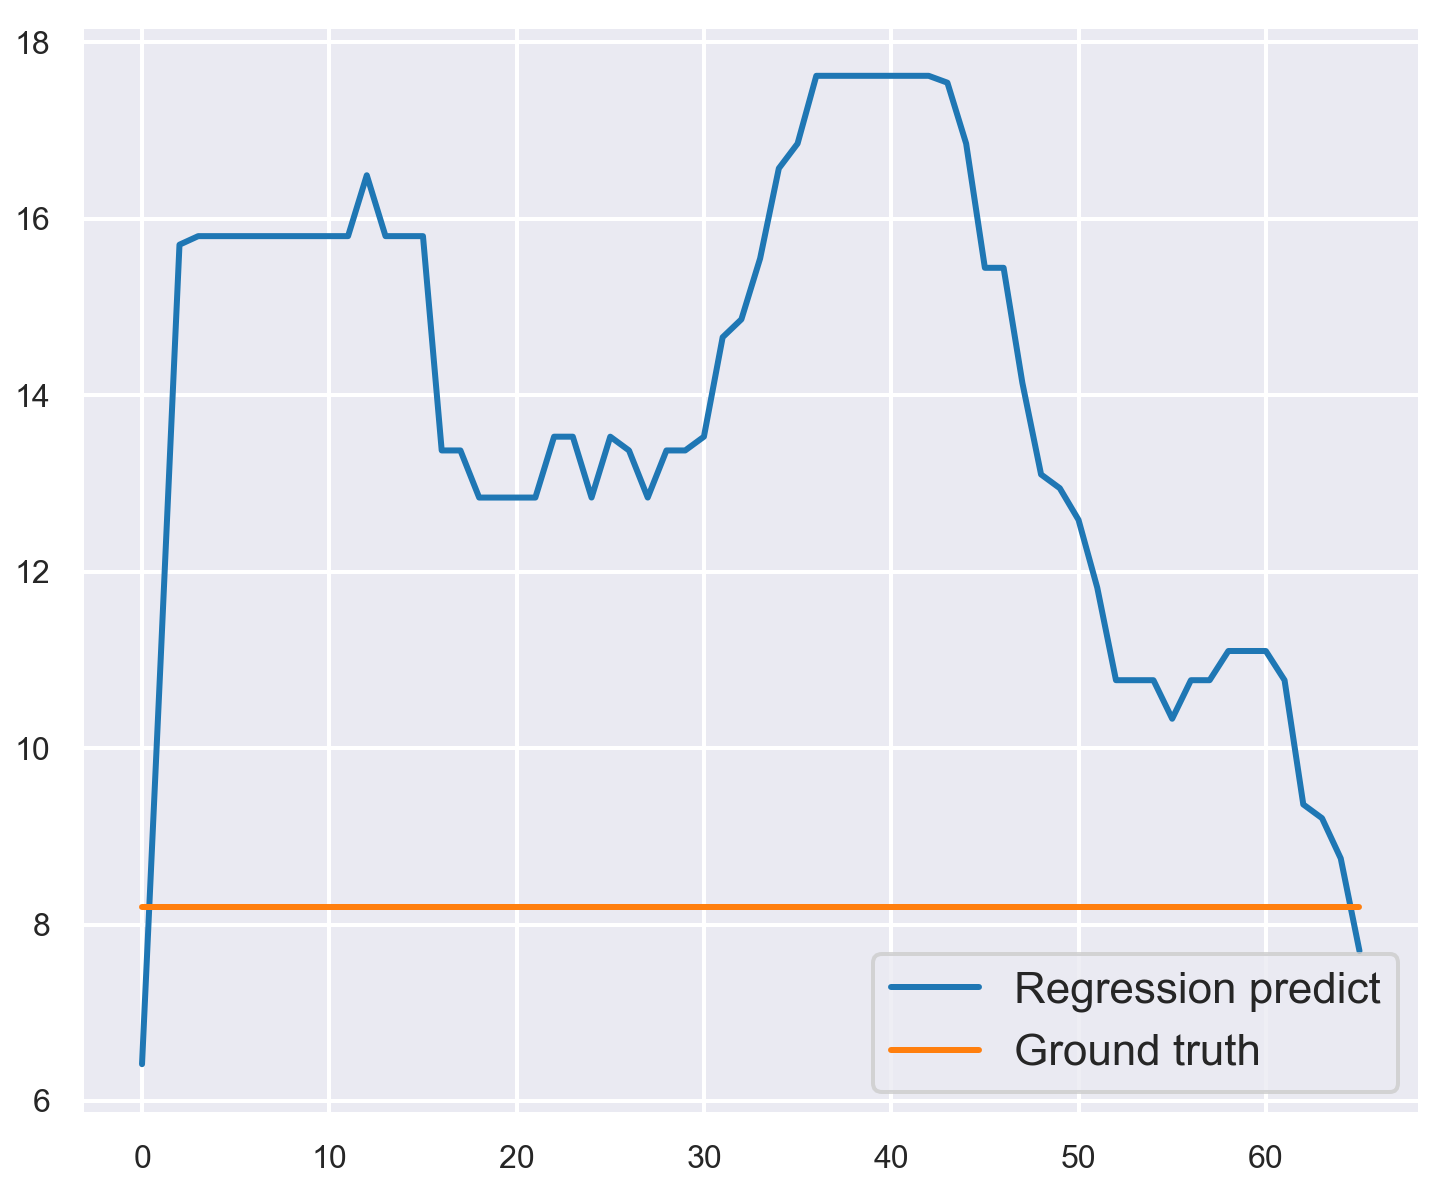

[754]
729,749,750,752,730,739,751,Skip,753,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 754,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (3006, 1024) (58, 1024) (3006, 1024)
Labels shape: (3006,) (58,)
(58, 2) (3006, 2)


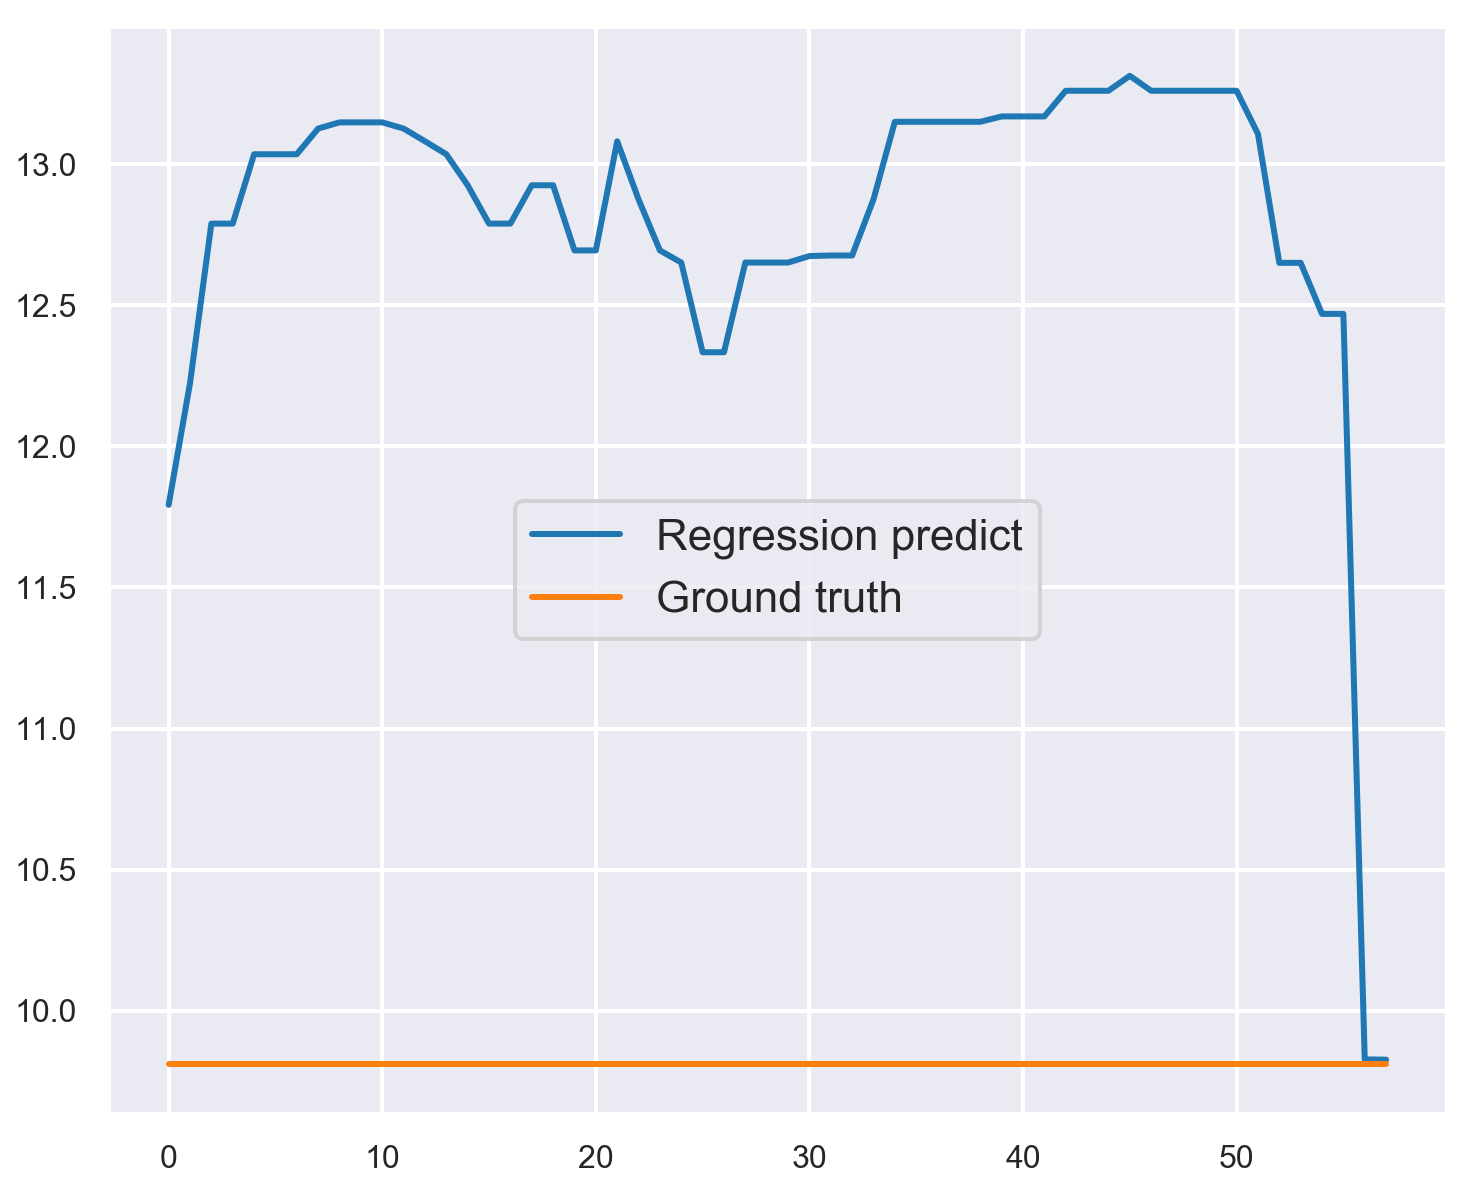

[753]
729,749,750,752,730,739,751,754,Skip,740,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 753,Skip, Skip, Skip, Skip, Skip, Skip, Training and testing shape (2894, 1024) (170, 1024) (2894, 1024)
Labels shape: (2894,) (170,)
(170, 2) (2894, 2)


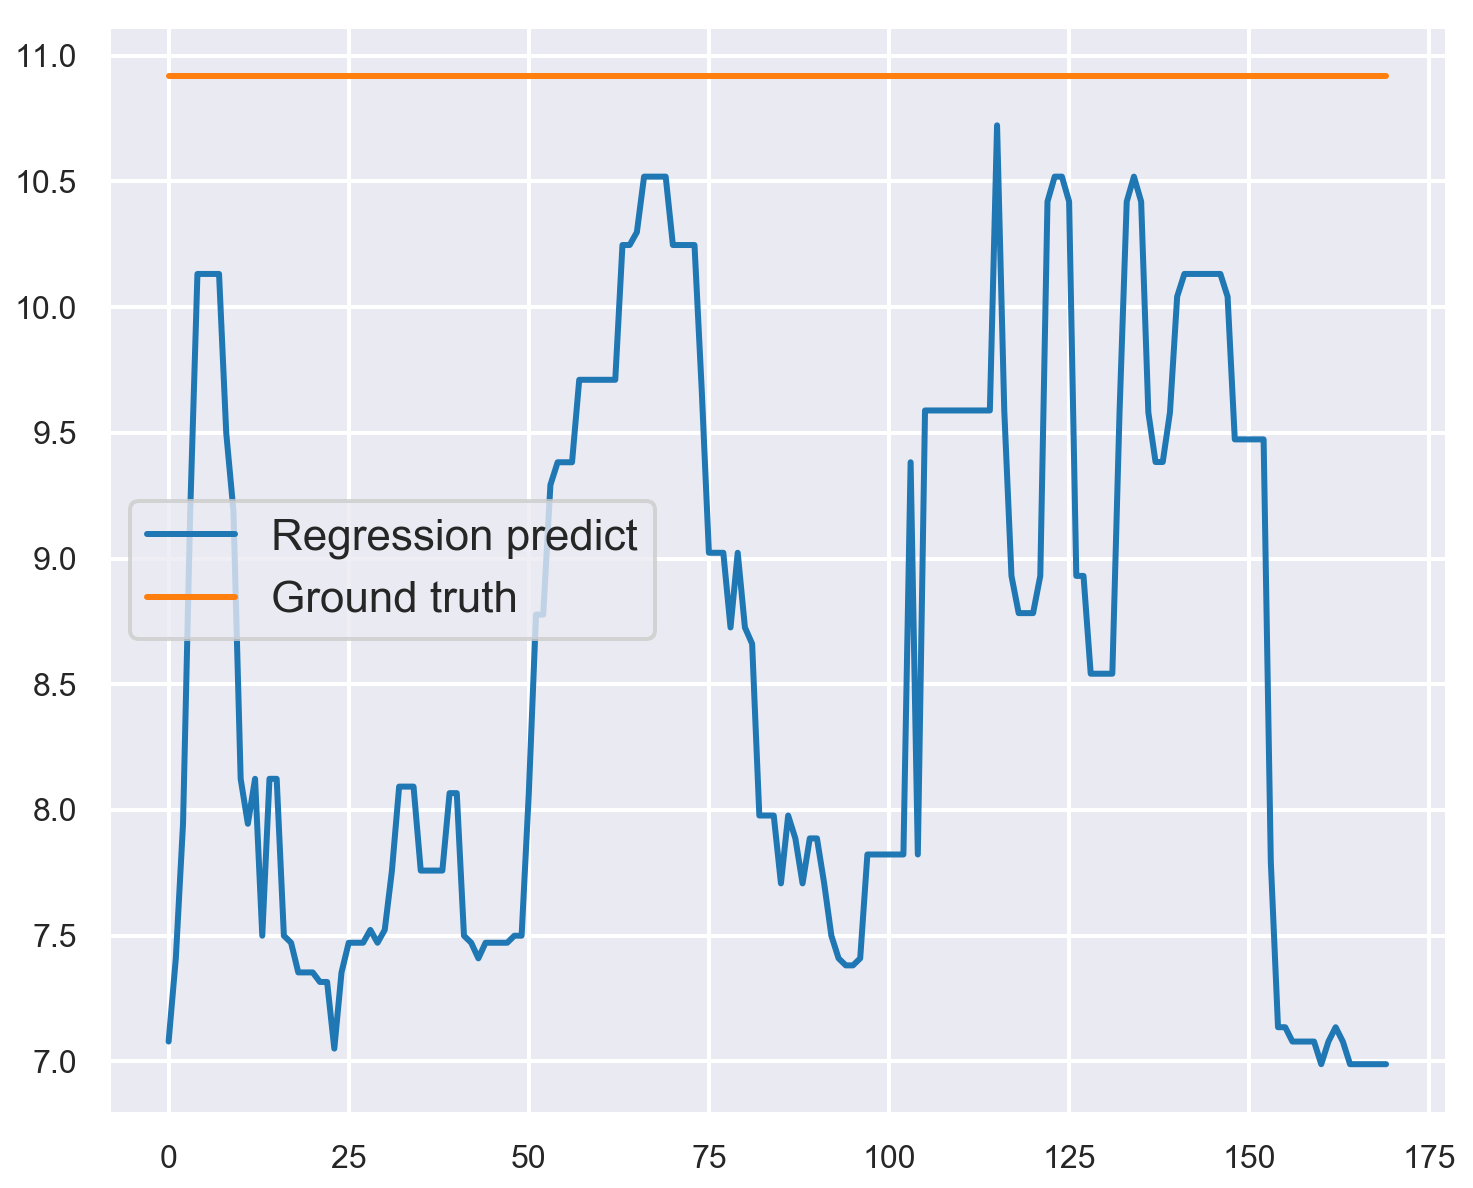

[740]
729,749,750,752,730,739,751,754,753,Skip,731,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 740,Skip, Skip, Skip, Skip, Skip, Training and testing shape (2977, 1024) (87, 1024) (2977, 1024)
Labels shape: (2977,) (87,)
(87, 2) (2977, 2)


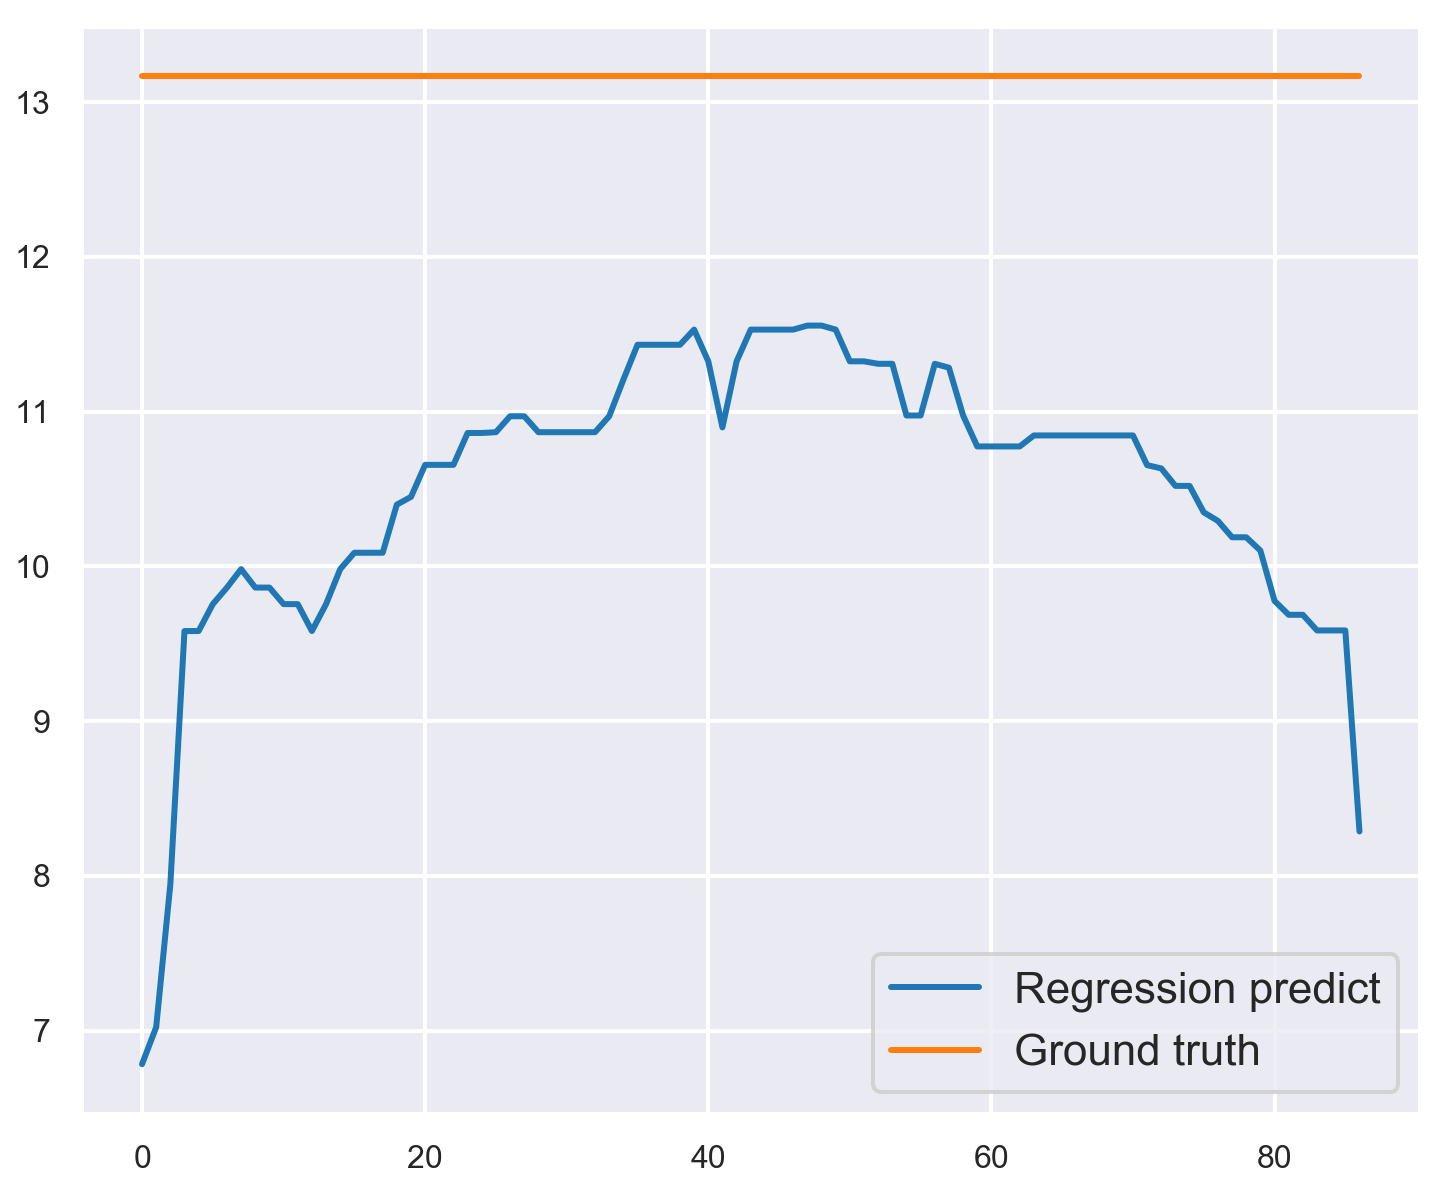

[731]
729,749,750,752,730,739,751,754,753,740,Skip,755,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 731,Skip, Skip, Skip, Skip, Training and testing shape (2926, 1024) (138, 1024) (2926, 1024)
Labels shape: (2926,) (138,)
(138, 2) (2926, 2)


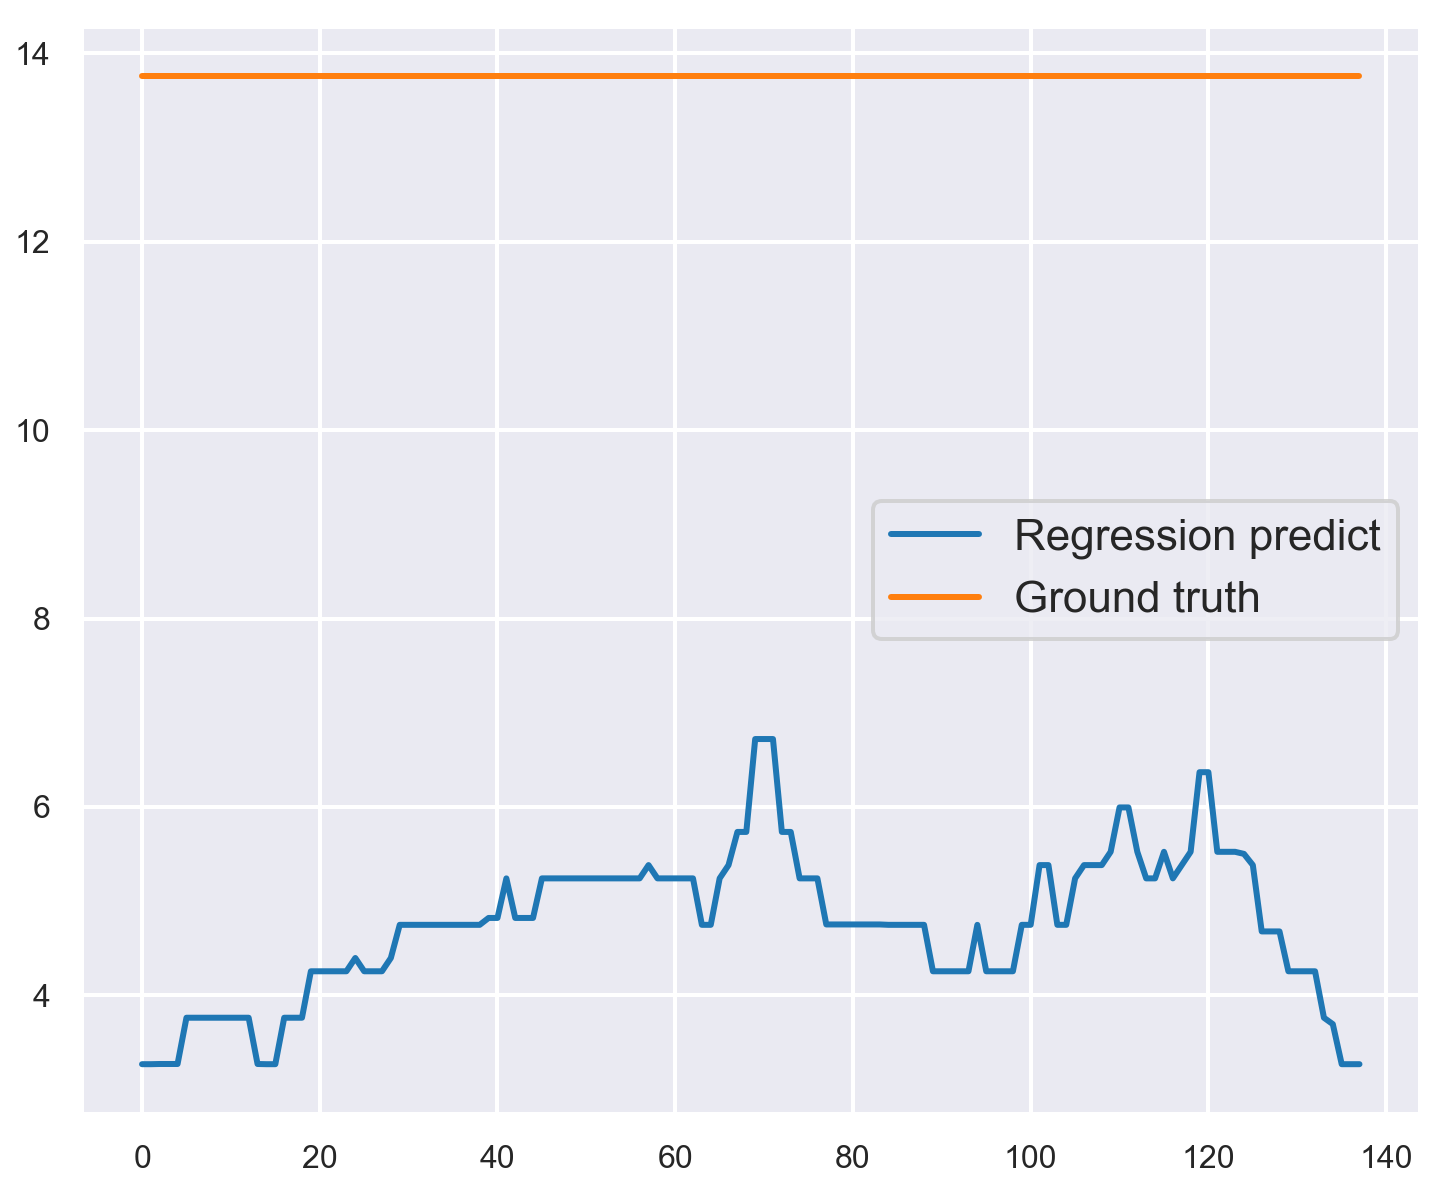

[755]
729,749,750,752,730,739,751,754,753,740,731,Skip,757,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 755,Skip, Skip, Skip, Training and testing shape (2858, 1024) (206, 1024) (2858, 1024)
Labels shape: (2858,) (206,)
(206, 2) (2858, 2)


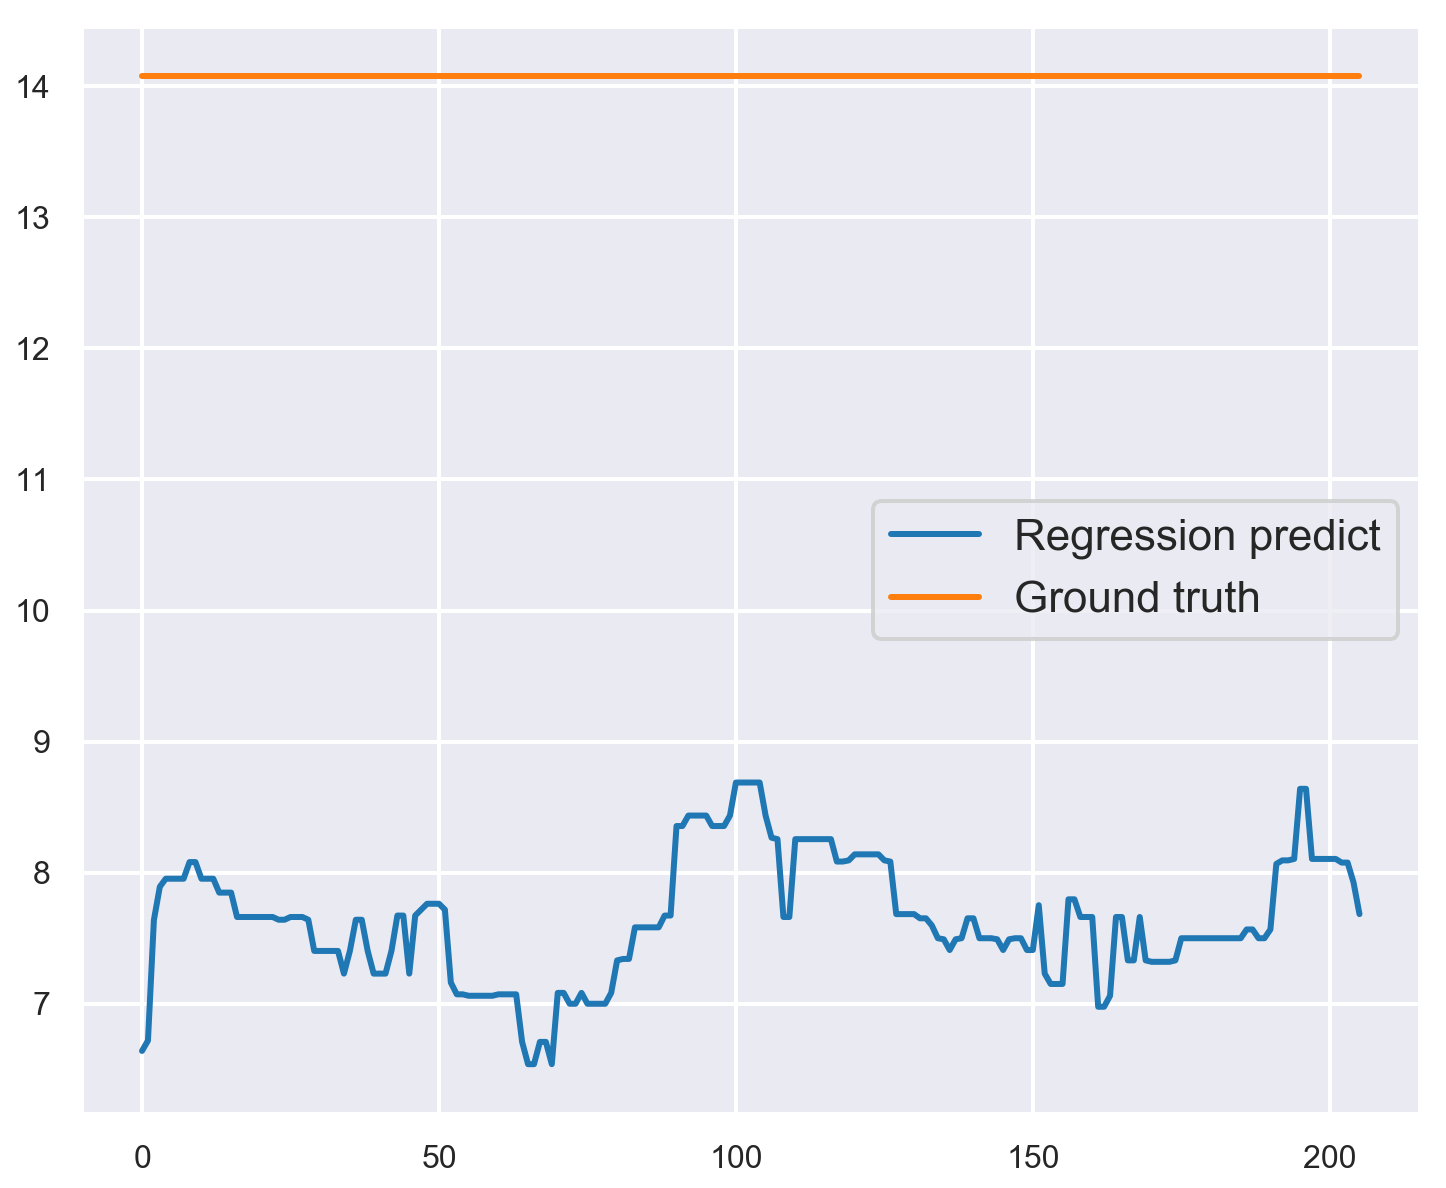

[757]
729,749,750,752,730,739,751,754,753,740,731,755,Skip,756,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 757,Skip, Skip, Training and testing shape (2960, 1024) (104, 1024) (2960, 1024)
Labels shape: (2960,) (104,)
(104, 2) (2960, 2)


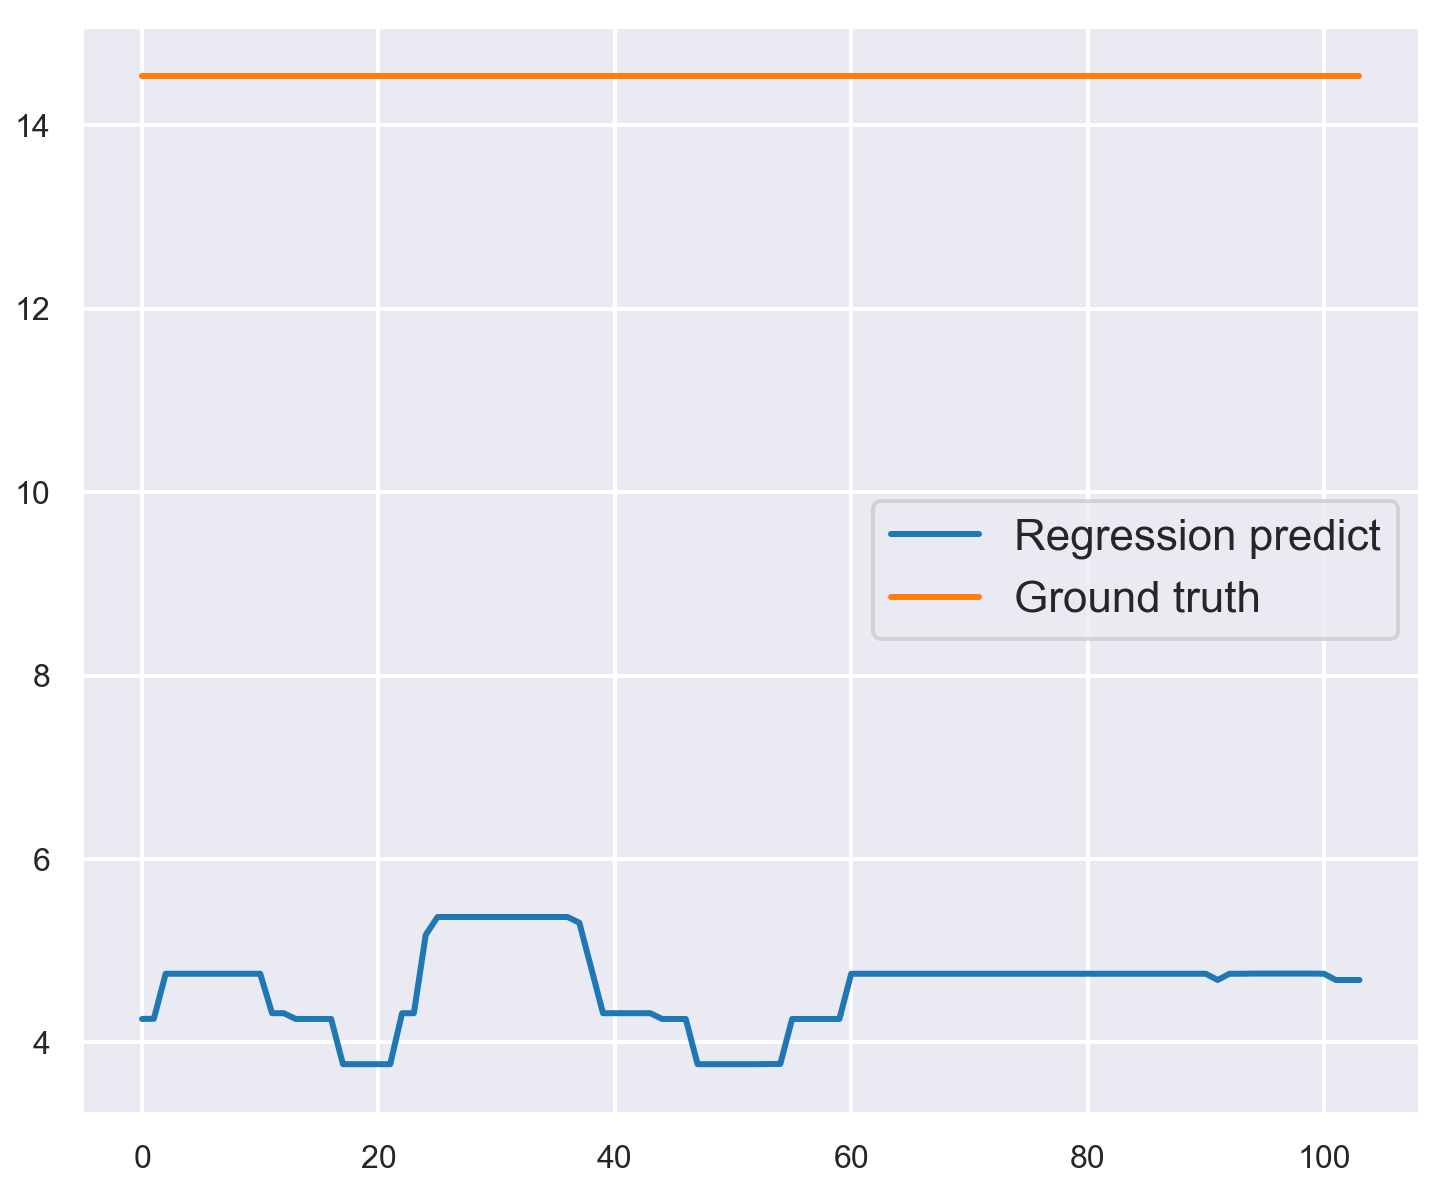

[756]
729,749,750,752,730,739,751,754,753,740,731,755,757,Skip,758,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 756,Skip, Training and testing shape (3023, 1024) (41, 1024) (3023, 1024)
Labels shape: (3023,) (41,)
(41, 2) (3023, 2)


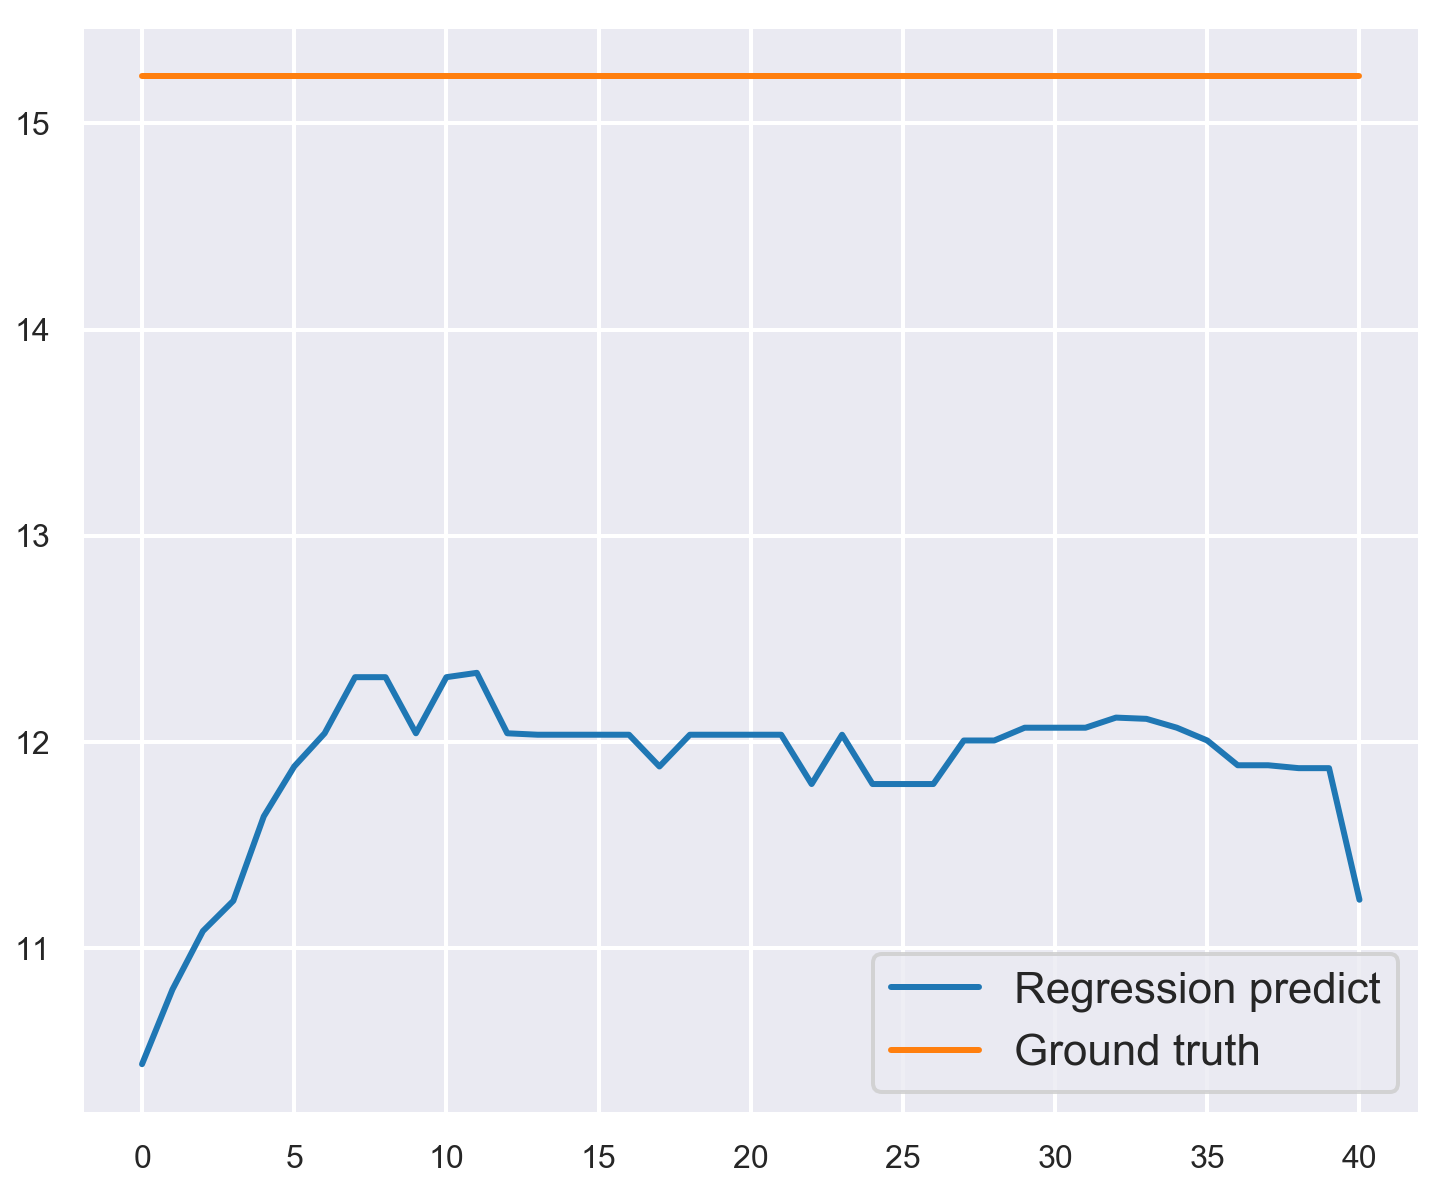

[758]
729,749,750,752,730,739,751,754,753,740,731,755,757,756,Skip,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 758,Training and testing shape (2514, 1024) (550, 1024) (2514, 1024)
Labels shape: (2514,) (550,)
(550, 2) (2514, 2)


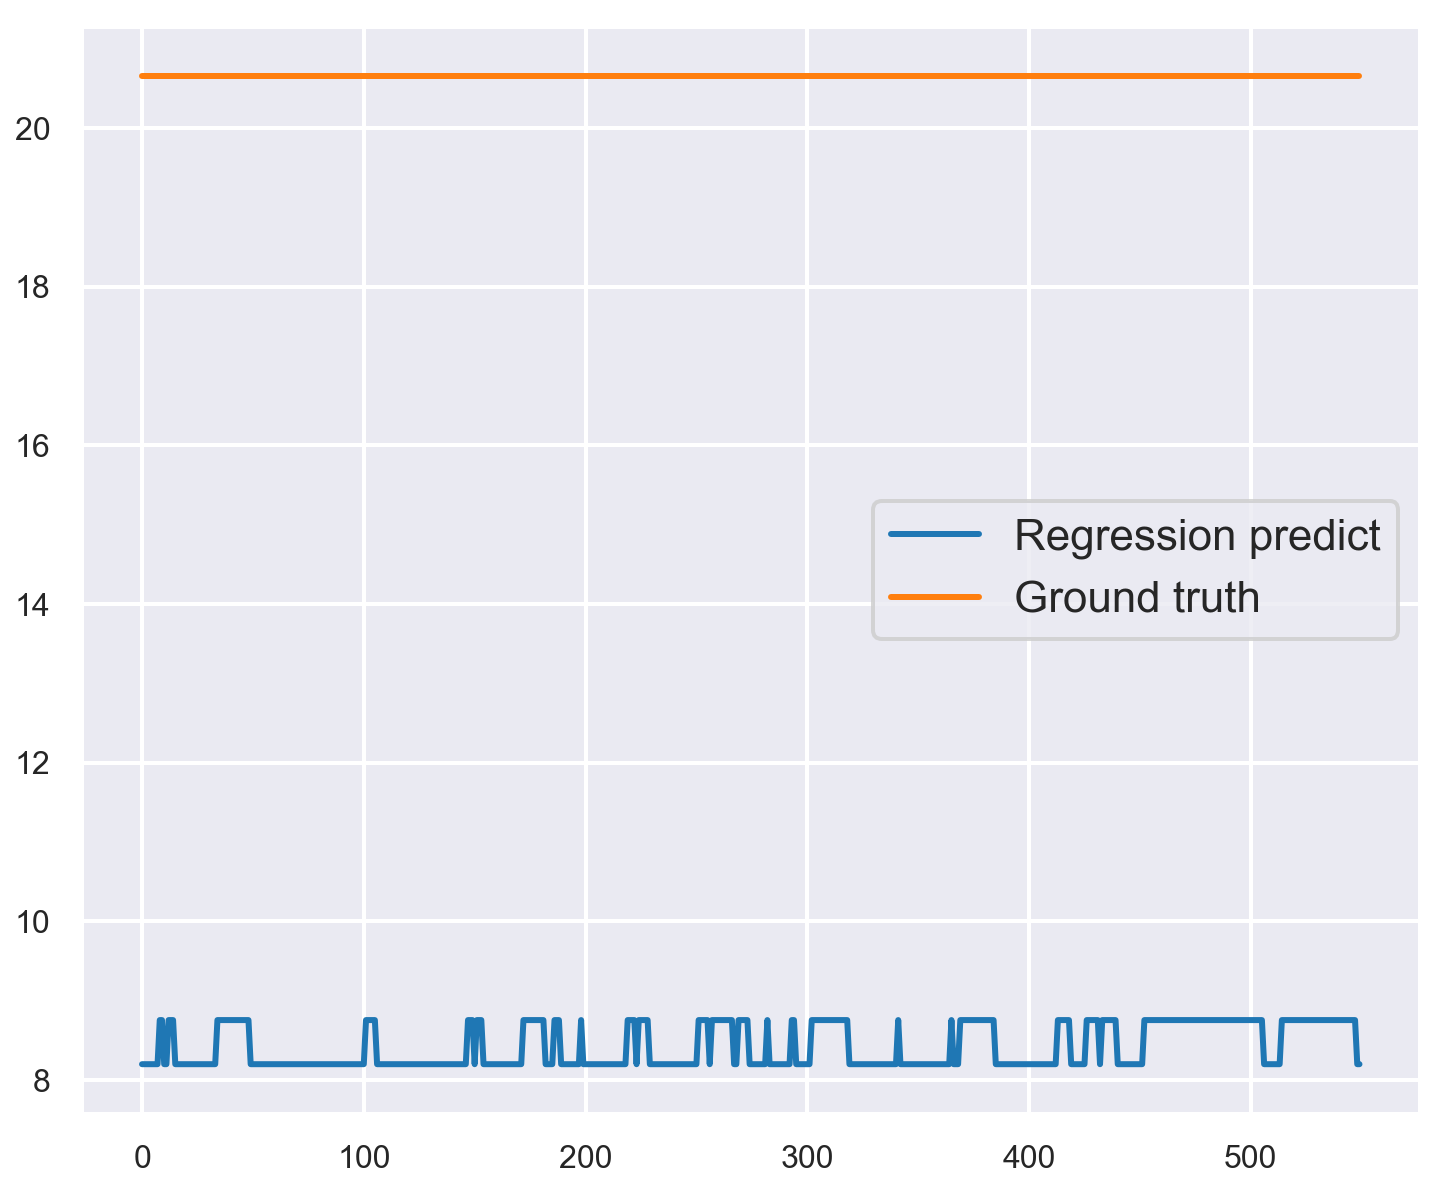

In [22]:
no_components = 2
#no_test_rabbits = no_testing * 2
for i in range(no_cv):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_data(dataBase, testing_idx, BSCs_dict, \
                                         freq_bsc_dict, depth_dict,filter_depth = False, regression=True)
    X_test, y_test, frame_idx, frame_break = get_testing_data(dataBase, testing_idx, BSCs_dict,\
                                                              freq_bsc_dict, depth_dict, filter_depth=False, regression=True)
    
    flat_list = [item for sublist in frame_idx for item in sublist]
    # Randomize the training data. The testing data was not randomized to get the frame by frame accuracy. 
    #(possible to randomize, but need to keep track of the randomization, seems unneccessary). 
    X_train = X_train.T
    X_test = X_test.T
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    
    X_train, idxs1 = filter_bsc(X_train.T)
    y_train = y_train[idxs1]
    
    X_test, idxs2 = filter_bsc(X_test.T)
    y_test = y_test[idxs2]
    
    X_train = X_train.T
    X_test = X_test.T
    X_log = np.log10(X_train)
    
    frame_idx1 = np.array(flat_list)
    frame_idx = frame_idx1[idxs2]
    
    print("Training and testing shape", X_train.shape, X_test.shape, X_log.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    pca.fit(X_log)
    
    features_train  = pca.transform(np.log10(X_train))
    features_test  = pca.transform(np.log10(X_test))
    print(features_test.shape, features_train.shape)
    
    #regr = RandomForestRegressor(max_depth=10, random_state=0)
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    #regr.fit(features_train, y_train)
    #print(regr.feature_importances_)

    #y_rf_predict = regr.predict(features_test)
    y_rf_predict = regr.predict(X_test)
    plt.figure(figsize = (12, 10))
    plt.plot(scipy.signal.medfilt(y_rf_predict, 15), label = 'Regression predict')
    plt.plot(y_test, label = 'Ground truth')
    plt.legend()
    plt.show()
    #break

In [46]:
y_rf_predict.shape

(1671,)

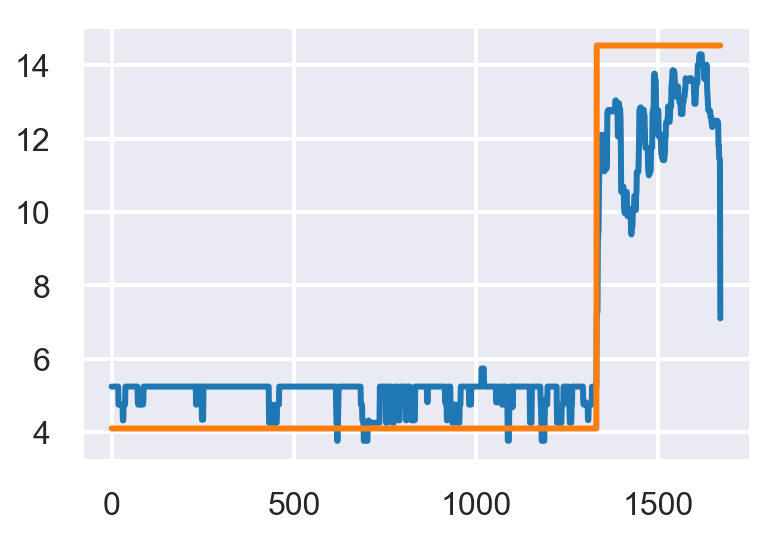

In [58]:
plt.plot(scipy.signal.medfilt(y_rf_predict, 25))
plt.plot(y_test)

In [47]:
y_test.shape

(1671,)

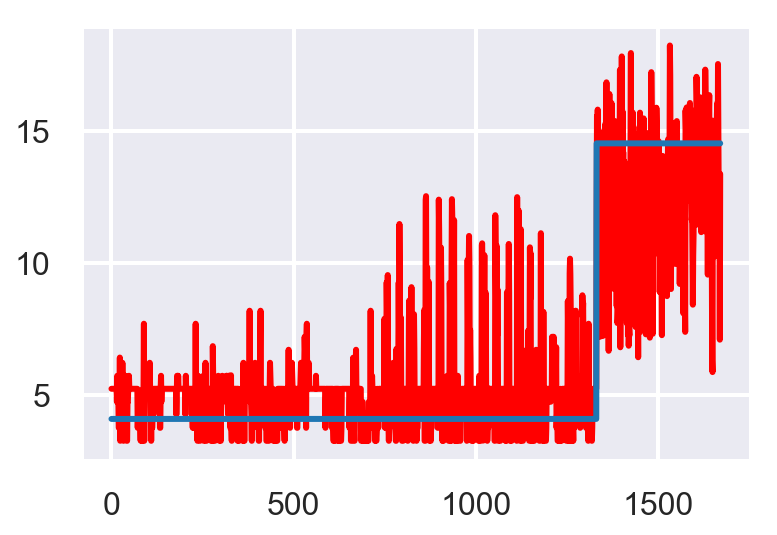

In [48]:
plt.plot(y_rf_predict, 'r')
plt.plot(y_test)

In [49]:
y_rf_predict[1200:1250]

array([ 5.242     ,  5.242     ,  5.242     ,  4.749     ,  4.749     ,
        4.749     ,  5.242     ,  5.242     ,  5.242     ,  7.214     ,
        5.242     ,  5.242     ,  5.242     ,  7.214     ,  5.242     ,
        5.242     ,  5.242     ,  5.735     ,  5.242     ,  5.242     ,
        6.81921687,  3.763     ,  4.256     ,  4.256     ,  3.276     ,
        3.27      ,  3.769     ,  3.274     ,  3.27      ,  3.27      ,
        3.27      ,  3.27      ,  5.242     ,  3.763     ,  4.256     ,
        3.27      ,  4.749     ,  5.242     ,  5.242     ,  5.242     ,
        5.242     ,  5.242     ,  5.242     ,  5.242     ,  5.242     ,
        5.242     ,  5.242     ,  5.242     ,  3.27      ,  4.256     ])

In [50]:
y_test[1200:1250]

array([ 4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,
        4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,
        4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,
        4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,  4.1,
        4.1,  4.1,  4.1,  4.1,  4.1,  4.1])

In [30]:
tips = sns.load_dataset("tips")

In [31]:
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
5         25.29  4.71    Male     No   Sun  Dinner     4
6          8.77  2.00    Male     No   Sun  Dinner     2
7         26.88  3.12    Male     No   Sun  Dinner     4
8         15.04  1.96    Male     No   Sun  Dinner     2
9         14.78  3.23    Male     No   Sun  Dinner     2
10        10.27  1.71    Male     No   Sun  Dinner     2
11        35.26  5.00  Female     No   Sun  Dinner     4
12        15.42  1.57    Male     No   Sun  Dinner     2
13        18.43  3.00    Male     No   Sun  Dinner     4
14        14.83  3.02  Female     No   Sun  Dinner     2
15        21.58  3.92    Male     No   Sun  Dinner     2
16        10.33  1.67  Female     No   Sun  Dinner     3
17        16.29  3.71    Male     No   Sun  Dinner     3
18        16.97  3.50  Female     No   Sun  Dinner     3
19        20.65  3.35    Male     No   Sat  Dinner     3
20        17.92  4.08    Male     No   Sat  Dinner     2
21        20.29  2.75  Female     No   Sat  Dinner     2
22        15.77  2.23  Female     No   Sat  Dinner     2
23        39.42  7.58    Male     No   Sat  Dinner     4
24        19.82  3.18    Male     No   Sat  Dinner     2
25        17.81  2.34    Male     No   Sat  Dinner     4
26        13.37  2.00    Male     No   Sat  Dinner     2
27        12.69  2.00    Male     No   Sat  Dinner     2
28        21.70  4.30    Male     No   Sat  Dinner     2
29        19.65  3.00  Female     No   Sat  Dinner     2
..          ...   ...     ...    ...   ...     ...   ...
214       28.17  6.50  Female    Yes   Sat  Dinner     3
215       12.90  1.10  Female    Yes   Sat  Dinner     2
216       28.15  3.00    Male    Yes   Sat  Dinner     5
217       11.59  1.50    Male    Yes   Sat  Dinner     2
218        7.74  1.44    Male    Yes   Sat  Dinner     2
219       30.14  3.09  Female    Yes   Sat  Dinner     4
220       12.16  2.20    Male    Yes   Fri   Lunch     2
221       13.42  3.48  Female    Yes   Fri   Lunch     2
222        8.58  1.92    Male    Yes   Fri   Lunch     1
223       15.98  3.00  Female     No   Fri   Lunch     3
224       13.42  1.58    Male    Yes   Fri   Lunch     2
225       16.27  2.50  Female    Yes   Fri   Lunch     2
226       10.09  2.00  Female    Yes   Fri   Lunch     2
227       20.45  3.00    Male     No   Sat  Dinner     4
228       13.28  2.72    Male     No   Sat  Dinner     2
229       22.12  2.88  Female    Yes   Sat  Dinner     2
230       24.01  2.00    Male    Yes   Sat  Dinner     4
231       15.69  3.00    Male    Yes   Sat  Dinner     3
232       11.61  3.39    Male     No   Sat  Dinner     2
233       10.77  1.47    Male     No   Sat  Dinner     2
234       15.53  3.00    Male    Yes   Sat  Dinner     2
235       10.07  1.25    Male     No   Sat  Dinner     2
236       12.60  1.00    Male    Yes   Sat  Dinner     2
237       32.83  1.17    Male    Yes   Sat  Dinner     2
238       35.83  4.67  Female     No   Sat  Dinner     3
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]